In [0]:
import torch 
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np 

In [0]:
dim = 28
def mnist_data():
    transform=transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.ToTensor()
                ])

    data = datasets.MNIST(root='./dataset', train=True,
                                        download=True, transform=transform)
    
    return data

In [0]:
data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

num_batches = len(data_loader)

In [0]:
data_sel = []
labels_to_sel = [1,4,7]

batch_size = 152 #124

for pixels, labels in data_loader:
    #print(pixels)
    #print(labels)
    
    for label, img in zip(labels, pixels):
        if label in labels_to_sel:    
            d = [img, label]
            data_sel.append(d)

#print(len(data_sel)) 
#data_sel = data_sel[:-1]
#print(len(data_sel)) 

data_loader = torch.utils.data.DataLoader(data_sel, batch_size=100, shuffle=True)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = dim*dim
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
            

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), dim*dim)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, dim, dim)

In [0]:
class GeneratorNet(torch.nn.Module):
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = dim*dim
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [57]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
# Load pre trained model
generator.load_state_dict(torch.load('gen.model'))
generator.eval()

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [0]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)


# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(real_data.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [61]:
num_test_samples = 16
test_noise = noise(num_test_samples)
print(test_noise.view(1,-1))

tensor([[-0.7247, -0.6572, -0.3445,  ...,  0.6797, -0.7669, -0.4770]],
       device='cuda:0')


Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3896, Generator Loss: 0.7152
D(x): 0.5041, D(G(z)): 0.5057
Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 0.9449, Generator Loss: 4.2345
D(x): 0.7109, D(G(z)): 0.2570


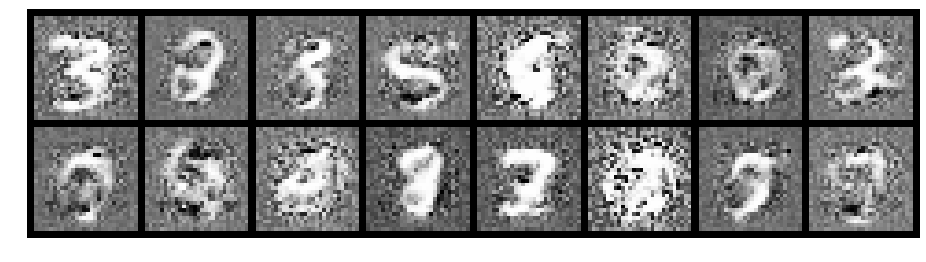

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.4362, Generator Loss: 3.7017
D(x): 0.8011, D(G(z)): 0.1539
Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.3795, Generator Loss: 5.3798
D(x): 0.8376, D(G(z)): 0.1114


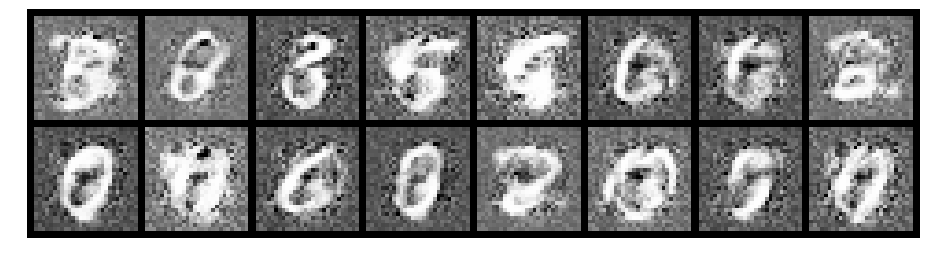

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.5364, Generator Loss: 4.3498
D(x): 0.7242, D(G(z)): 0.0832
Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.4436, Generator Loss: 4.8310
D(x): 0.8517, D(G(z)): 0.1652


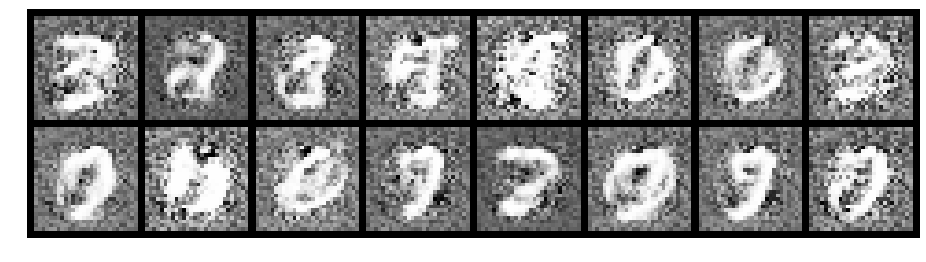

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.4277, Generator Loss: 4.6835
D(x): 0.8196, D(G(z)): 0.1157
Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.7249, Generator Loss: 4.4563
D(x): 0.7832, D(G(z)): 0.1550


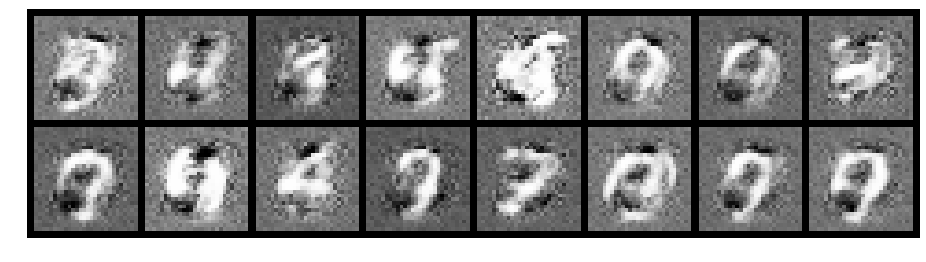

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.7258, Generator Loss: 2.6679
D(x): 0.7567, D(G(z)): 0.2106
Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.8519, Generator Loss: 3.8897
D(x): 0.7119, D(G(z)): 0.1774


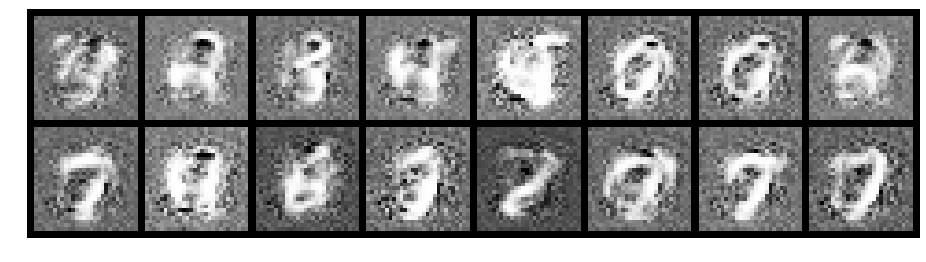

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.3668, Generator Loss: 3.2323
D(x): 0.8972, D(G(z)): 0.1776
Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.5347, Generator Loss: 2.4479
D(x): 0.8282, D(G(z)): 0.1979


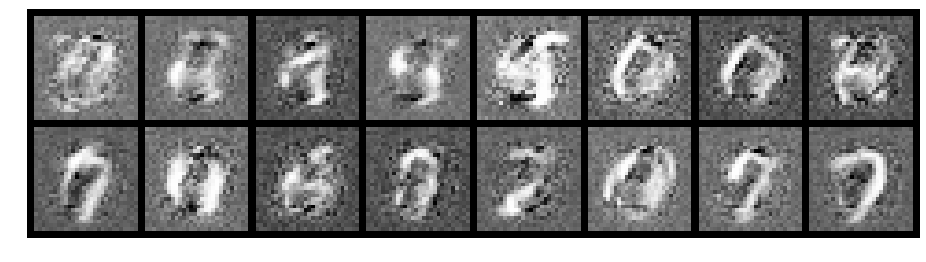

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.7217, Generator Loss: 2.9005
D(x): 0.8046, D(G(z)): 0.2401
Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.4714, Generator Loss: 2.9608
D(x): 0.8407, D(G(z)): 0.1818


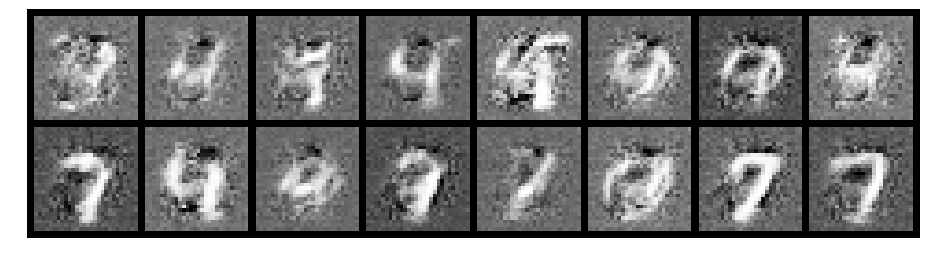

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 1.0209, Generator Loss: 1.7793
D(x): 0.6402, D(G(z)): 0.2893
Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 1.0736, Generator Loss: 2.6249
D(x): 0.7077, D(G(z)): 0.3050


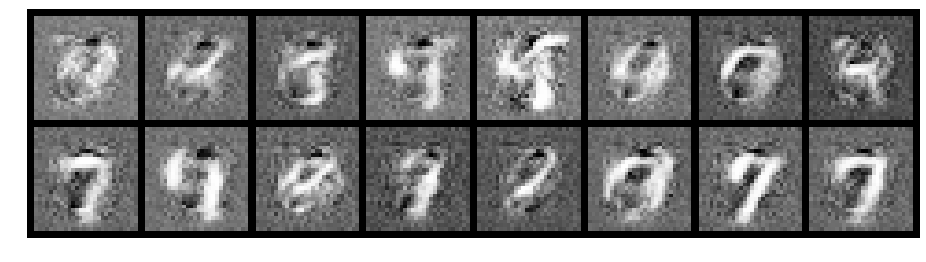

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.5397, Generator Loss: 2.0337
D(x): 0.8545, D(G(z)): 0.2526
Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 1.0087, Generator Loss: 2.1144
D(x): 0.7091, D(G(z)): 0.2690


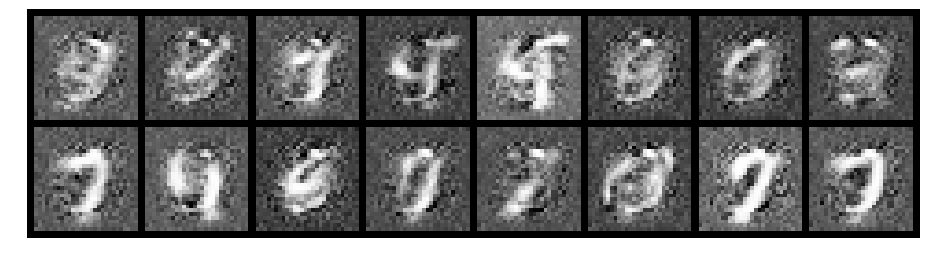

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.3966, Generator Loss: 2.3162
D(x): 0.8415, D(G(z)): 0.1652
Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.8947, Generator Loss: 1.3954
D(x): 0.7049, D(G(z)): 0.3369


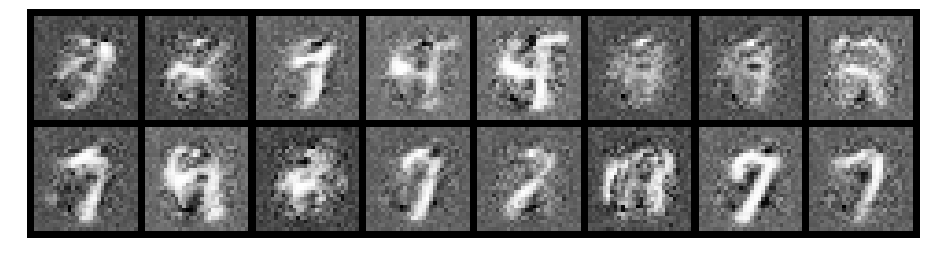

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.8044, Generator Loss: 2.0925
D(x): 0.7991, D(G(z)): 0.3171
Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 1.1604, Generator Loss: 1.6879
D(x): 0.6123, D(G(z)): 0.3214


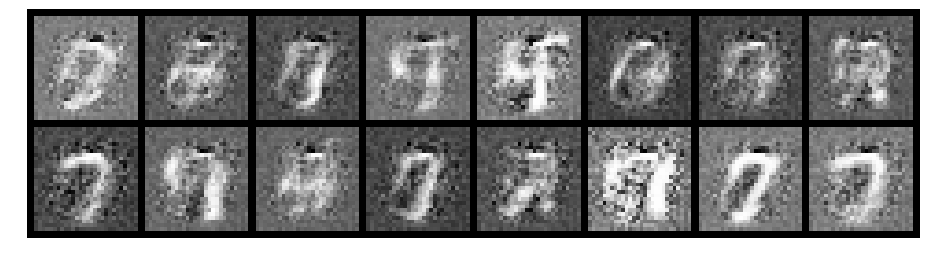

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.7233, Generator Loss: 1.6225
D(x): 0.7632, D(G(z)): 0.2990
Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.8744, Generator Loss: 1.6610
D(x): 0.7325, D(G(z)): 0.3322


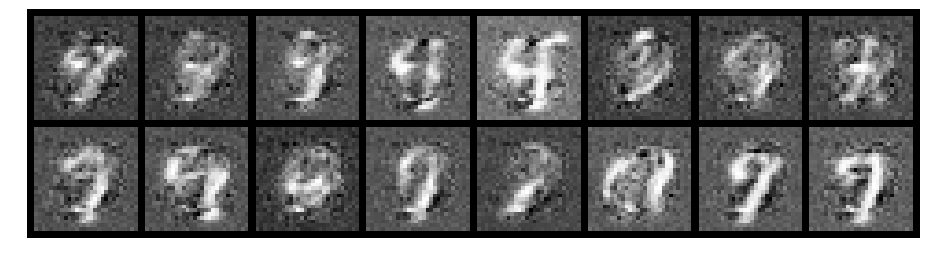

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.9091, Generator Loss: 1.5271
D(x): 0.7582, D(G(z)): 0.3408
Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.5849, Generator Loss: 1.9480
D(x): 0.7784, D(G(z)): 0.2124


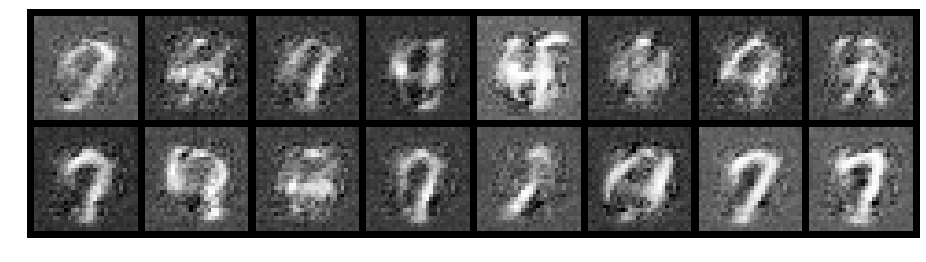

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.7821, Generator Loss: 1.5530
D(x): 0.7503, D(G(z)): 0.2826
Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.9986, Generator Loss: 1.8573
D(x): 0.6859, D(G(z)): 0.3069


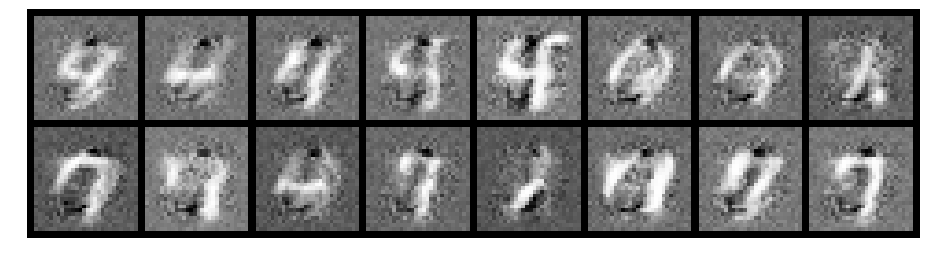

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 1.2433, Generator Loss: 1.5331
D(x): 0.5803, D(G(z)): 0.3350
Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.2955, Generator Loss: 2.0431
D(x): 0.9608, D(G(z)): 0.2100


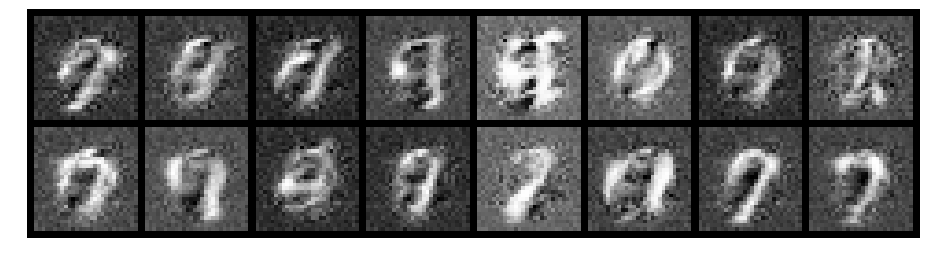

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.5933, Generator Loss: 1.8951
D(x): 0.8225, D(G(z)): 0.2055
Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.9788, Generator Loss: 1.5084
D(x): 0.6958, D(G(z)): 0.3290


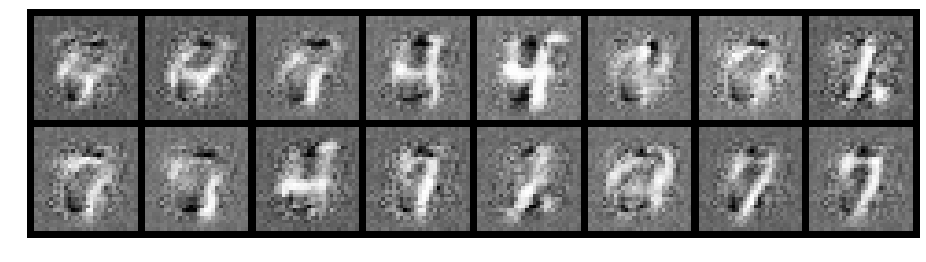

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.6941, Generator Loss: 1.7686
D(x): 0.8072, D(G(z)): 0.3079
Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.8683, Generator Loss: 1.3173
D(x): 0.7318, D(G(z)): 0.3450


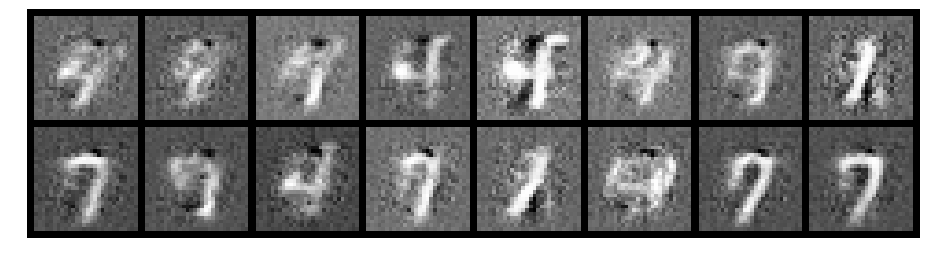

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.7470, Generator Loss: 1.3169
D(x): 0.7909, D(G(z)): 0.3436
Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.8141, Generator Loss: 1.6754
D(x): 0.7493, D(G(z)): 0.3212


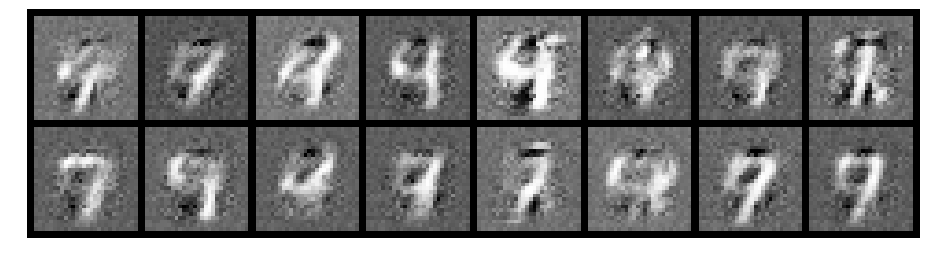

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.9420, Generator Loss: 1.1520
D(x): 0.6786, D(G(z)): 0.3599
Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.7137, Generator Loss: 2.7055
D(x): 0.8512, D(G(z)): 0.2644


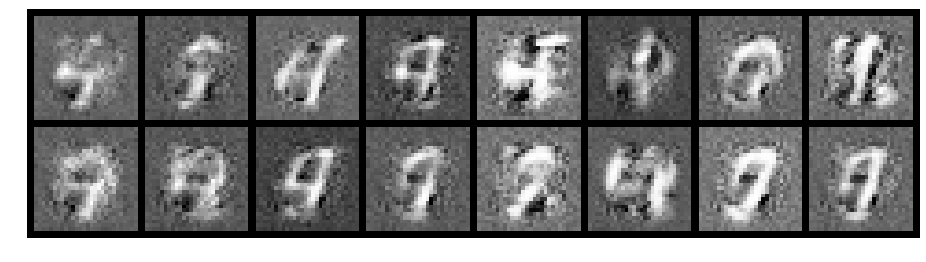

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.6669, Generator Loss: 1.4003
D(x): 0.7833, D(G(z)): 0.2939
Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 1.4580, Generator Loss: 2.0805
D(x): 0.5463, D(G(z)): 0.3651


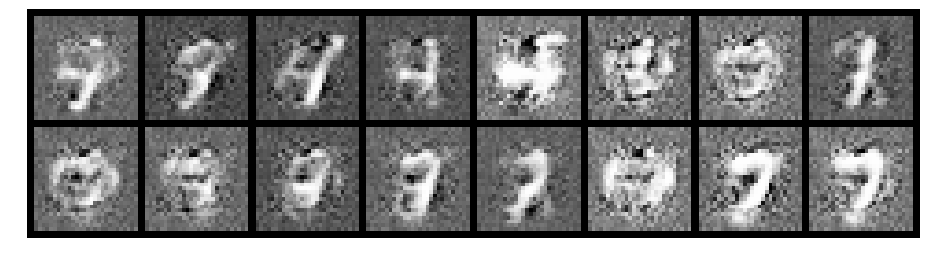

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.6942, Generator Loss: 1.8455
D(x): 0.8295, D(G(z)): 0.3373
Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 1.2816, Generator Loss: 1.2705
D(x): 0.6128, D(G(z)): 0.3859


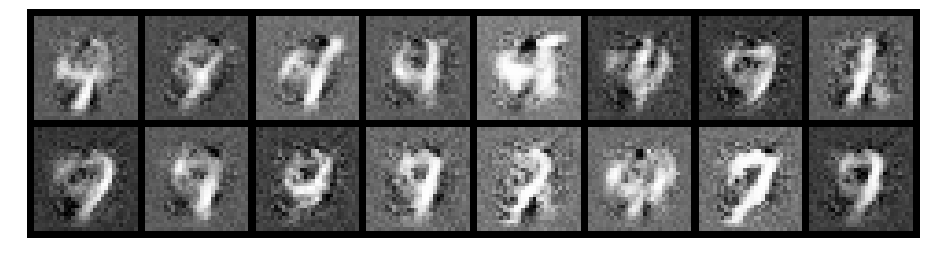

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 1.1897, Generator Loss: 1.1871
D(x): 0.6134, D(G(z)): 0.3887
Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 1.0612, Generator Loss: 1.2121
D(x): 0.6507, D(G(z)): 0.3685


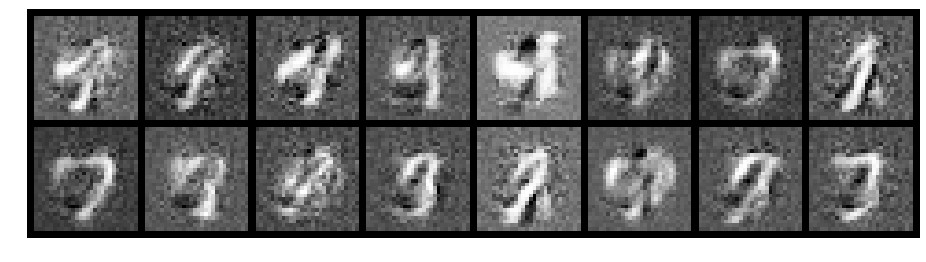

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 1.0403, Generator Loss: 1.2895
D(x): 0.6439, D(G(z)): 0.3617
Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.7903, Generator Loss: 1.2487
D(x): 0.7546, D(G(z)): 0.3415


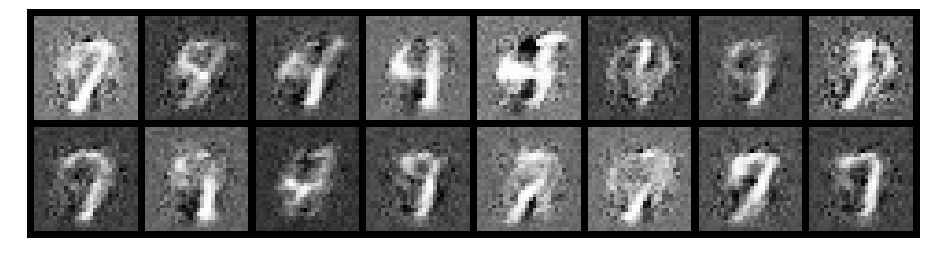

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 1.4557, Generator Loss: 1.3439
D(x): 0.5831, D(G(z)): 0.4265
Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 0.8954, Generator Loss: 1.2677
D(x): 0.7337, D(G(z)): 0.3496


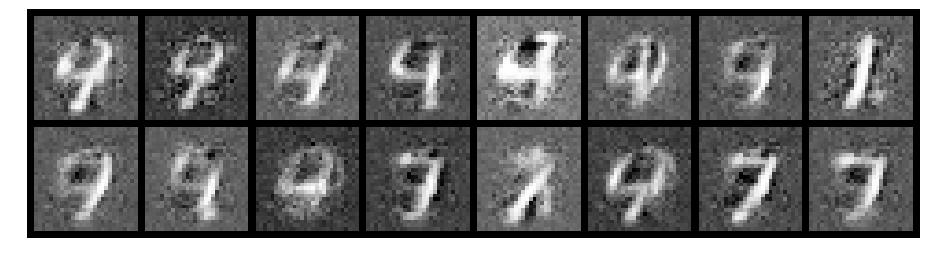

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 1.2080, Generator Loss: 0.9427
D(x): 0.5923, D(G(z)): 0.4234
Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 0.9487, Generator Loss: 1.0773
D(x): 0.6942, D(G(z)): 0.3798


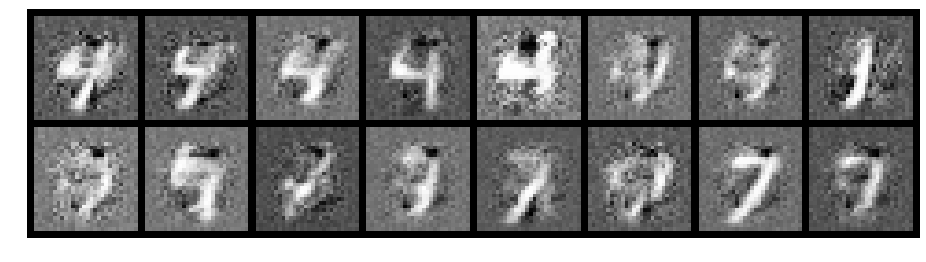

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 0.9302, Generator Loss: 1.0691
D(x): 0.7083, D(G(z)): 0.3753
Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 1.1865, Generator Loss: 1.0385
D(x): 0.6235, D(G(z)): 0.4161


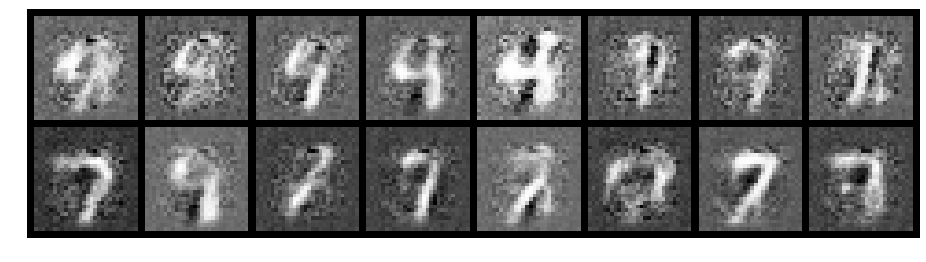

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 1.2950, Generator Loss: 1.0270
D(x): 0.5504, D(G(z)): 0.4101
Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 1.2590, Generator Loss: 1.3382
D(x): 0.6165, D(G(z)): 0.3722


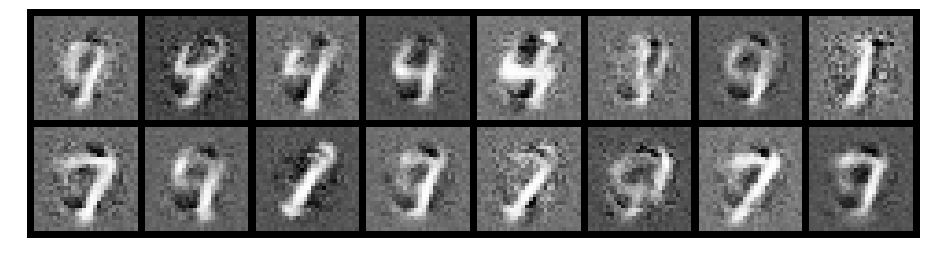

Epoch: [27/200], Batch Num: [0/600]
Discriminator Loss: 0.6724, Generator Loss: 1.4034
D(x): 0.7914, D(G(z)): 0.2989
Epoch: [27/200], Batch Num: [100/600]
Discriminator Loss: 1.2751, Generator Loss: 1.4320
D(x): 0.6511, D(G(z)): 0.3869


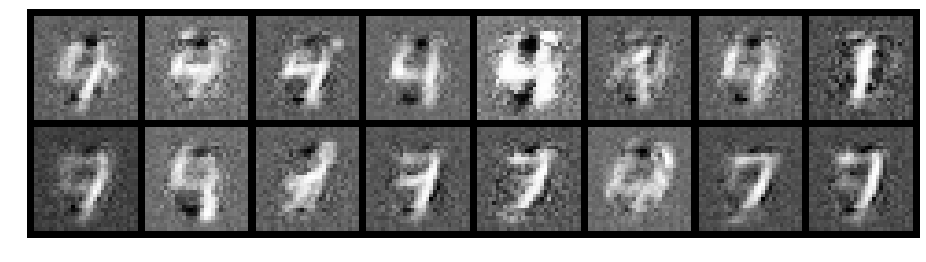

Epoch: [28/200], Batch Num: [0/600]
Discriminator Loss: 0.6742, Generator Loss: 1.5744
D(x): 0.9274, D(G(z)): 0.3582
Epoch: [28/200], Batch Num: [100/600]
Discriminator Loss: 0.9890, Generator Loss: 1.5389
D(x): 0.7167, D(G(z)): 0.3617


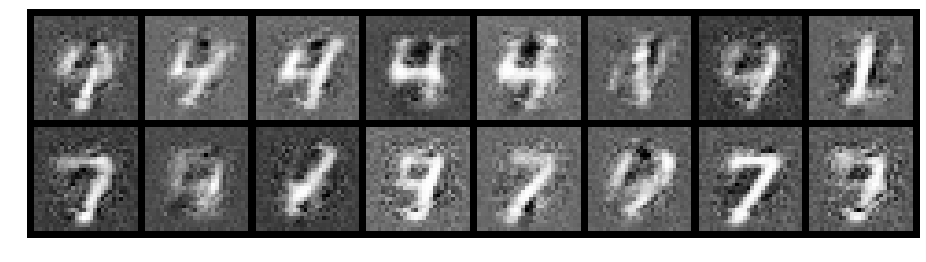

Epoch: [29/200], Batch Num: [0/600]
Discriminator Loss: 1.1500, Generator Loss: 1.1066
D(x): 0.6581, D(G(z)): 0.4117
Epoch: [29/200], Batch Num: [100/600]
Discriminator Loss: 1.1159, Generator Loss: 0.9585
D(x): 0.6340, D(G(z)): 0.4038


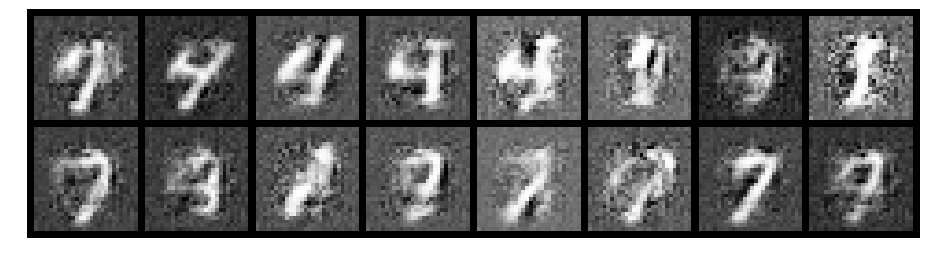

Epoch: [30/200], Batch Num: [0/600]
Discriminator Loss: 0.9154, Generator Loss: 1.5826
D(x): 0.6902, D(G(z)): 0.3092
Epoch: [30/200], Batch Num: [100/600]
Discriminator Loss: 1.1286, Generator Loss: 1.3830
D(x): 0.6007, D(G(z)): 0.3605


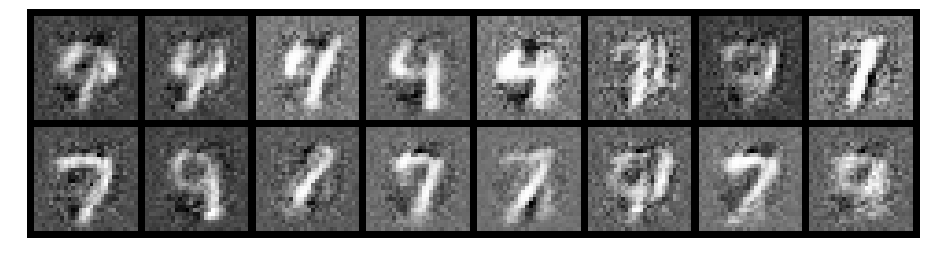

Epoch: [31/200], Batch Num: [0/600]
Discriminator Loss: 0.6705, Generator Loss: 1.4275
D(x): 0.7825, D(G(z)): 0.2861
Epoch: [31/200], Batch Num: [100/600]
Discriminator Loss: 0.7354, Generator Loss: 1.0916
D(x): 0.8401, D(G(z)): 0.3919


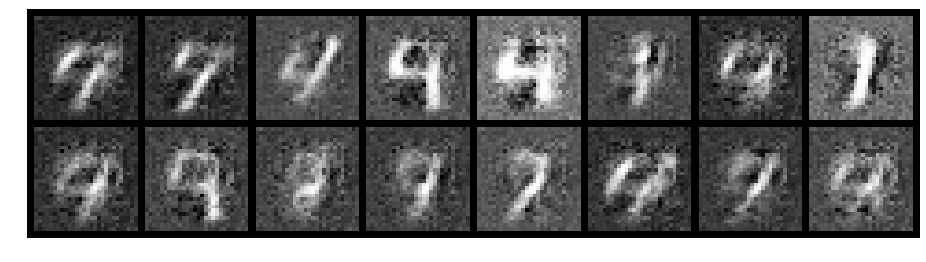

Epoch: [32/200], Batch Num: [0/600]
Discriminator Loss: 0.7988, Generator Loss: 1.1907
D(x): 0.7477, D(G(z)): 0.3465
Epoch: [32/200], Batch Num: [100/600]
Discriminator Loss: 1.0876, Generator Loss: 1.3156
D(x): 0.6932, D(G(z)): 0.3507


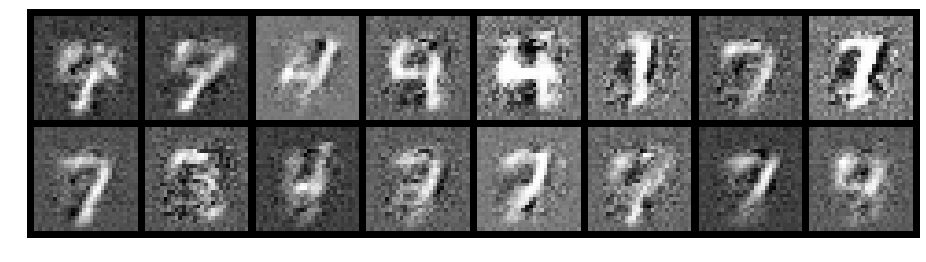

Epoch: [33/200], Batch Num: [0/600]
Discriminator Loss: 1.0479, Generator Loss: 1.0458
D(x): 0.7124, D(G(z)): 0.4318
Epoch: [33/200], Batch Num: [100/600]
Discriminator Loss: 1.0631, Generator Loss: 1.1497
D(x): 0.6222, D(G(z)): 0.3913


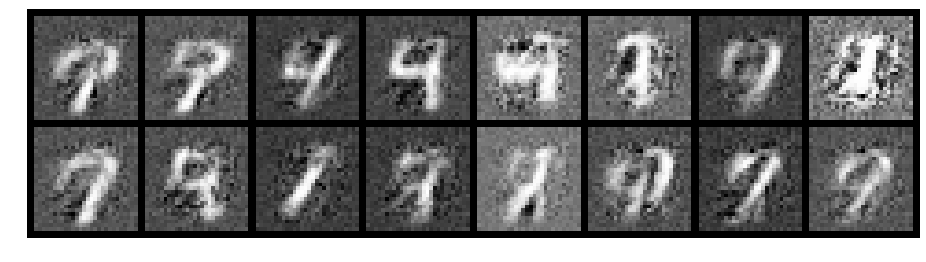

Epoch: [34/200], Batch Num: [0/600]
Discriminator Loss: 0.9030, Generator Loss: 1.5300
D(x): 0.7175, D(G(z)): 0.3110
Epoch: [34/200], Batch Num: [100/600]
Discriminator Loss: 0.9935, Generator Loss: 1.0845
D(x): 0.6700, D(G(z)): 0.3544


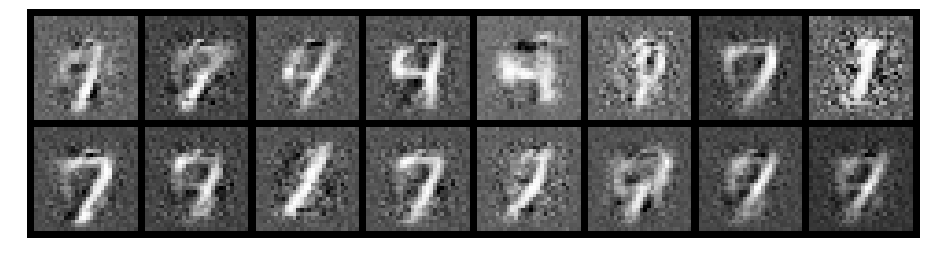

Epoch: [35/200], Batch Num: [0/600]
Discriminator Loss: 1.0171, Generator Loss: 1.0636
D(x): 0.6743, D(G(z)): 0.4032
Epoch: [35/200], Batch Num: [100/600]
Discriminator Loss: 0.9215, Generator Loss: 1.6330
D(x): 0.6610, D(G(z)): 0.2830


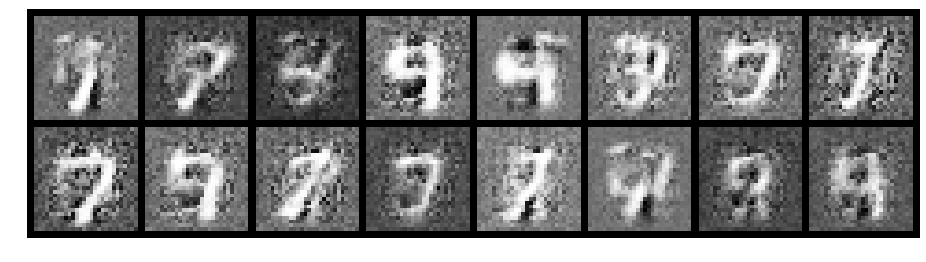

Epoch: [36/200], Batch Num: [0/600]
Discriminator Loss: 0.9504, Generator Loss: 1.2805
D(x): 0.6559, D(G(z)): 0.3140
Epoch: [36/200], Batch Num: [100/600]
Discriminator Loss: 1.0726, Generator Loss: 1.2537
D(x): 0.6501, D(G(z)): 0.3651


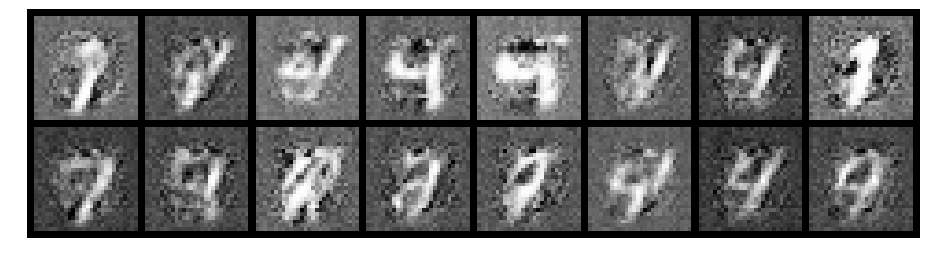

Epoch: [37/200], Batch Num: [0/600]
Discriminator Loss: 1.1545, Generator Loss: 1.2380
D(x): 0.6085, D(G(z)): 0.3727
Epoch: [37/200], Batch Num: [100/600]
Discriminator Loss: 1.1360, Generator Loss: 0.9989
D(x): 0.5795, D(G(z)): 0.3829


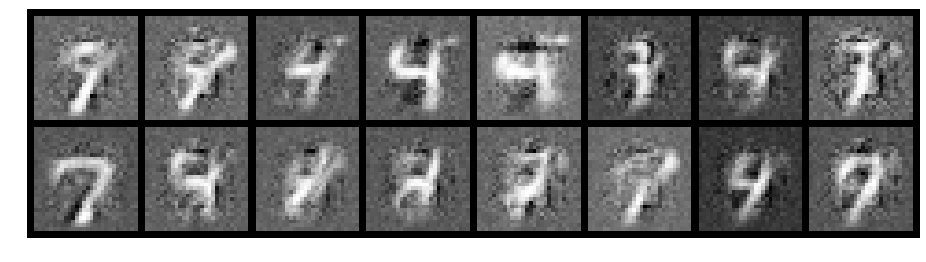

Epoch: [38/200], Batch Num: [0/600]
Discriminator Loss: 1.0221, Generator Loss: 1.1324
D(x): 0.7079, D(G(z)): 0.3964
Epoch: [38/200], Batch Num: [100/600]
Discriminator Loss: 0.9731, Generator Loss: 1.0652
D(x): 0.6721, D(G(z)): 0.3818


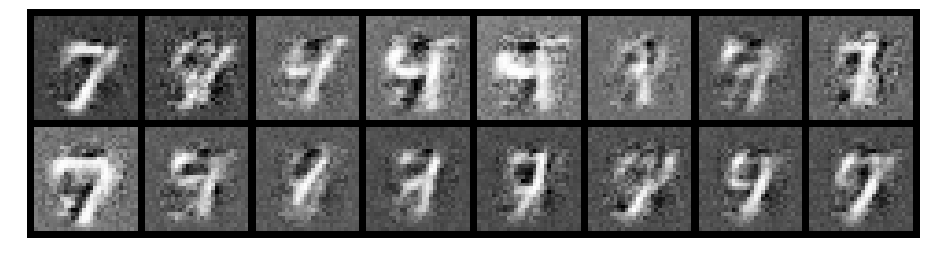

Epoch: [39/200], Batch Num: [0/600]
Discriminator Loss: 0.8015, Generator Loss: 1.1041
D(x): 0.8130, D(G(z)): 0.3933
Epoch: [39/200], Batch Num: [100/600]
Discriminator Loss: 1.2584, Generator Loss: 1.0219
D(x): 0.5766, D(G(z)): 0.4021


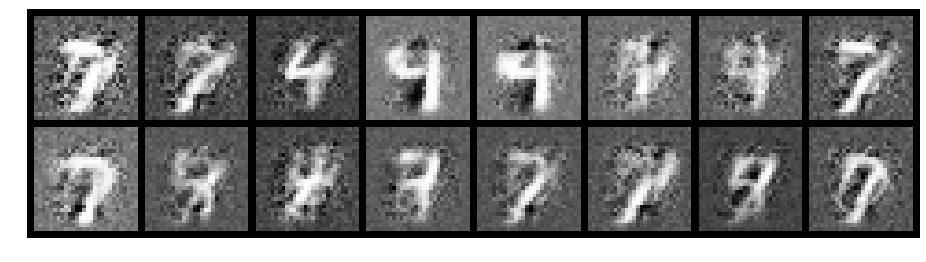

Epoch: [40/200], Batch Num: [0/600]
Discriminator Loss: 0.9778, Generator Loss: 1.6816
D(x): 0.7068, D(G(z)): 0.3287
Epoch: [40/200], Batch Num: [100/600]
Discriminator Loss: 1.1063, Generator Loss: 0.9420
D(x): 0.6938, D(G(z)): 0.4416


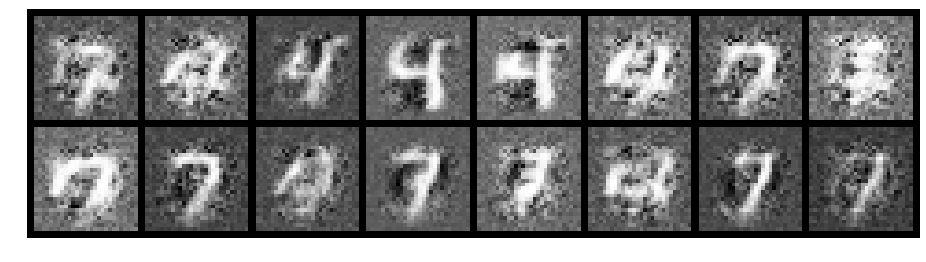

Epoch: [41/200], Batch Num: [0/600]
Discriminator Loss: 0.9114, Generator Loss: 1.1631
D(x): 0.7327, D(G(z)): 0.3777
Epoch: [41/200], Batch Num: [100/600]
Discriminator Loss: 0.8551, Generator Loss: 1.0965
D(x): 0.7283, D(G(z)): 0.3707


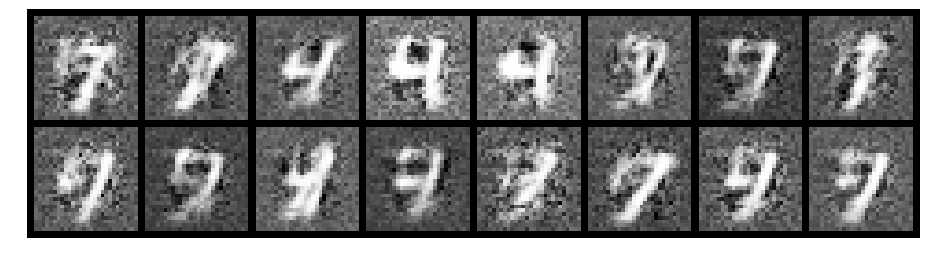

Epoch: [42/200], Batch Num: [0/600]
Discriminator Loss: 0.8193, Generator Loss: 1.4560
D(x): 0.7583, D(G(z)): 0.3451
Epoch: [42/200], Batch Num: [100/600]
Discriminator Loss: 0.7692, Generator Loss: 1.2321
D(x): 0.7765, D(G(z)): 0.3659


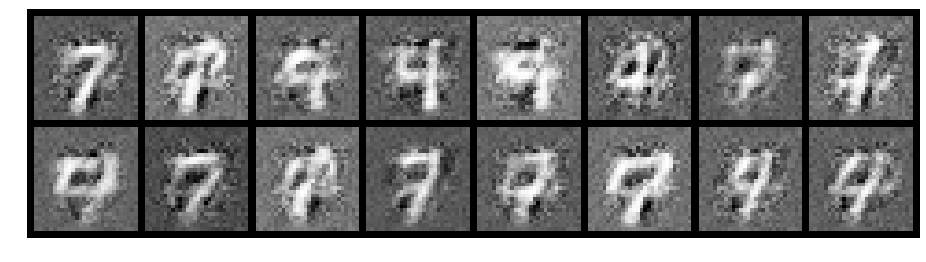

Epoch: [43/200], Batch Num: [0/600]
Discriminator Loss: 1.2299, Generator Loss: 1.0391
D(x): 0.5807, D(G(z)): 0.4148
Epoch: [43/200], Batch Num: [100/600]
Discriminator Loss: 1.1704, Generator Loss: 1.2435
D(x): 0.7022, D(G(z)): 0.4236


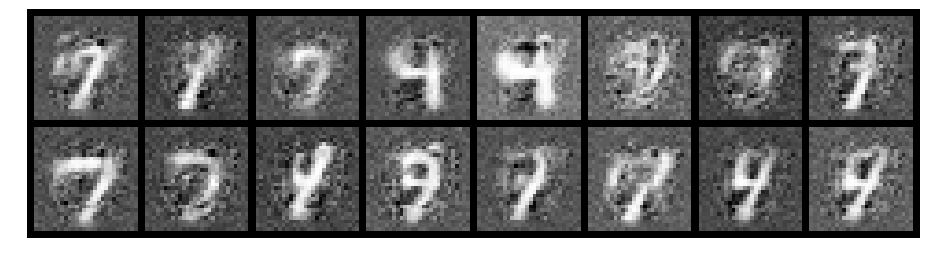

Epoch: [44/200], Batch Num: [0/600]
Discriminator Loss: 1.3566, Generator Loss: 1.2221
D(x): 0.5024, D(G(z)): 0.3528
Epoch: [44/200], Batch Num: [100/600]
Discriminator Loss: 1.2440, Generator Loss: 1.1972
D(x): 0.6203, D(G(z)): 0.3916


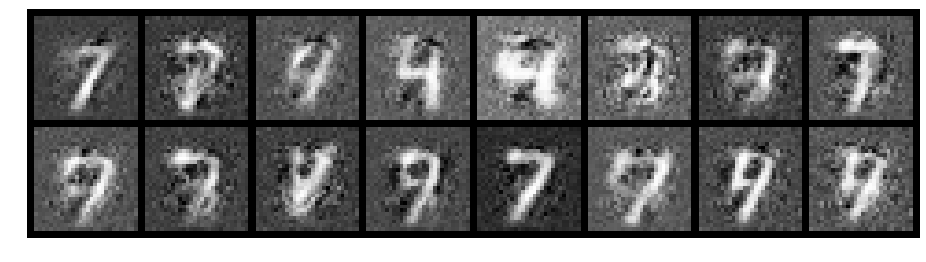

Epoch: [45/200], Batch Num: [0/600]
Discriminator Loss: 1.1515, Generator Loss: 0.9508
D(x): 0.6119, D(G(z)): 0.4335
Epoch: [45/200], Batch Num: [100/600]
Discriminator Loss: 0.8569, Generator Loss: 1.2934
D(x): 0.7204, D(G(z)): 0.3129


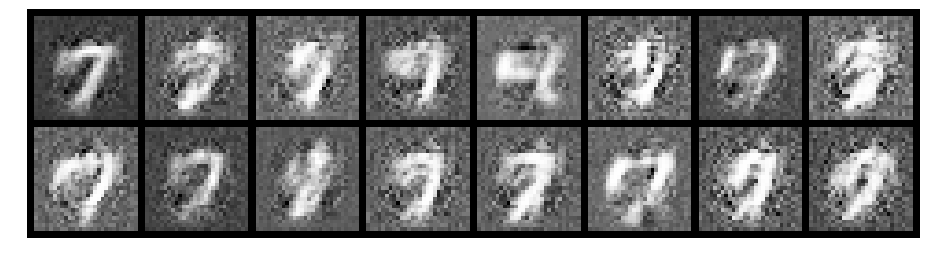

Epoch: [46/200], Batch Num: [0/600]
Discriminator Loss: 1.0663, Generator Loss: 1.5961
D(x): 0.6192, D(G(z)): 0.3155
Epoch: [46/200], Batch Num: [100/600]
Discriminator Loss: 1.2058, Generator Loss: 0.9109
D(x): 0.6173, D(G(z)): 0.4473


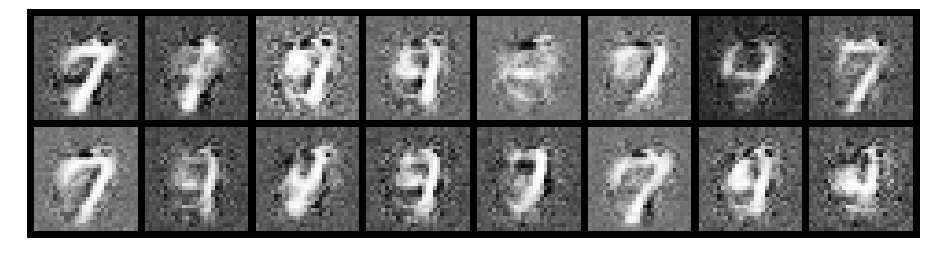

Epoch: [47/200], Batch Num: [0/600]
Discriminator Loss: 1.1321, Generator Loss: 1.2737
D(x): 0.6038, D(G(z)): 0.3319
Epoch: [47/200], Batch Num: [100/600]
Discriminator Loss: 0.3862, Generator Loss: 2.1030
D(x): 0.9321, D(G(z)): 0.2130


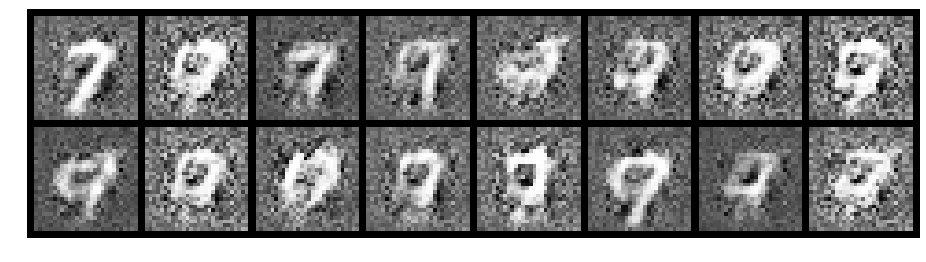

Epoch: [48/200], Batch Num: [0/600]
Discriminator Loss: 0.6777, Generator Loss: 1.3578
D(x): 0.7918, D(G(z)): 0.3297
Epoch: [48/200], Batch Num: [100/600]
Discriminator Loss: 1.1022, Generator Loss: 1.1114
D(x): 0.6115, D(G(z)): 0.3793


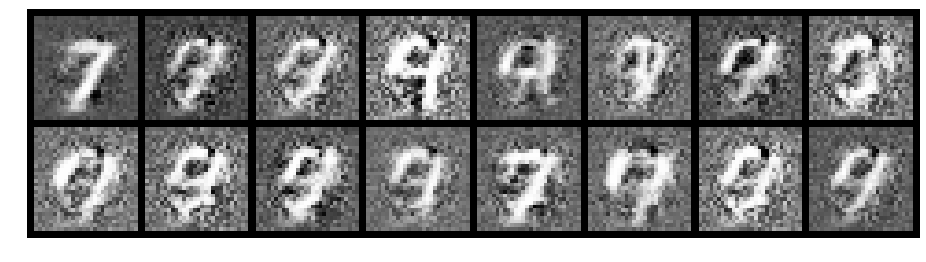

Epoch: [49/200], Batch Num: [0/600]
Discriminator Loss: 0.9216, Generator Loss: 1.7578
D(x): 0.7314, D(G(z)): 0.3524
Epoch: [49/200], Batch Num: [100/600]
Discriminator Loss: 1.0083, Generator Loss: 1.0823
D(x): 0.6736, D(G(z)): 0.3924


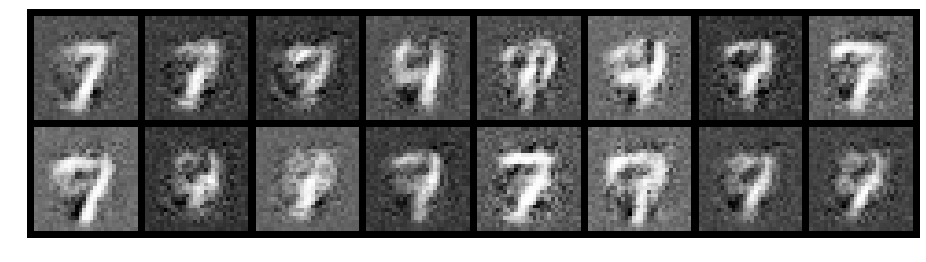

Epoch: [50/200], Batch Num: [0/600]
Discriminator Loss: 1.0230, Generator Loss: 1.0590
D(x): 0.6908, D(G(z)): 0.4102
Epoch: [50/200], Batch Num: [100/600]
Discriminator Loss: 1.1376, Generator Loss: 0.9795
D(x): 0.6052, D(G(z)): 0.3898


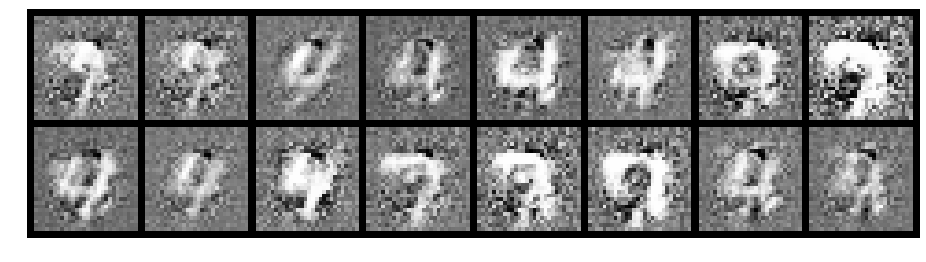

Epoch: [51/200], Batch Num: [0/600]
Discriminator Loss: 1.0773, Generator Loss: 1.4389
D(x): 0.6430, D(G(z)): 0.3593
Epoch: [51/200], Batch Num: [100/600]
Discriminator Loss: 0.9048, Generator Loss: 1.0592
D(x): 0.6912, D(G(z)): 0.3730


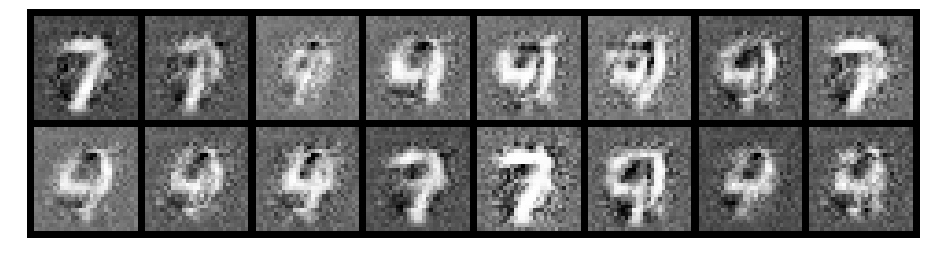

Epoch: [52/200], Batch Num: [0/600]
Discriminator Loss: 1.0211, Generator Loss: 1.3252
D(x): 0.6531, D(G(z)): 0.3297
Epoch: [52/200], Batch Num: [100/600]
Discriminator Loss: 1.0982, Generator Loss: 1.4404
D(x): 0.6503, D(G(z)): 0.3691


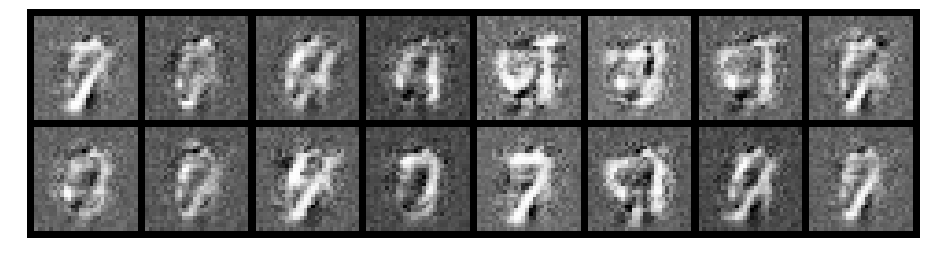

Epoch: [53/200], Batch Num: [0/600]
Discriminator Loss: 1.0681, Generator Loss: 1.0611
D(x): 0.6335, D(G(z)): 0.3828
Epoch: [53/200], Batch Num: [100/600]
Discriminator Loss: 1.0499, Generator Loss: 1.3785
D(x): 0.6316, D(G(z)): 0.3203


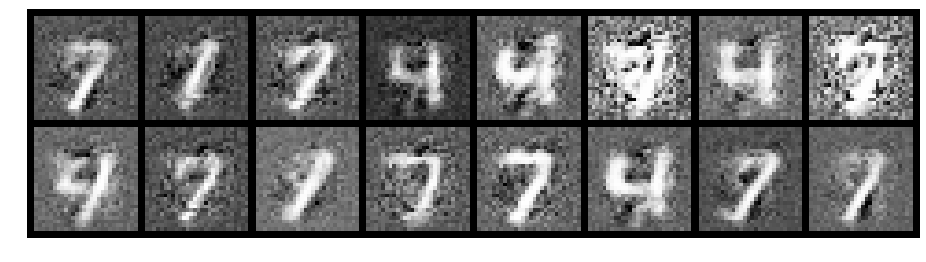

Epoch: [54/200], Batch Num: [0/600]
Discriminator Loss: 1.2972, Generator Loss: 1.3120
D(x): 0.5657, D(G(z)): 0.3633
Epoch: [54/200], Batch Num: [100/600]
Discriminator Loss: 0.9628, Generator Loss: 1.0703
D(x): 0.7076, D(G(z)): 0.3842


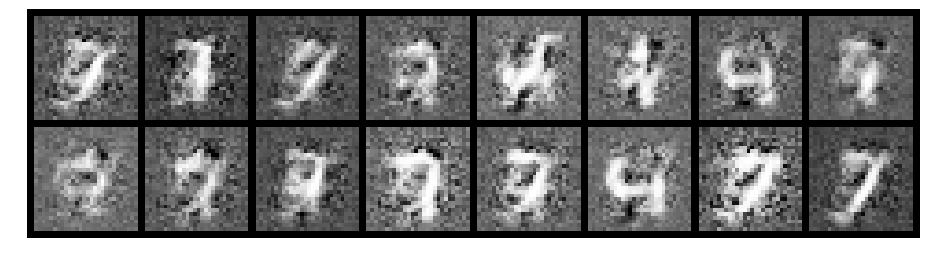

Epoch: [55/200], Batch Num: [0/600]
Discriminator Loss: 0.9024, Generator Loss: 1.7433
D(x): 0.6443, D(G(z)): 0.2804
Epoch: [55/200], Batch Num: [100/600]
Discriminator Loss: 1.1023, Generator Loss: 1.5161
D(x): 0.6838, D(G(z)): 0.3586


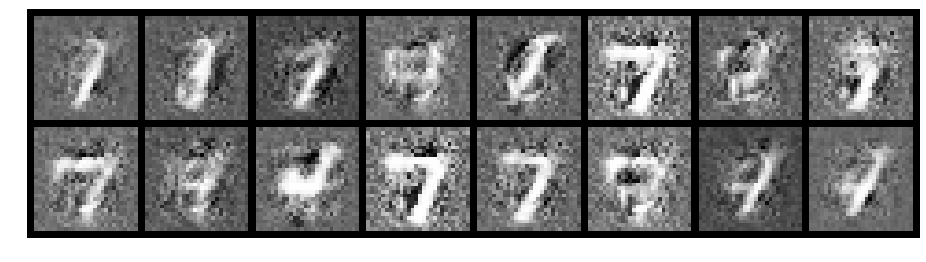

Epoch: [56/200], Batch Num: [0/600]
Discriminator Loss: 0.9590, Generator Loss: 1.3360
D(x): 0.6621, D(G(z)): 0.3065
Epoch: [56/200], Batch Num: [100/600]
Discriminator Loss: 1.1800, Generator Loss: 1.5438
D(x): 0.6305, D(G(z)): 0.3229


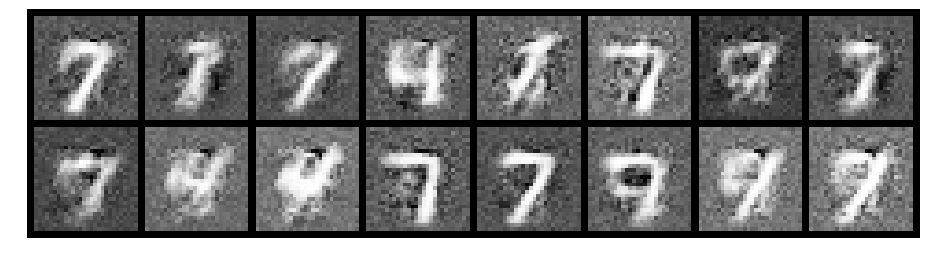

Epoch: [57/200], Batch Num: [0/600]
Discriminator Loss: 1.5074, Generator Loss: 1.5222
D(x): 0.5761, D(G(z)): 0.4227
Epoch: [57/200], Batch Num: [100/600]
Discriminator Loss: 1.0018, Generator Loss: 0.9662
D(x): 0.6729, D(G(z)): 0.4148


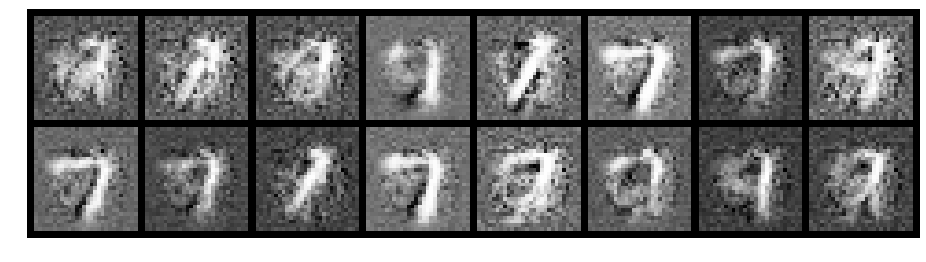

Epoch: [58/200], Batch Num: [0/600]
Discriminator Loss: 0.7904, Generator Loss: 1.4915
D(x): 0.7524, D(G(z)): 0.3240
Epoch: [58/200], Batch Num: [100/600]
Discriminator Loss: 0.8467, Generator Loss: 1.2451
D(x): 0.7153, D(G(z)): 0.3357


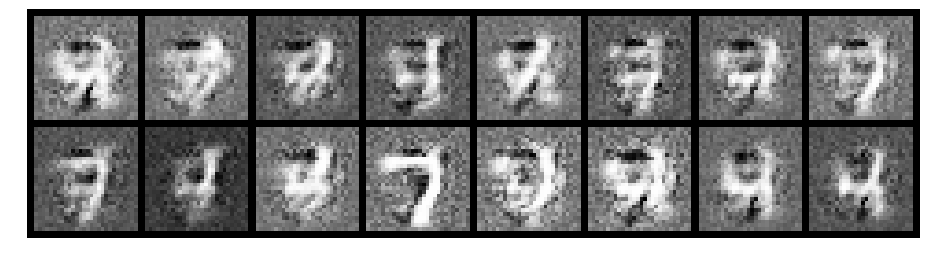

Epoch: [59/200], Batch Num: [0/600]
Discriminator Loss: 1.1734, Generator Loss: 1.3949
D(x): 0.6364, D(G(z)): 0.3521
Epoch: [59/200], Batch Num: [100/600]
Discriminator Loss: 0.9263, Generator Loss: 2.3543
D(x): 0.6234, D(G(z)): 0.2510


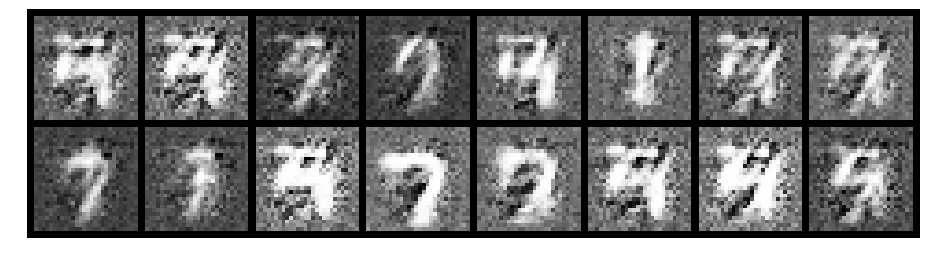

Epoch: [60/200], Batch Num: [0/600]
Discriminator Loss: 0.8254, Generator Loss: 1.8145
D(x): 0.7206, D(G(z)): 0.2667
Epoch: [60/200], Batch Num: [100/600]
Discriminator Loss: 1.1754, Generator Loss: 0.9801
D(x): 0.5947, D(G(z)): 0.4210


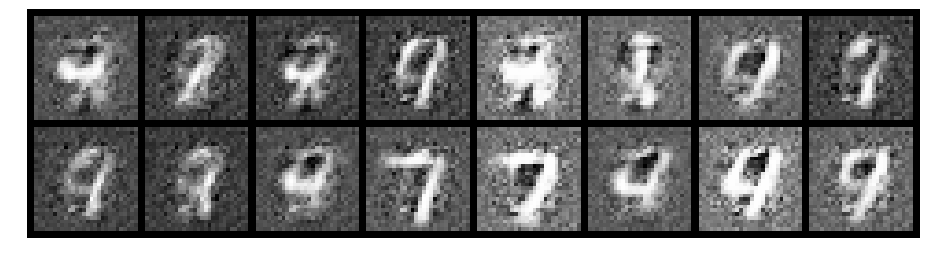

Epoch: [61/200], Batch Num: [0/600]
Discriminator Loss: 0.9959, Generator Loss: 1.4274
D(x): 0.7151, D(G(z)): 0.3591
Epoch: [61/200], Batch Num: [100/600]
Discriminator Loss: 0.7401, Generator Loss: 1.5773
D(x): 0.7430, D(G(z)): 0.2733


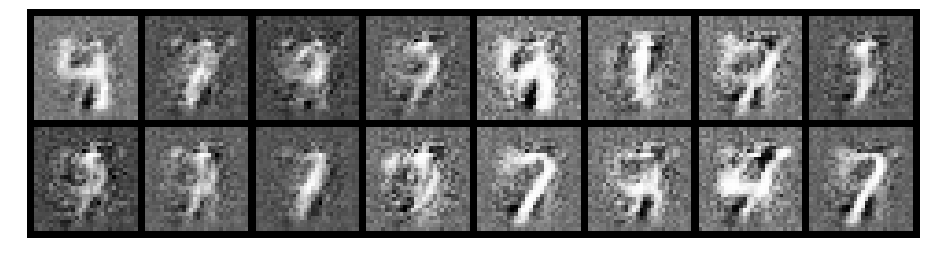

Epoch: [62/200], Batch Num: [0/600]
Discriminator Loss: 1.1831, Generator Loss: 0.9401
D(x): 0.5295, D(G(z)): 0.3849
Epoch: [62/200], Batch Num: [100/600]
Discriminator Loss: 1.1534, Generator Loss: 1.3590
D(x): 0.6106, D(G(z)): 0.3122


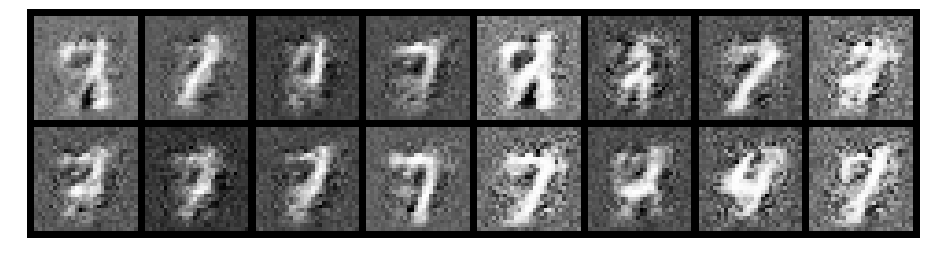

Epoch: [63/200], Batch Num: [0/600]
Discriminator Loss: 1.0458, Generator Loss: 1.2313
D(x): 0.6654, D(G(z)): 0.3753
Epoch: [63/200], Batch Num: [100/600]
Discriminator Loss: 1.0906, Generator Loss: 1.0502
D(x): 0.6263, D(G(z)): 0.3932


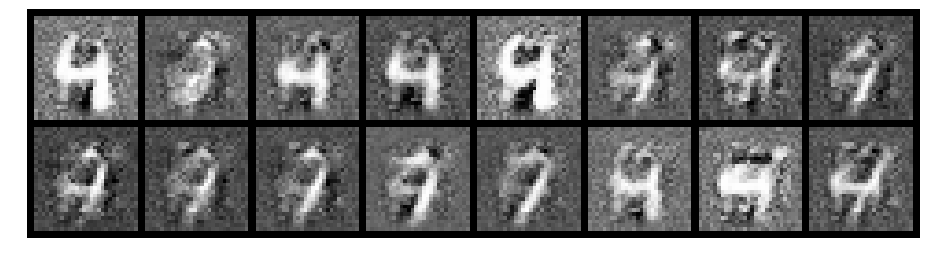

Epoch: [64/200], Batch Num: [0/600]
Discriminator Loss: 1.0228, Generator Loss: 1.1278
D(x): 0.7032, D(G(z)): 0.3687
Epoch: [64/200], Batch Num: [100/600]
Discriminator Loss: 0.9202, Generator Loss: 1.3434
D(x): 0.6827, D(G(z)): 0.3166


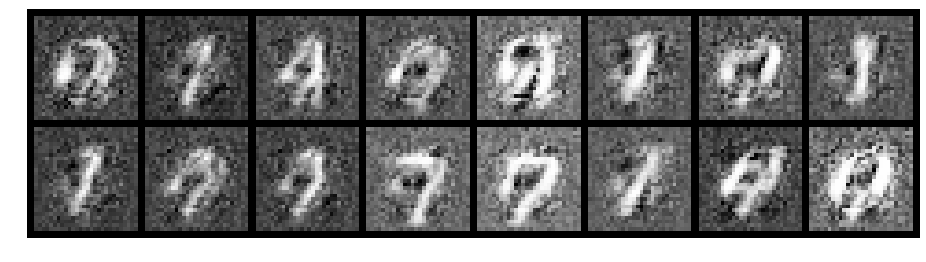

Epoch: [65/200], Batch Num: [0/600]
Discriminator Loss: 0.9960, Generator Loss: 1.0935
D(x): 0.6564, D(G(z)): 0.3776
Epoch: [65/200], Batch Num: [100/600]
Discriminator Loss: 1.5003, Generator Loss: 2.0040
D(x): 0.5711, D(G(z)): 0.3152


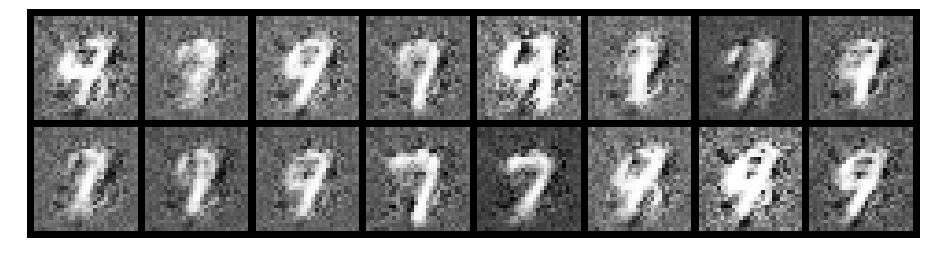

Epoch: [66/200], Batch Num: [0/600]
Discriminator Loss: 0.9818, Generator Loss: 1.3100
D(x): 0.6703, D(G(z)): 0.3378
Epoch: [66/200], Batch Num: [100/600]
Discriminator Loss: 1.0643, Generator Loss: 1.3054
D(x): 0.6385, D(G(z)): 0.3449


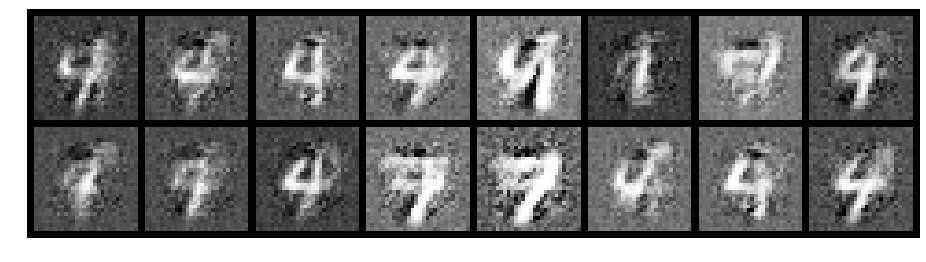

Epoch: [67/200], Batch Num: [0/600]
Discriminator Loss: 0.8158, Generator Loss: 1.2887
D(x): 0.7754, D(G(z)): 0.3374
Epoch: [67/200], Batch Num: [100/600]
Discriminator Loss: 0.8892, Generator Loss: 1.2014
D(x): 0.6884, D(G(z)): 0.3279


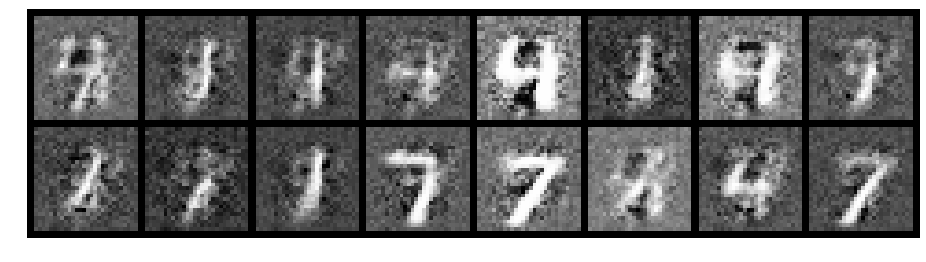

Epoch: [68/200], Batch Num: [0/600]
Discriminator Loss: 0.8527, Generator Loss: 1.2799
D(x): 0.8088, D(G(z)): 0.3815
Epoch: [68/200], Batch Num: [100/600]
Discriminator Loss: 0.9163, Generator Loss: 1.2919
D(x): 0.7445, D(G(z)): 0.3587


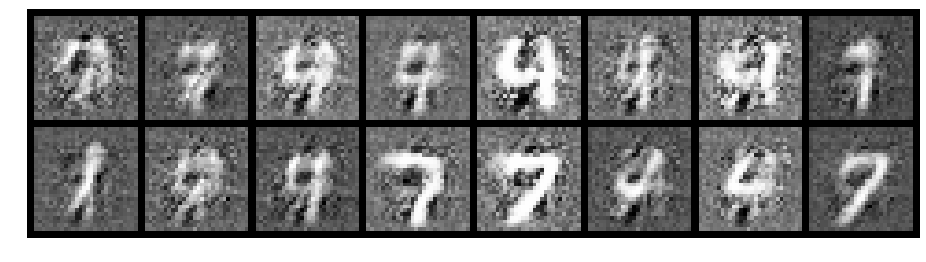

Epoch: [69/200], Batch Num: [0/600]
Discriminator Loss: 1.1953, Generator Loss: 1.1701
D(x): 0.5525, D(G(z)): 0.3532
Epoch: [69/200], Batch Num: [100/600]
Discriminator Loss: 0.9683, Generator Loss: 1.2905
D(x): 0.7120, D(G(z)): 0.3591


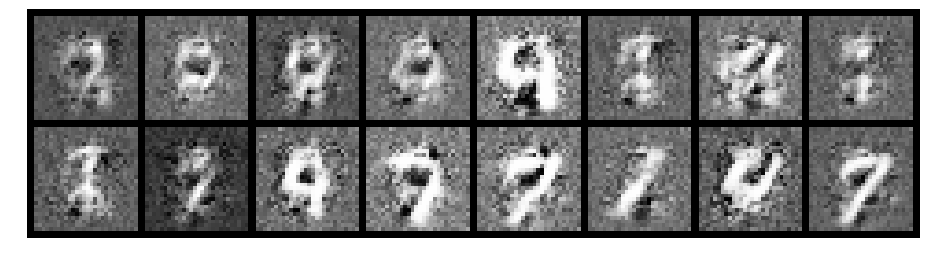

Epoch: [70/200], Batch Num: [0/600]
Discriminator Loss: 1.1473, Generator Loss: 1.0363
D(x): 0.6205, D(G(z)): 0.4031
Epoch: [70/200], Batch Num: [100/600]
Discriminator Loss: 0.6406, Generator Loss: 1.9433
D(x): 0.8813, D(G(z)): 0.2727


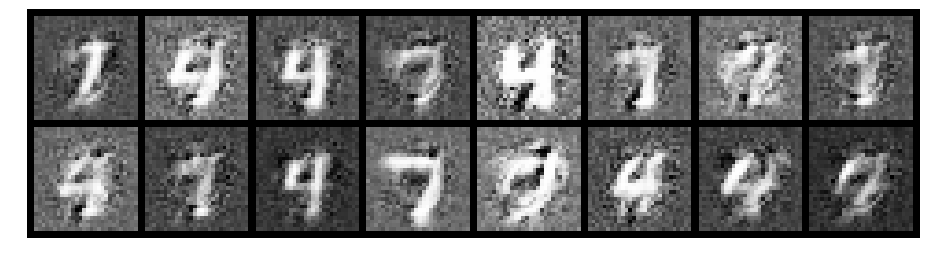

Epoch: [71/200], Batch Num: [0/600]
Discriminator Loss: 1.2528, Generator Loss: 1.2083
D(x): 0.5770, D(G(z)): 0.3401
Epoch: [71/200], Batch Num: [100/600]
Discriminator Loss: 1.0369, Generator Loss: 1.0924
D(x): 0.6225, D(G(z)): 0.3434


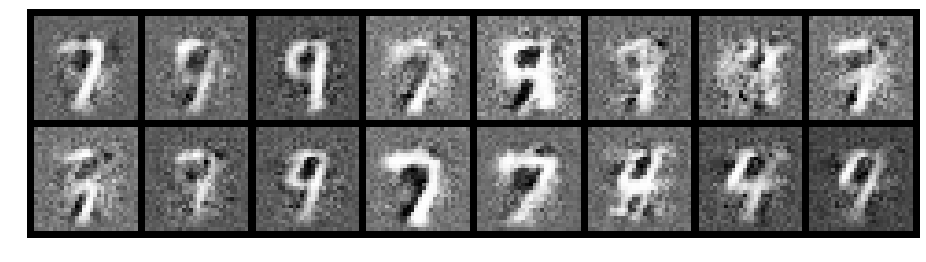

Epoch: [72/200], Batch Num: [0/600]
Discriminator Loss: 0.9754, Generator Loss: 1.4325
D(x): 0.7490, D(G(z)): 0.3726
Epoch: [72/200], Batch Num: [100/600]
Discriminator Loss: 1.4136, Generator Loss: 1.3184
D(x): 0.5427, D(G(z)): 0.3399


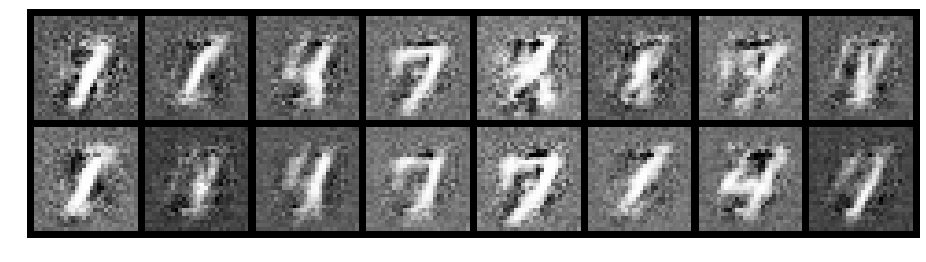

Epoch: [73/200], Batch Num: [0/600]
Discriminator Loss: 0.8397, Generator Loss: 1.1096
D(x): 0.7541, D(G(z)): 0.3624
Epoch: [73/200], Batch Num: [100/600]
Discriminator Loss: 1.0382, Generator Loss: 1.2086
D(x): 0.6785, D(G(z)): 0.3698


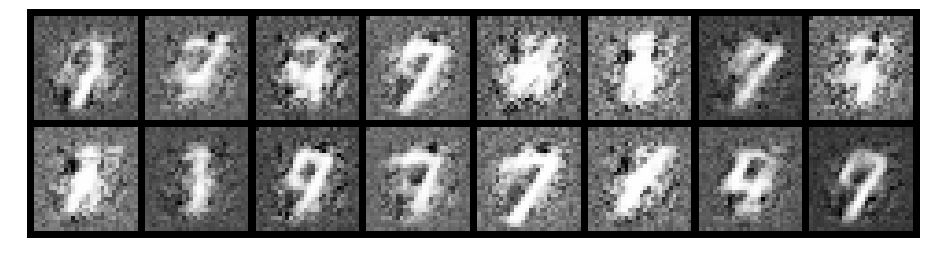

Epoch: [74/200], Batch Num: [0/600]
Discriminator Loss: 1.4058, Generator Loss: 1.4221
D(x): 0.7220, D(G(z)): 0.4804
Epoch: [74/200], Batch Num: [100/600]
Discriminator Loss: 1.1123, Generator Loss: 1.2962
D(x): 0.6793, D(G(z)): 0.3566


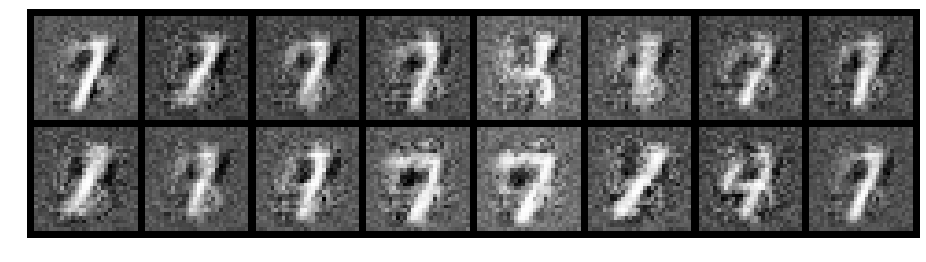

Epoch: [75/200], Batch Num: [0/600]
Discriminator Loss: 1.1151, Generator Loss: 0.8442
D(x): 0.6591, D(G(z)): 0.4476
Epoch: [75/200], Batch Num: [100/600]
Discriminator Loss: 1.1853, Generator Loss: 1.3895
D(x): 0.6517, D(G(z)): 0.3519


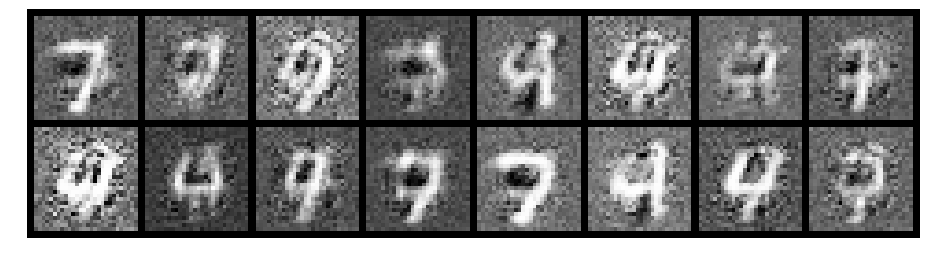

Epoch: [76/200], Batch Num: [0/600]
Discriminator Loss: 0.9763, Generator Loss: 1.2554
D(x): 0.6685, D(G(z)): 0.3352
Epoch: [76/200], Batch Num: [100/600]
Discriminator Loss: 0.9197, Generator Loss: 1.1688
D(x): 0.7240, D(G(z)): 0.3754


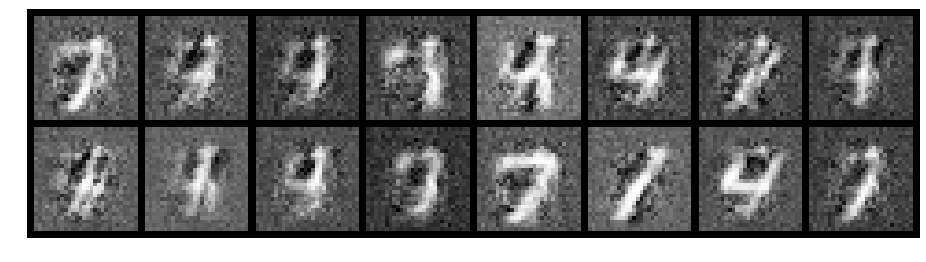

Epoch: [77/200], Batch Num: [0/600]
Discriminator Loss: 1.2479, Generator Loss: 0.9022
D(x): 0.5993, D(G(z)): 0.4689
Epoch: [77/200], Batch Num: [100/600]
Discriminator Loss: 0.9453, Generator Loss: 1.5909
D(x): 0.7442, D(G(z)): 0.3133


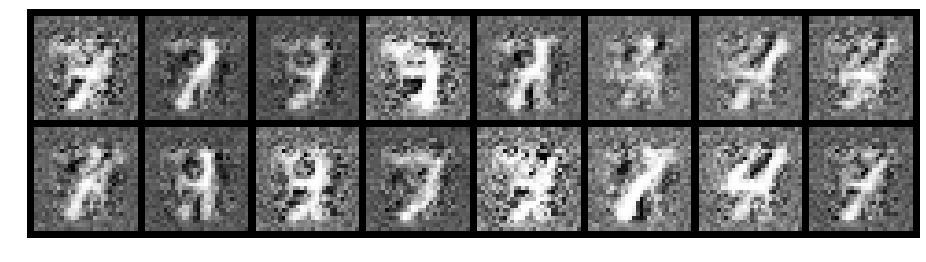

Epoch: [78/200], Batch Num: [0/600]
Discriminator Loss: 1.0363, Generator Loss: 1.3812
D(x): 0.6385, D(G(z)): 0.3365
Epoch: [78/200], Batch Num: [100/600]
Discriminator Loss: 0.8238, Generator Loss: 1.5619
D(x): 0.7317, D(G(z)): 0.2862


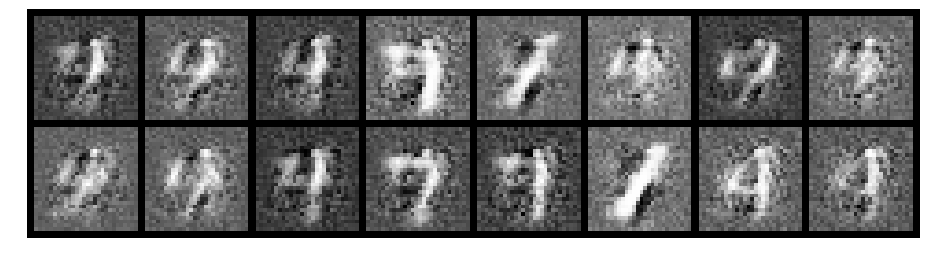

Epoch: [79/200], Batch Num: [0/600]
Discriminator Loss: 0.9561, Generator Loss: 1.1638
D(x): 0.7176, D(G(z)): 0.3973
Epoch: [79/200], Batch Num: [100/600]
Discriminator Loss: 1.0346, Generator Loss: 1.2654
D(x): 0.6789, D(G(z)): 0.3618


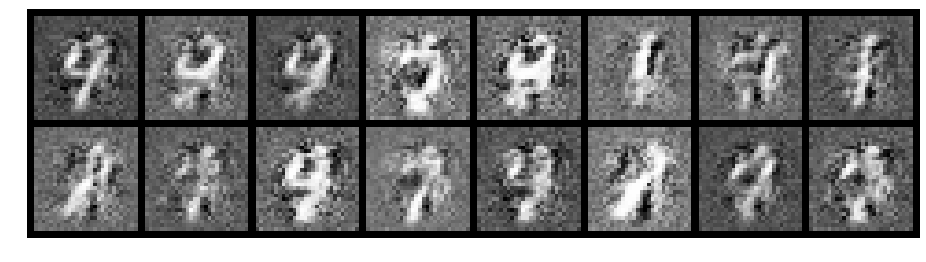

Epoch: [80/200], Batch Num: [0/600]
Discriminator Loss: 1.2419, Generator Loss: 1.1524
D(x): 0.5672, D(G(z)): 0.3779
Epoch: [80/200], Batch Num: [100/600]
Discriminator Loss: 0.8100, Generator Loss: 1.6847
D(x): 0.7643, D(G(z)): 0.2853


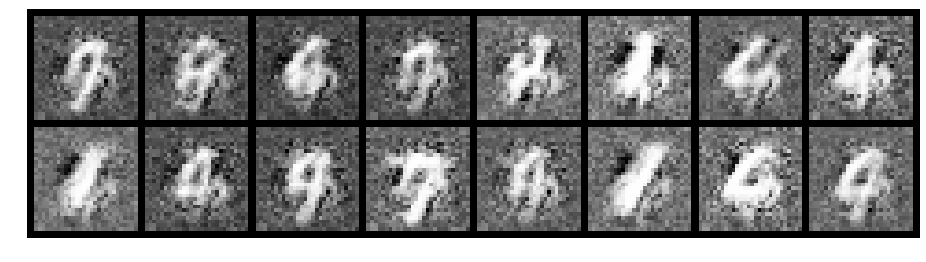

Epoch: [81/200], Batch Num: [0/600]
Discriminator Loss: 0.8322, Generator Loss: 1.5663
D(x): 0.7226, D(G(z)): 0.2904
Epoch: [81/200], Batch Num: [100/600]
Discriminator Loss: 1.0872, Generator Loss: 2.0102
D(x): 0.6901, D(G(z)): 0.3011


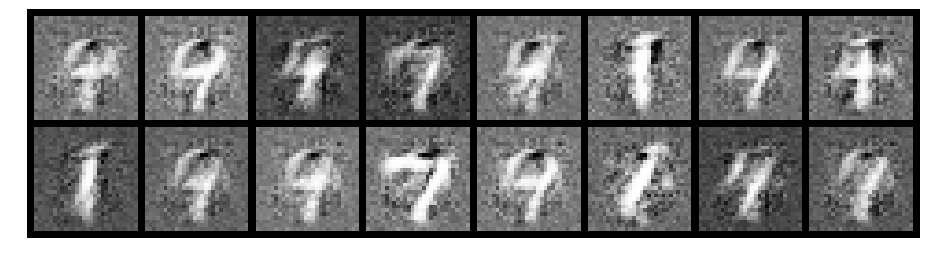

Epoch: [82/200], Batch Num: [0/600]
Discriminator Loss: 1.0263, Generator Loss: 1.0908
D(x): 0.6374, D(G(z)): 0.3581
Epoch: [82/200], Batch Num: [100/600]
Discriminator Loss: 1.1332, Generator Loss: 1.2390
D(x): 0.6526, D(G(z)): 0.3523


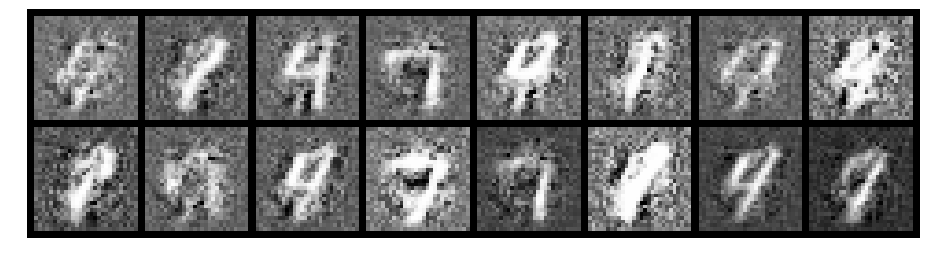

Epoch: [83/200], Batch Num: [0/600]
Discriminator Loss: 1.3497, Generator Loss: 1.3349
D(x): 0.5383, D(G(z)): 0.3374
Epoch: [83/200], Batch Num: [100/600]
Discriminator Loss: 0.8978, Generator Loss: 1.3263
D(x): 0.7836, D(G(z)): 0.3771


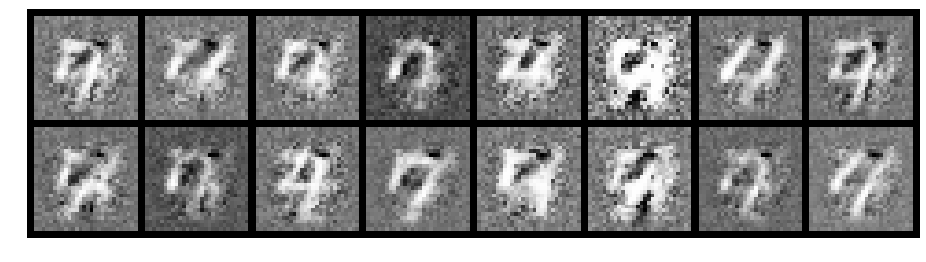

Epoch: [84/200], Batch Num: [0/600]
Discriminator Loss: 0.8131, Generator Loss: 1.5436
D(x): 0.7302, D(G(z)): 0.2987
Epoch: [84/200], Batch Num: [100/600]
Discriminator Loss: 1.0874, Generator Loss: 1.6044
D(x): 0.6905, D(G(z)): 0.3104


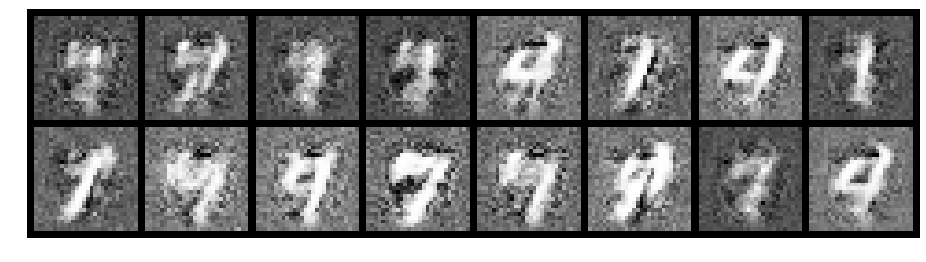

Epoch: [85/200], Batch Num: [0/600]
Discriminator Loss: 0.8677, Generator Loss: 1.5564
D(x): 0.7601, D(G(z)): 0.3281
Epoch: [85/200], Batch Num: [100/600]
Discriminator Loss: 0.9880, Generator Loss: 1.2003
D(x): 0.6985, D(G(z)): 0.3665


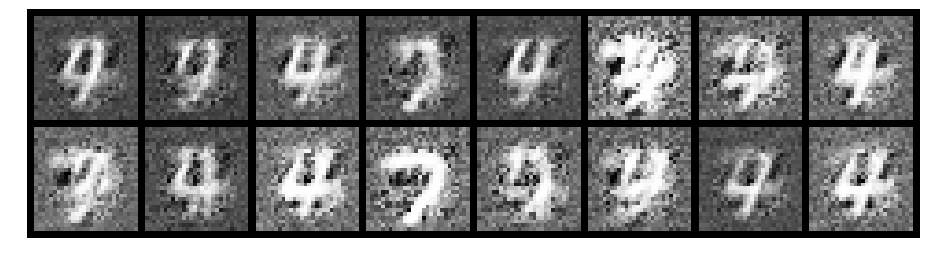

Epoch: [86/200], Batch Num: [0/600]
Discriminator Loss: 0.8649, Generator Loss: 1.2923
D(x): 0.7370, D(G(z)): 0.3299
Epoch: [86/200], Batch Num: [100/600]
Discriminator Loss: 0.7320, Generator Loss: 1.2955
D(x): 0.7904, D(G(z)): 0.3283


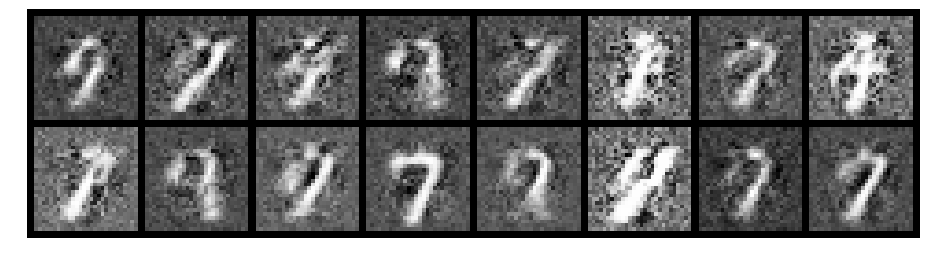

Epoch: [87/200], Batch Num: [0/600]
Discriminator Loss: 0.9745, Generator Loss: 1.3790
D(x): 0.6879, D(G(z)): 0.3559
Epoch: [87/200], Batch Num: [100/600]
Discriminator Loss: 0.9316, Generator Loss: 1.2999
D(x): 0.7185, D(G(z)): 0.3557


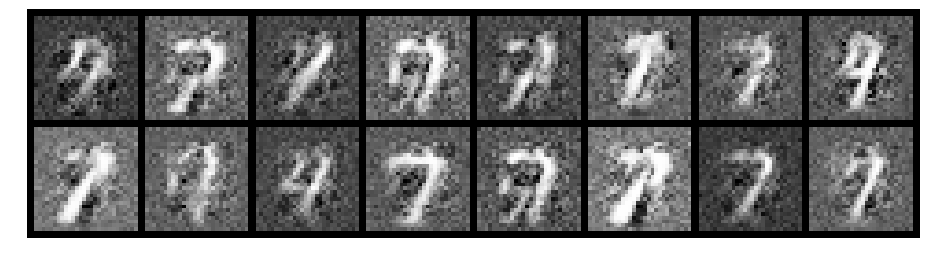

Epoch: [88/200], Batch Num: [0/600]
Discriminator Loss: 1.0522, Generator Loss: 1.1232
D(x): 0.6798, D(G(z)): 0.3656
Epoch: [88/200], Batch Num: [100/600]
Discriminator Loss: 0.8588, Generator Loss: 1.5520
D(x): 0.7106, D(G(z)): 0.3007


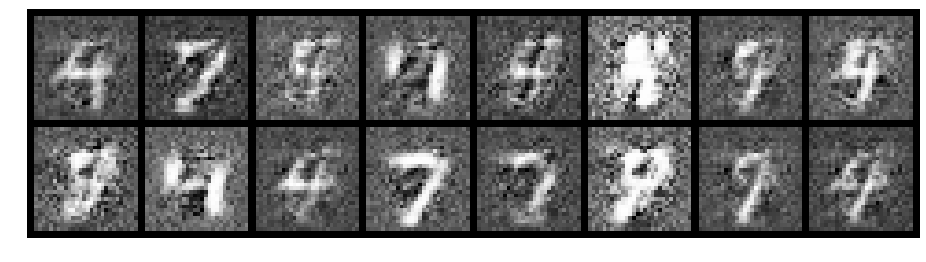

Epoch: [89/200], Batch Num: [0/600]
Discriminator Loss: 0.8705, Generator Loss: 1.2858
D(x): 0.7868, D(G(z)): 0.3812
Epoch: [89/200], Batch Num: [100/600]
Discriminator Loss: 1.0527, Generator Loss: 1.6188
D(x): 0.6572, D(G(z)): 0.2986


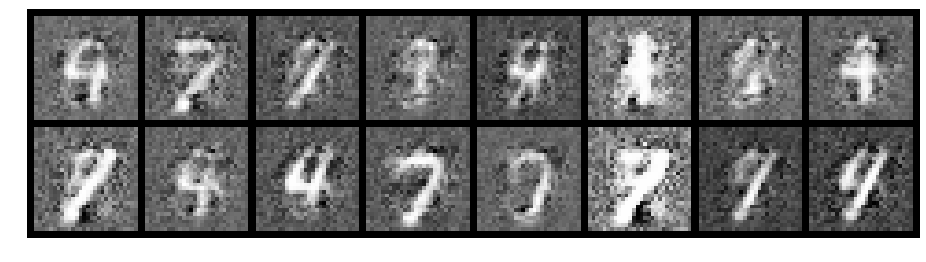

Epoch: [90/200], Batch Num: [0/600]
Discriminator Loss: 1.1160, Generator Loss: 1.0330
D(x): 0.6494, D(G(z)): 0.3983
Epoch: [90/200], Batch Num: [100/600]
Discriminator Loss: 1.1126, Generator Loss: 1.4048
D(x): 0.6465, D(G(z)): 0.3448


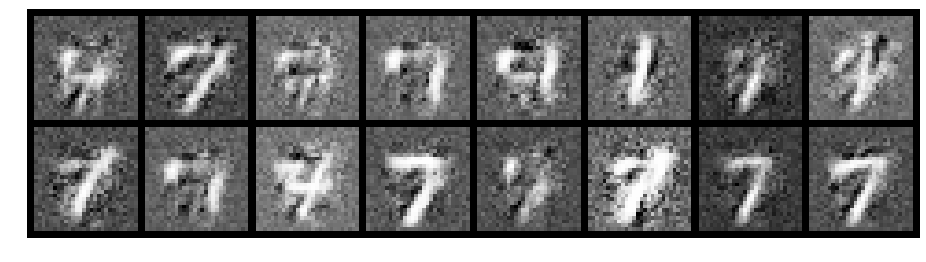

Epoch: [91/200], Batch Num: [0/600]
Discriminator Loss: 0.7481, Generator Loss: 1.2715
D(x): 0.7857, D(G(z)): 0.3412
Epoch: [91/200], Batch Num: [100/600]
Discriminator Loss: 0.7663, Generator Loss: 1.6150
D(x): 0.7453, D(G(z)): 0.2686


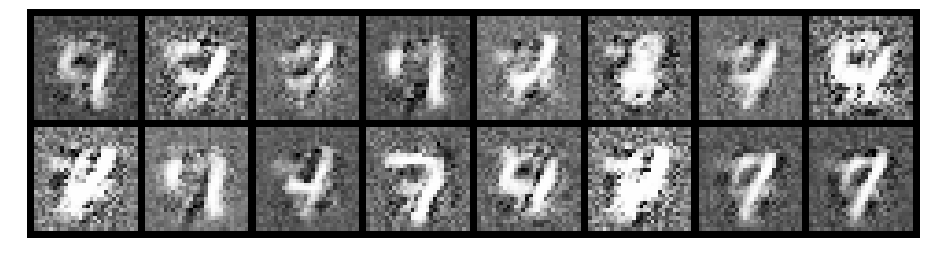

Epoch: [92/200], Batch Num: [0/600]
Discriminator Loss: 0.9336, Generator Loss: 1.2803
D(x): 0.6755, D(G(z)): 0.3428
Epoch: [92/200], Batch Num: [100/600]
Discriminator Loss: 0.8171, Generator Loss: 1.4299
D(x): 0.8141, D(G(z)): 0.3300


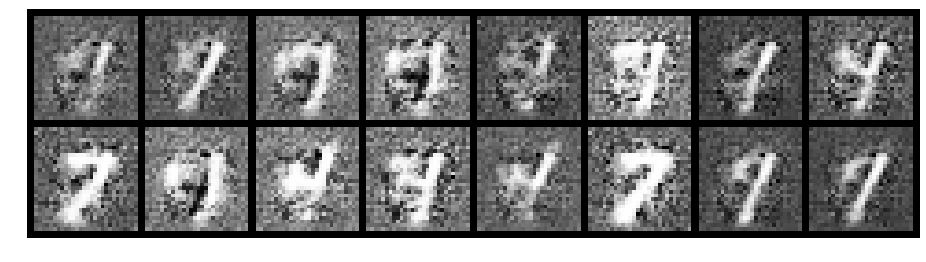

Epoch: [93/200], Batch Num: [0/600]
Discriminator Loss: 0.8643, Generator Loss: 1.9229
D(x): 0.7288, D(G(z)): 0.2407
Epoch: [93/200], Batch Num: [100/600]
Discriminator Loss: 0.9486, Generator Loss: 1.3536
D(x): 0.6961, D(G(z)): 0.3050


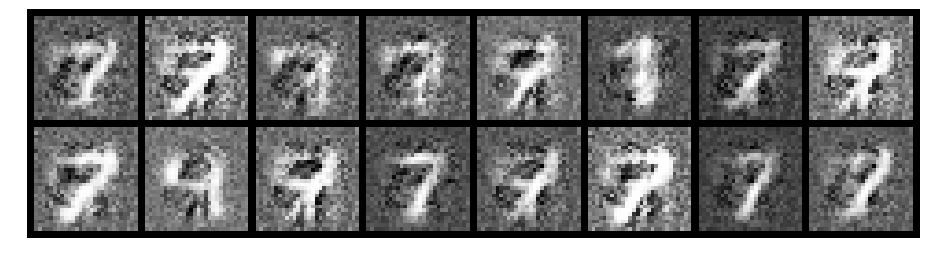

Epoch: [94/200], Batch Num: [0/600]
Discriminator Loss: 1.1034, Generator Loss: 1.3556
D(x): 0.6358, D(G(z)): 0.3419
Epoch: [94/200], Batch Num: [100/600]
Discriminator Loss: 0.8335, Generator Loss: 1.5638
D(x): 0.7183, D(G(z)): 0.3019


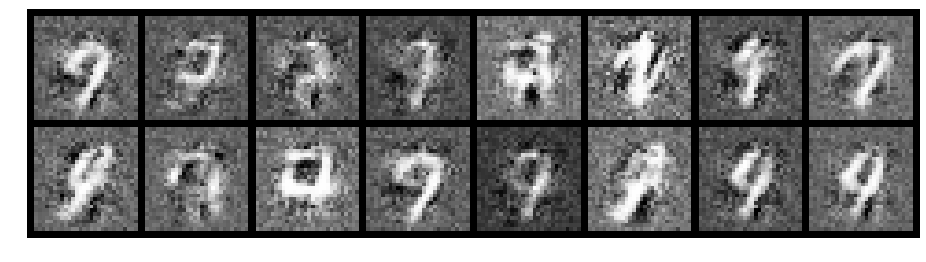

Epoch: [95/200], Batch Num: [0/600]
Discriminator Loss: 0.9641, Generator Loss: 1.6230
D(x): 0.6910, D(G(z)): 0.3065
Epoch: [95/200], Batch Num: [100/600]
Discriminator Loss: 0.7303, Generator Loss: 1.5274
D(x): 0.7214, D(G(z)): 0.2336


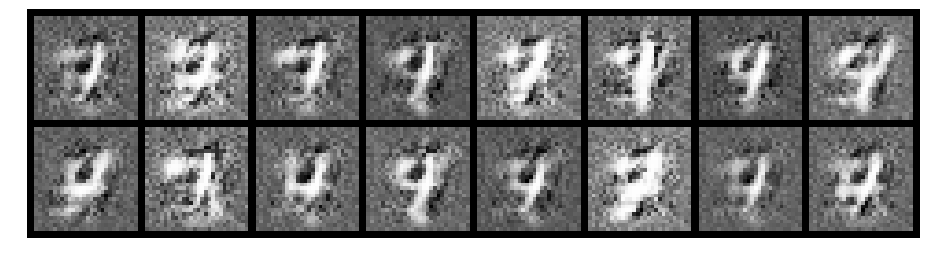

Epoch: [96/200], Batch Num: [0/600]
Discriminator Loss: 1.0040, Generator Loss: 1.7757
D(x): 0.6602, D(G(z)): 0.2717
Epoch: [96/200], Batch Num: [100/600]
Discriminator Loss: 1.1317, Generator Loss: 1.2144
D(x): 0.5745, D(G(z)): 0.3465


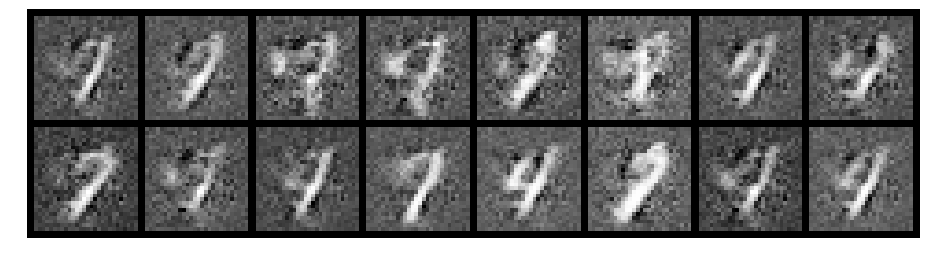

Epoch: [97/200], Batch Num: [0/600]
Discriminator Loss: 1.0277, Generator Loss: 1.4787
D(x): 0.6674, D(G(z)): 0.3265
Epoch: [97/200], Batch Num: [100/600]
Discriminator Loss: 0.6208, Generator Loss: 2.0747
D(x): 0.7893, D(G(z)): 0.2067


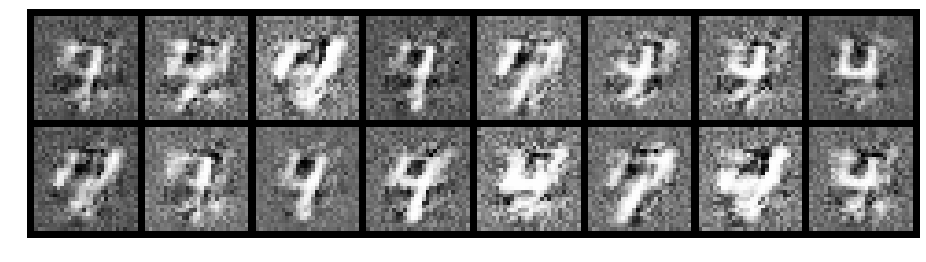

Epoch: [98/200], Batch Num: [0/600]
Discriminator Loss: 0.9855, Generator Loss: 1.2561
D(x): 0.6314, D(G(z)): 0.3236
Epoch: [98/200], Batch Num: [100/600]
Discriminator Loss: 1.0858, Generator Loss: 1.6565
D(x): 0.6333, D(G(z)): 0.2617


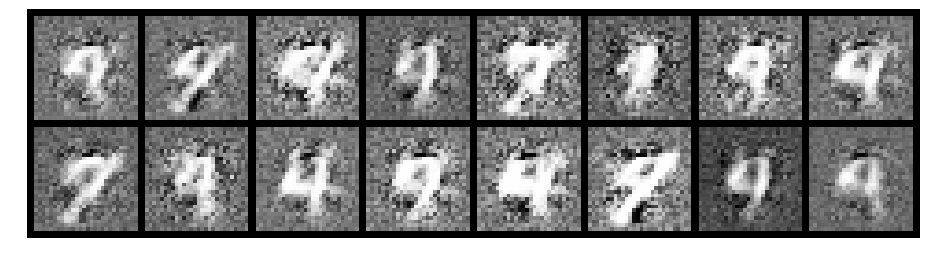

Epoch: [99/200], Batch Num: [0/600]
Discriminator Loss: 0.9324, Generator Loss: 1.6008
D(x): 0.6517, D(G(z)): 0.2789
Epoch: [99/200], Batch Num: [100/600]
Discriminator Loss: 0.9928, Generator Loss: 1.8655
D(x): 0.6800, D(G(z)): 0.2533


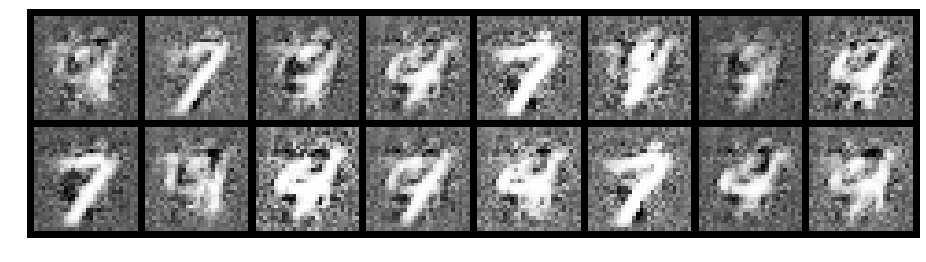

Epoch: [100/200], Batch Num: [0/600]
Discriminator Loss: 0.6472, Generator Loss: 2.0345
D(x): 0.8410, D(G(z)): 0.2519
Epoch: [100/200], Batch Num: [100/600]
Discriminator Loss: 0.7359, Generator Loss: 1.4879
D(x): 0.7750, D(G(z)): 0.2942


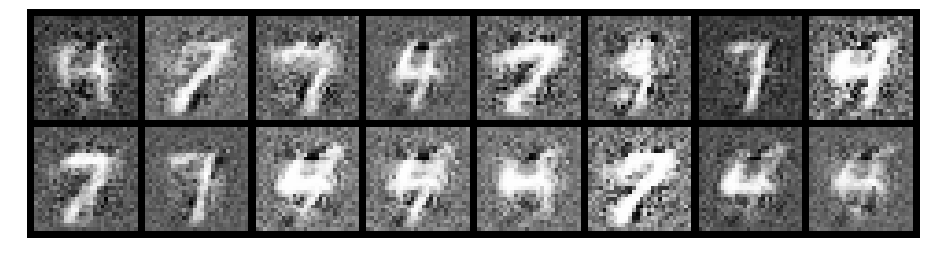

Epoch: [101/200], Batch Num: [0/600]
Discriminator Loss: 0.7214, Generator Loss: 2.0424
D(x): 0.7995, D(G(z)): 0.2551
Epoch: [101/200], Batch Num: [100/600]
Discriminator Loss: 0.5608, Generator Loss: 1.9624
D(x): 0.8232, D(G(z)): 0.2211


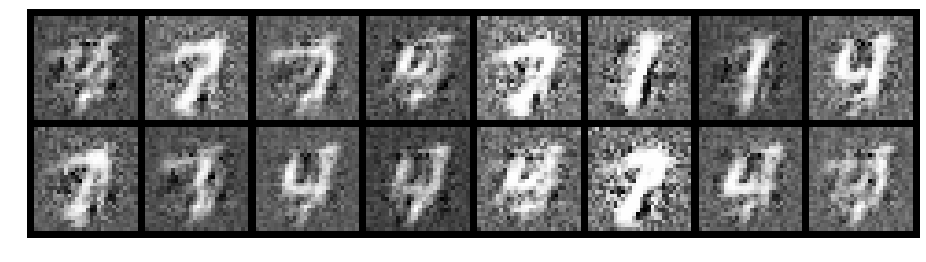

Epoch: [102/200], Batch Num: [0/600]
Discriminator Loss: 0.9702, Generator Loss: 1.8015
D(x): 0.6588, D(G(z)): 0.2730
Epoch: [102/200], Batch Num: [100/600]
Discriminator Loss: 0.9651, Generator Loss: 1.5825
D(x): 0.6977, D(G(z)): 0.3019


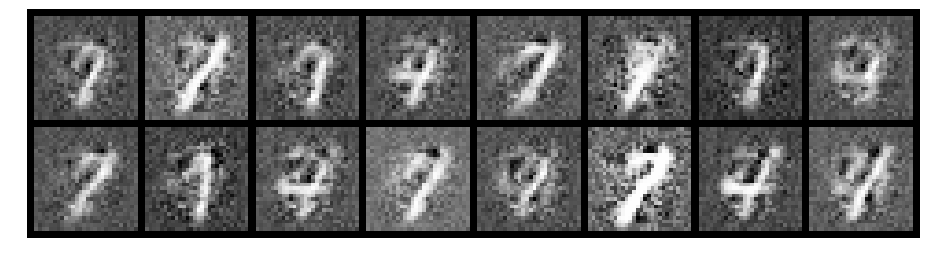

Epoch: [103/200], Batch Num: [0/600]
Discriminator Loss: 0.8512, Generator Loss: 1.6423
D(x): 0.6817, D(G(z)): 0.2227
Epoch: [103/200], Batch Num: [100/600]
Discriminator Loss: 0.8743, Generator Loss: 1.3329
D(x): 0.6960, D(G(z)): 0.2939


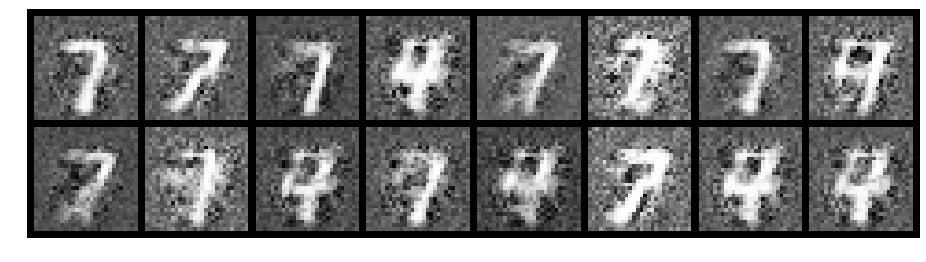

Epoch: [104/200], Batch Num: [0/600]
Discriminator Loss: 0.7998, Generator Loss: 1.7639
D(x): 0.7502, D(G(z)): 0.2568
Epoch: [104/200], Batch Num: [100/600]
Discriminator Loss: 0.7036, Generator Loss: 1.4954
D(x): 0.7765, D(G(z)): 0.2801


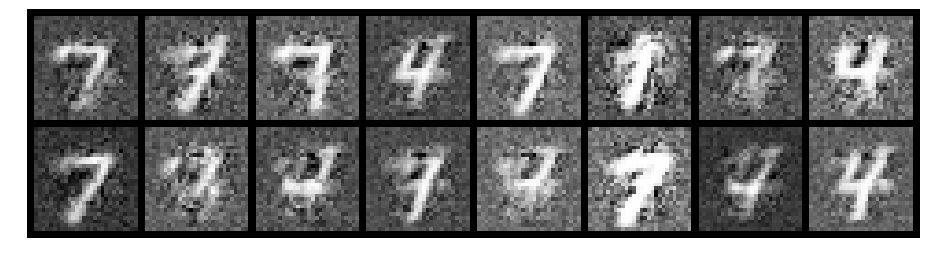

Epoch: [105/200], Batch Num: [0/600]
Discriminator Loss: 0.6331, Generator Loss: 1.6245
D(x): 0.8142, D(G(z)): 0.2751
Epoch: [105/200], Batch Num: [100/600]
Discriminator Loss: 0.8319, Generator Loss: 1.6785
D(x): 0.8046, D(G(z)): 0.3051


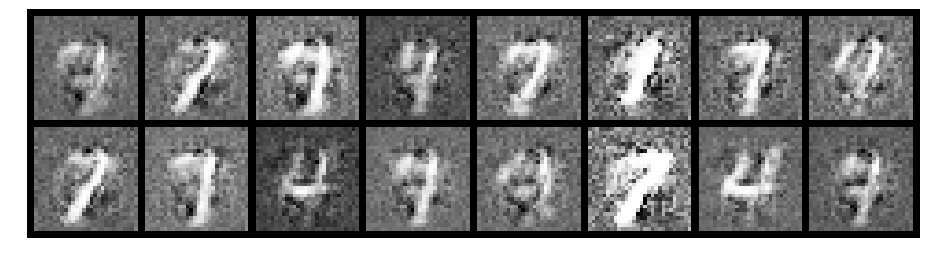

Epoch: [106/200], Batch Num: [0/600]
Discriminator Loss: 1.0791, Generator Loss: 1.2931
D(x): 0.6264, D(G(z)): 0.3364
Epoch: [106/200], Batch Num: [100/600]
Discriminator Loss: 0.5638, Generator Loss: 1.4320
D(x): 0.8458, D(G(z)): 0.2783


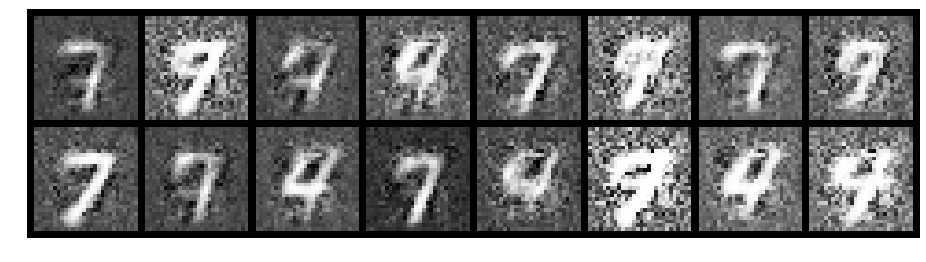

Epoch: [107/200], Batch Num: [0/600]
Discriminator Loss: 0.9918, Generator Loss: 1.6583
D(x): 0.6889, D(G(z)): 0.3024
Epoch: [107/200], Batch Num: [100/600]
Discriminator Loss: 0.8860, Generator Loss: 1.2722
D(x): 0.7186, D(G(z)): 0.3280


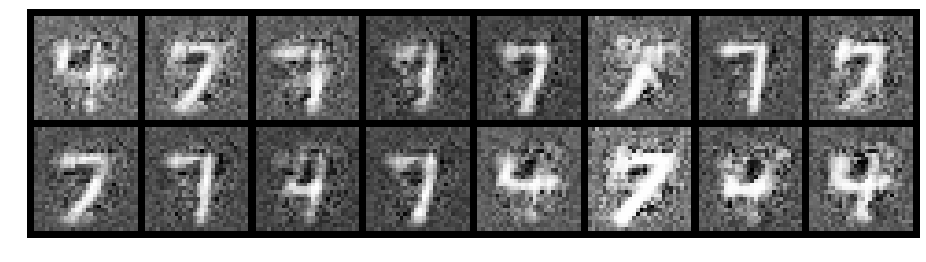

Epoch: [108/200], Batch Num: [0/600]
Discriminator Loss: 0.8045, Generator Loss: 1.2361
D(x): 0.7363, D(G(z)): 0.3030
Epoch: [108/200], Batch Num: [100/600]
Discriminator Loss: 0.8992, Generator Loss: 1.2703
D(x): 0.7652, D(G(z)): 0.3633


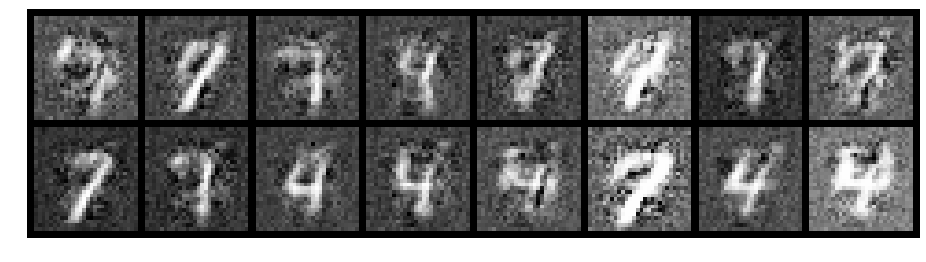

Epoch: [109/200], Batch Num: [0/600]
Discriminator Loss: 1.0945, Generator Loss: 1.3369
D(x): 0.6152, D(G(z)): 0.3302
Epoch: [109/200], Batch Num: [100/600]
Discriminator Loss: 0.8993, Generator Loss: 1.6354
D(x): 0.7229, D(G(z)): 0.2923


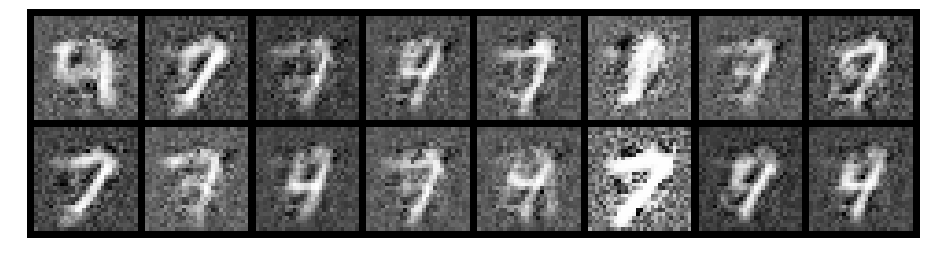

Epoch: [110/200], Batch Num: [0/600]
Discriminator Loss: 0.9869, Generator Loss: 1.2773
D(x): 0.5950, D(G(z)): 0.3104
Epoch: [110/200], Batch Num: [100/600]
Discriminator Loss: 0.7341, Generator Loss: 1.5637
D(x): 0.9082, D(G(z)): 0.3500


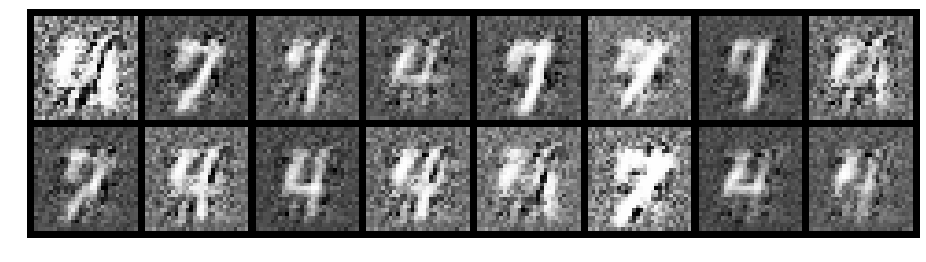

Epoch: [111/200], Batch Num: [0/600]
Discriminator Loss: 0.6820, Generator Loss: 1.8291
D(x): 0.7744, D(G(z)): 0.2378
Epoch: [111/200], Batch Num: [100/600]
Discriminator Loss: 0.9874, Generator Loss: 1.6253
D(x): 0.6358, D(G(z)): 0.2540


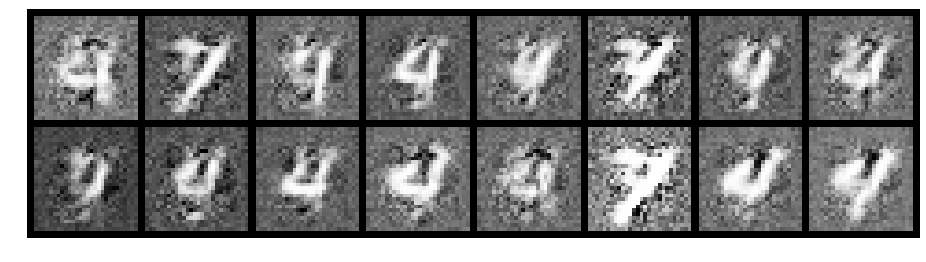

Epoch: [112/200], Batch Num: [0/600]
Discriminator Loss: 1.0273, Generator Loss: 1.6964
D(x): 0.6946, D(G(z)): 0.2909
Epoch: [112/200], Batch Num: [100/600]
Discriminator Loss: 1.1137, Generator Loss: 1.4278
D(x): 0.7012, D(G(z)): 0.3580


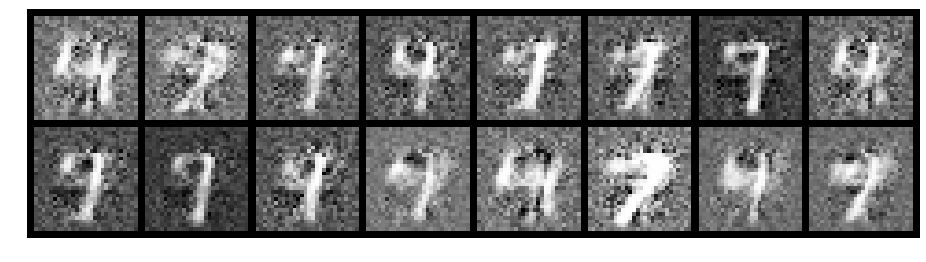

Epoch: [113/200], Batch Num: [0/600]
Discriminator Loss: 0.8402, Generator Loss: 1.8088
D(x): 0.7054, D(G(z)): 0.2365
Epoch: [113/200], Batch Num: [100/600]
Discriminator Loss: 0.5542, Generator Loss: 1.6573
D(x): 0.8604, D(G(z)): 0.2679


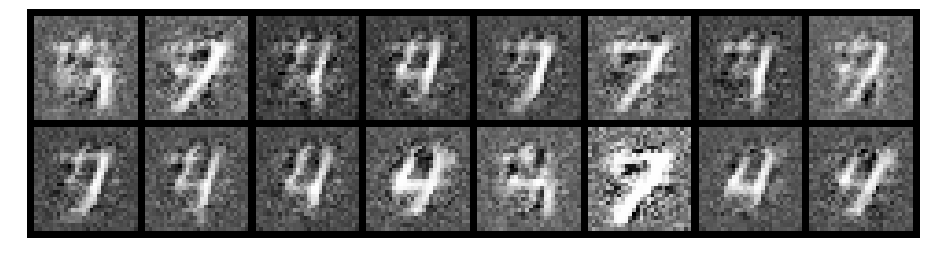

Epoch: [114/200], Batch Num: [0/600]
Discriminator Loss: 1.0701, Generator Loss: 1.6570
D(x): 0.7036, D(G(z)): 0.3186
Epoch: [114/200], Batch Num: [100/600]
Discriminator Loss: 0.8703, Generator Loss: 1.1207
D(x): 0.7284, D(G(z)): 0.3564


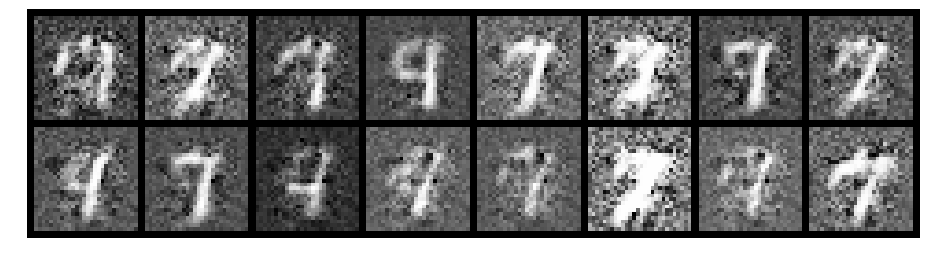

Epoch: [115/200], Batch Num: [0/600]
Discriminator Loss: 0.7332, Generator Loss: 1.7935
D(x): 0.7419, D(G(z)): 0.2275
Epoch: [115/200], Batch Num: [100/600]
Discriminator Loss: 0.9387, Generator Loss: 1.4927
D(x): 0.6687, D(G(z)): 0.2784


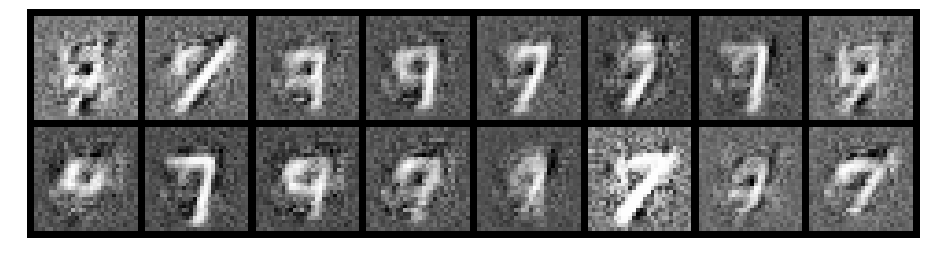

Epoch: [116/200], Batch Num: [0/600]
Discriminator Loss: 0.7242, Generator Loss: 1.4203
D(x): 0.7727, D(G(z)): 0.2916
Epoch: [116/200], Batch Num: [100/600]
Discriminator Loss: 1.0307, Generator Loss: 1.4617
D(x): 0.6425, D(G(z)): 0.2861


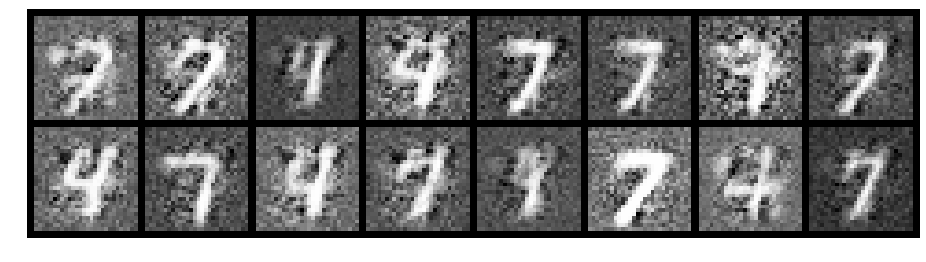

Epoch: [117/200], Batch Num: [0/600]
Discriminator Loss: 0.9228, Generator Loss: 1.5936
D(x): 0.7208, D(G(z)): 0.2968
Epoch: [117/200], Batch Num: [100/600]
Discriminator Loss: 0.9800, Generator Loss: 1.0577
D(x): 0.7050, D(G(z)): 0.3969


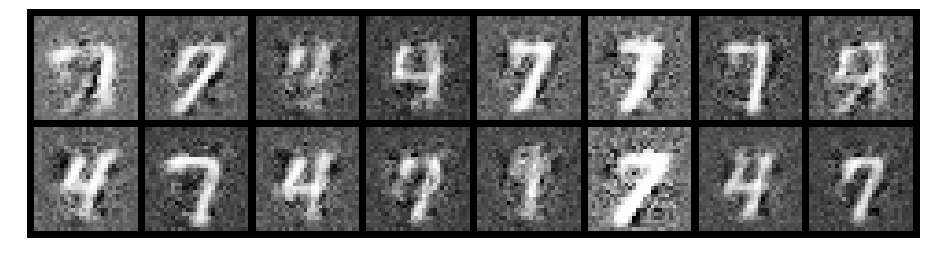

Epoch: [118/200], Batch Num: [0/600]
Discriminator Loss: 0.9791, Generator Loss: 1.5971
D(x): 0.7082, D(G(z)): 0.3166
Epoch: [118/200], Batch Num: [100/600]
Discriminator Loss: 0.8946, Generator Loss: 1.4342
D(x): 0.7303, D(G(z)): 0.3072


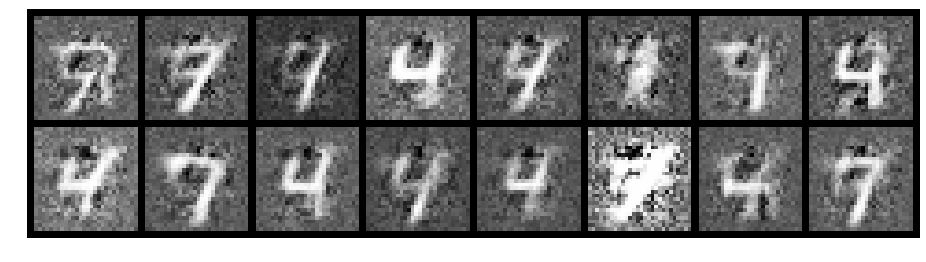

Epoch: [119/200], Batch Num: [0/600]
Discriminator Loss: 0.8874, Generator Loss: 1.4618
D(x): 0.7322, D(G(z)): 0.2823
Epoch: [119/200], Batch Num: [100/600]
Discriminator Loss: 0.6654, Generator Loss: 1.5421
D(x): 0.8402, D(G(z)): 0.2824


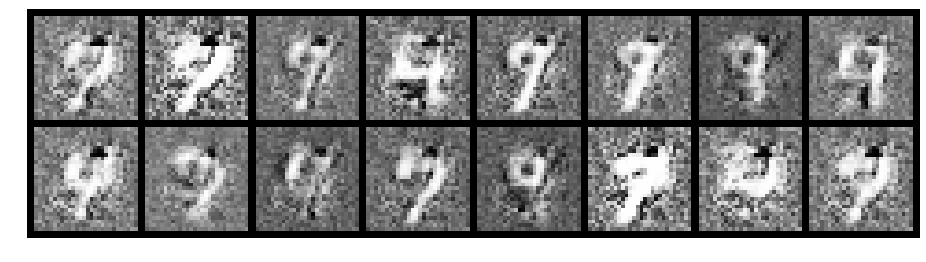

Epoch: [120/200], Batch Num: [0/600]
Discriminator Loss: 0.8030, Generator Loss: 1.1483
D(x): 0.7579, D(G(z)): 0.3402
Epoch: [120/200], Batch Num: [100/600]
Discriminator Loss: 0.6348, Generator Loss: 1.7906
D(x): 0.8036, D(G(z)): 0.2509


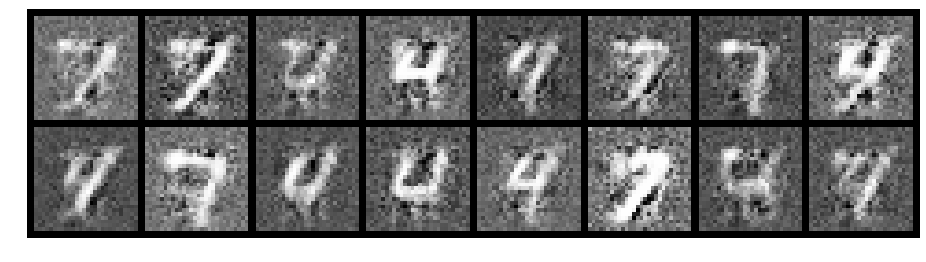

Epoch: [121/200], Batch Num: [0/600]
Discriminator Loss: 0.9360, Generator Loss: 1.3375
D(x): 0.7218, D(G(z)): 0.3315
Epoch: [121/200], Batch Num: [100/600]
Discriminator Loss: 1.0115, Generator Loss: 1.5461
D(x): 0.6837, D(G(z)): 0.3189


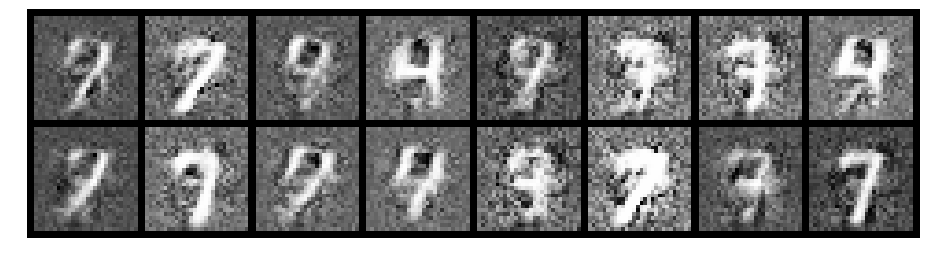

Epoch: [122/200], Batch Num: [0/600]
Discriminator Loss: 0.8461, Generator Loss: 1.3793
D(x): 0.7285, D(G(z)): 0.3047
Epoch: [122/200], Batch Num: [100/600]
Discriminator Loss: 0.9008, Generator Loss: 1.5146
D(x): 0.7249, D(G(z)): 0.3146


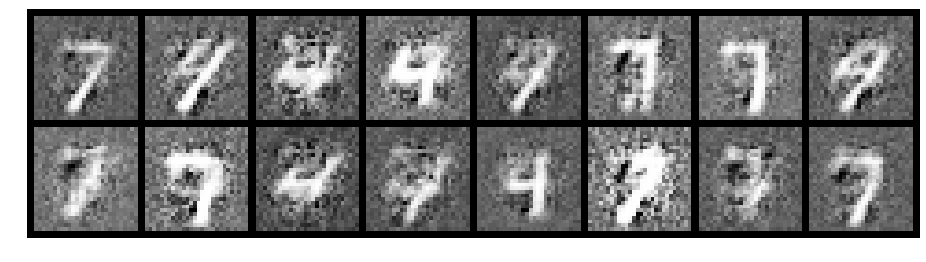

Epoch: [123/200], Batch Num: [0/600]
Discriminator Loss: 0.7878, Generator Loss: 1.8400
D(x): 0.8067, D(G(z)): 0.2579
Epoch: [123/200], Batch Num: [100/600]
Discriminator Loss: 0.8510, Generator Loss: 1.4638
D(x): 0.7419, D(G(z)): 0.3319


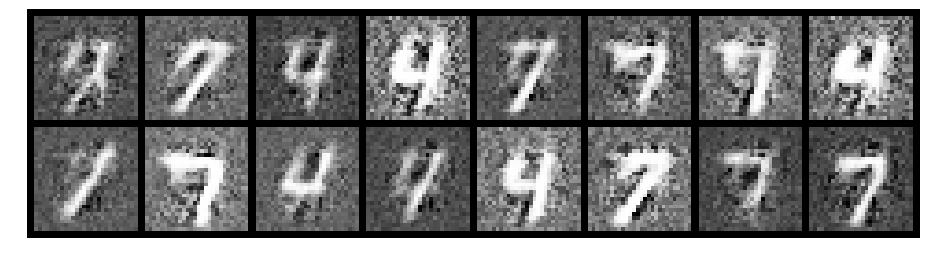

Epoch: [124/200], Batch Num: [0/600]
Discriminator Loss: 0.5556, Generator Loss: 1.7119
D(x): 0.8332, D(G(z)): 0.2345
Epoch: [124/200], Batch Num: [100/600]
Discriminator Loss: 0.8073, Generator Loss: 1.6905
D(x): 0.7408, D(G(z)): 0.2730


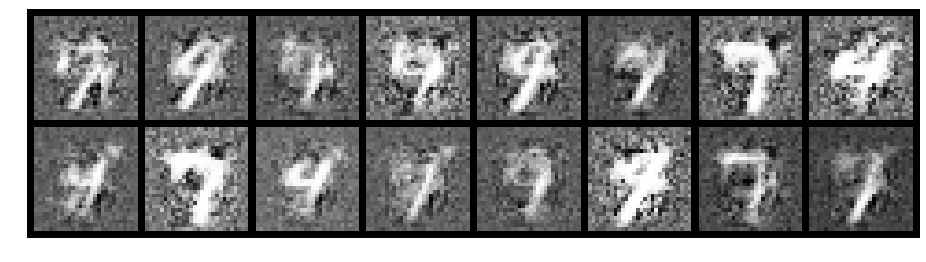

Epoch: [125/200], Batch Num: [0/600]
Discriminator Loss: 0.9356, Generator Loss: 1.5803
D(x): 0.6669, D(G(z)): 0.2604
Epoch: [125/200], Batch Num: [100/600]
Discriminator Loss: 0.6869, Generator Loss: 2.0317
D(x): 0.8087, D(G(z)): 0.2392


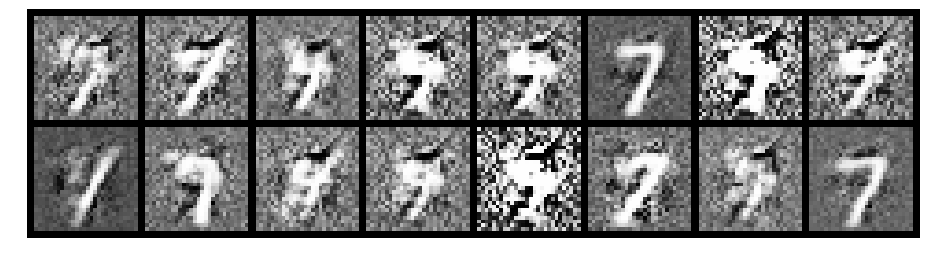

Epoch: [126/200], Batch Num: [0/600]
Discriminator Loss: 0.7572, Generator Loss: 4.6057
D(x): 0.7297, D(G(z)): 0.1279
Epoch: [126/200], Batch Num: [100/600]
Discriminator Loss: 0.8402, Generator Loss: 2.1807
D(x): 0.7517, D(G(z)): 0.2318


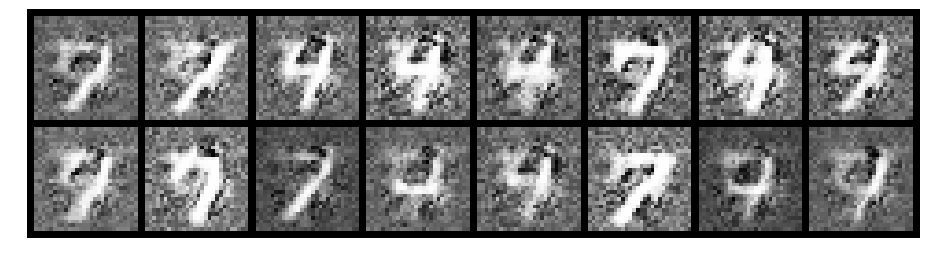

Epoch: [127/200], Batch Num: [0/600]
Discriminator Loss: 1.1060, Generator Loss: 1.7264
D(x): 0.6463, D(G(z)): 0.2919
Epoch: [127/200], Batch Num: [100/600]
Discriminator Loss: 0.7939, Generator Loss: 1.7416
D(x): 0.7805, D(G(z)): 0.2768


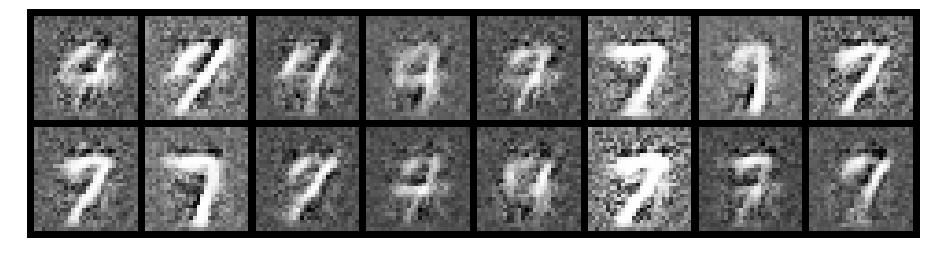

Epoch: [128/200], Batch Num: [0/600]
Discriminator Loss: 0.6872, Generator Loss: 1.5582
D(x): 0.7857, D(G(z)): 0.2555
Epoch: [128/200], Batch Num: [100/600]
Discriminator Loss: 0.7729, Generator Loss: 1.8219
D(x): 0.7395, D(G(z)): 0.2392


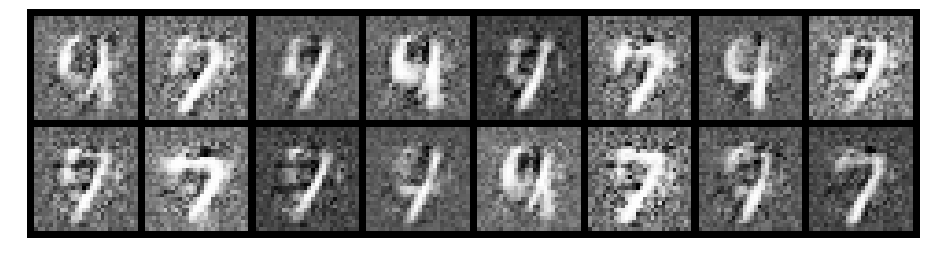

Epoch: [129/200], Batch Num: [0/600]
Discriminator Loss: 1.0520, Generator Loss: 1.1883
D(x): 0.6939, D(G(z)): 0.3880
Epoch: [129/200], Batch Num: [100/600]
Discriminator Loss: 0.9866, Generator Loss: 1.2093
D(x): 0.6773, D(G(z)): 0.3322


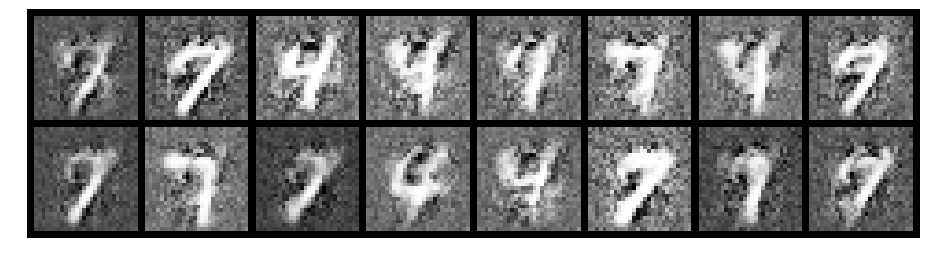

Epoch: [130/200], Batch Num: [0/600]
Discriminator Loss: 0.6990, Generator Loss: 1.8093
D(x): 0.7796, D(G(z)): 0.2448
Epoch: [130/200], Batch Num: [100/600]
Discriminator Loss: 0.6920, Generator Loss: 1.9809
D(x): 0.7313, D(G(z)): 0.2178


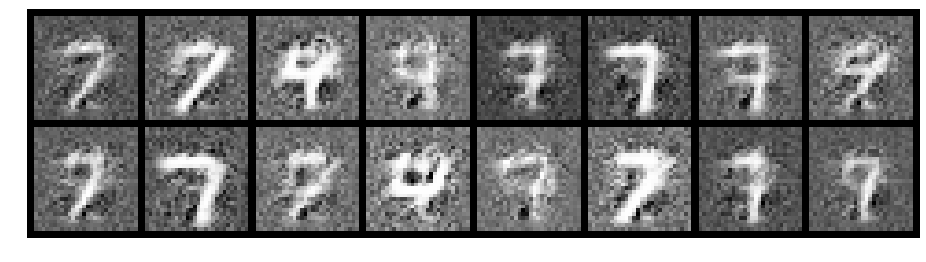

Epoch: [131/200], Batch Num: [0/600]
Discriminator Loss: 1.0762, Generator Loss: 1.9647
D(x): 0.6498, D(G(z)): 0.1946
Epoch: [131/200], Batch Num: [100/600]
Discriminator Loss: 0.6333, Generator Loss: 1.6024
D(x): 0.8159, D(G(z)): 0.2500


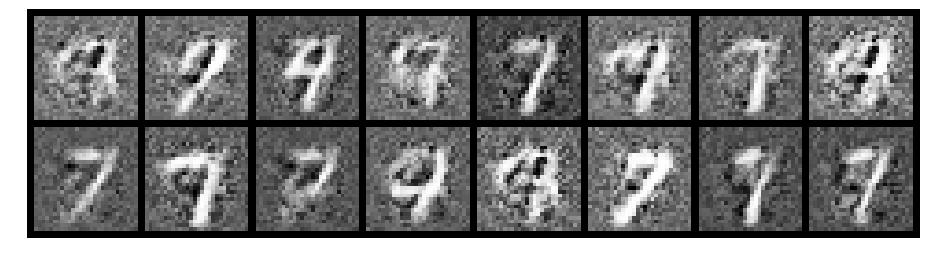

Epoch: [132/200], Batch Num: [0/600]
Discriminator Loss: 0.8719, Generator Loss: 1.6649
D(x): 0.7126, D(G(z)): 0.2940
Epoch: [132/200], Batch Num: [100/600]
Discriminator Loss: 0.9039, Generator Loss: 1.8057
D(x): 0.6821, D(G(z)): 0.2491


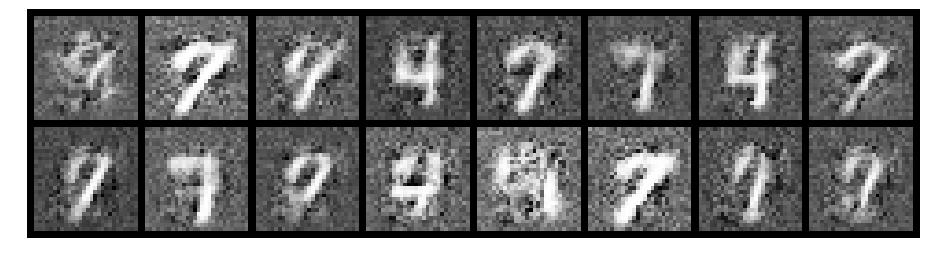

Epoch: [133/200], Batch Num: [0/600]
Discriminator Loss: 0.7196, Generator Loss: 1.6989
D(x): 0.8046, D(G(z)): 0.2818
Epoch: [133/200], Batch Num: [100/600]
Discriminator Loss: 0.7977, Generator Loss: 1.5308
D(x): 0.7339, D(G(z)): 0.2827


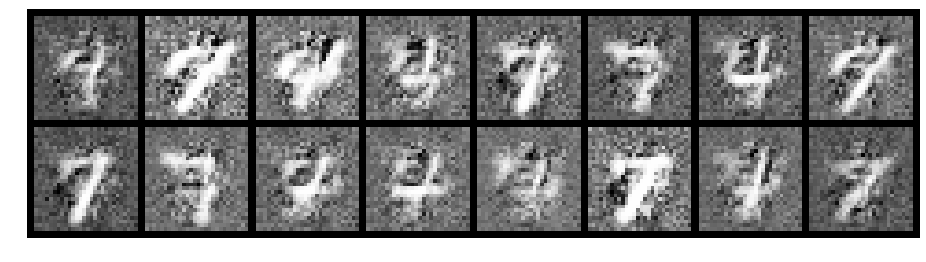

Epoch: [134/200], Batch Num: [0/600]
Discriminator Loss: 0.7021, Generator Loss: 1.8986
D(x): 0.8047, D(G(z)): 0.2244
Epoch: [134/200], Batch Num: [100/600]
Discriminator Loss: 0.8763, Generator Loss: 1.5965
D(x): 0.7156, D(G(z)): 0.2930


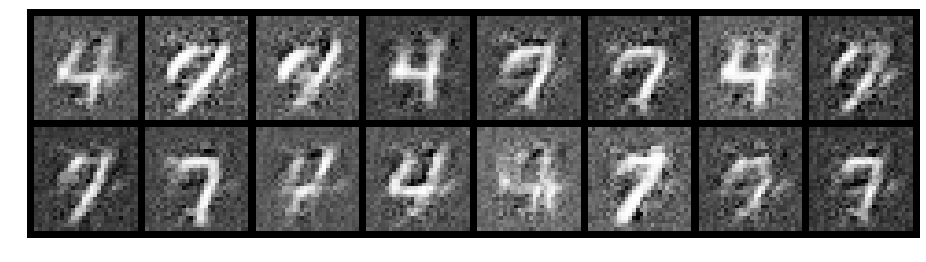

Epoch: [135/200], Batch Num: [0/600]
Discriminator Loss: 0.8910, Generator Loss: 1.3539
D(x): 0.7381, D(G(z)): 0.3046
Epoch: [135/200], Batch Num: [100/600]
Discriminator Loss: 0.8979, Generator Loss: 1.5616
D(x): 0.7283, D(G(z)): 0.3030


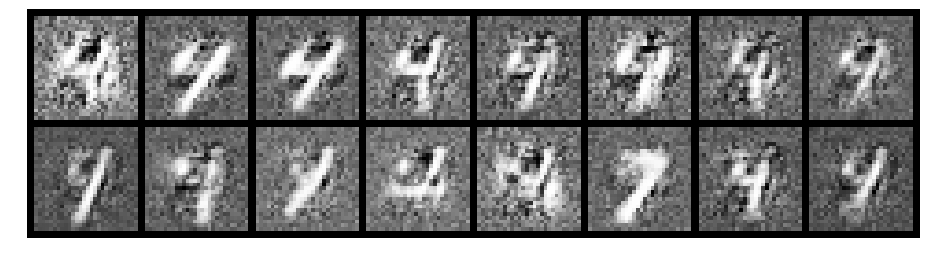

Epoch: [136/200], Batch Num: [0/600]
Discriminator Loss: 0.7398, Generator Loss: 1.8911
D(x): 0.7446, D(G(z)): 0.2198
Epoch: [136/200], Batch Num: [100/600]
Discriminator Loss: 0.6995, Generator Loss: 2.0169
D(x): 0.7702, D(G(z)): 0.2078


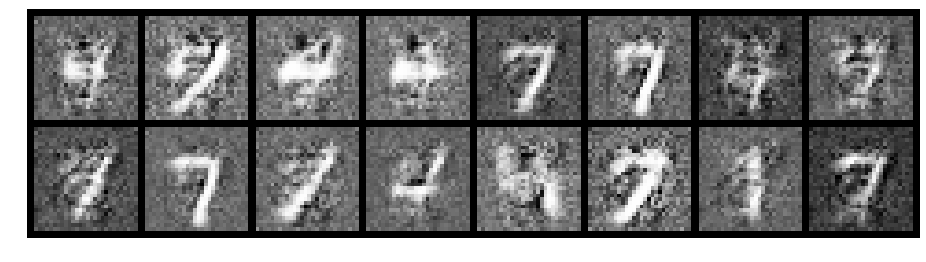

Epoch: [137/200], Batch Num: [0/600]
Discriminator Loss: 0.8369, Generator Loss: 1.9806
D(x): 0.7567, D(G(z)): 0.2369
Epoch: [137/200], Batch Num: [100/600]
Discriminator Loss: 0.7386, Generator Loss: 1.6114
D(x): 0.7812, D(G(z)): 0.2809


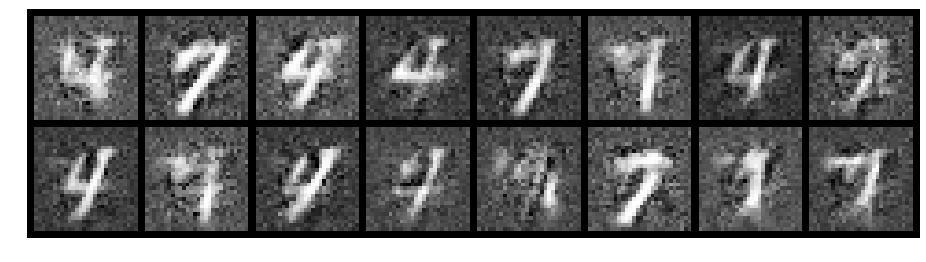

Epoch: [138/200], Batch Num: [0/600]
Discriminator Loss: 0.6979, Generator Loss: 1.5298
D(x): 0.7755, D(G(z)): 0.2607
Epoch: [138/200], Batch Num: [100/600]
Discriminator Loss: 1.0352, Generator Loss: 1.5326
D(x): 0.6592, D(G(z)): 0.2777


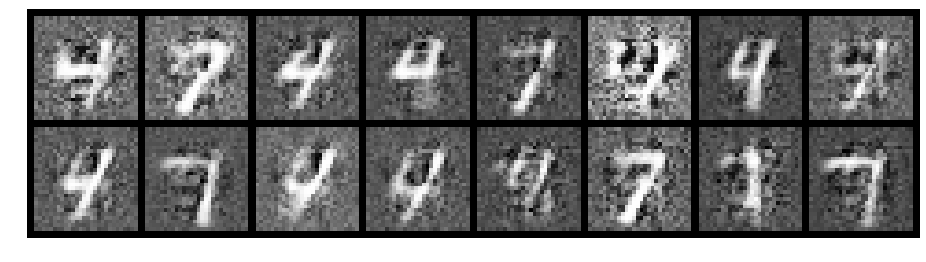

Epoch: [139/200], Batch Num: [0/600]
Discriminator Loss: 0.9938, Generator Loss: 1.8983
D(x): 0.6777, D(G(z)): 0.2668
Epoch: [139/200], Batch Num: [100/600]
Discriminator Loss: 0.6963, Generator Loss: 1.4306
D(x): 0.8168, D(G(z)): 0.3066


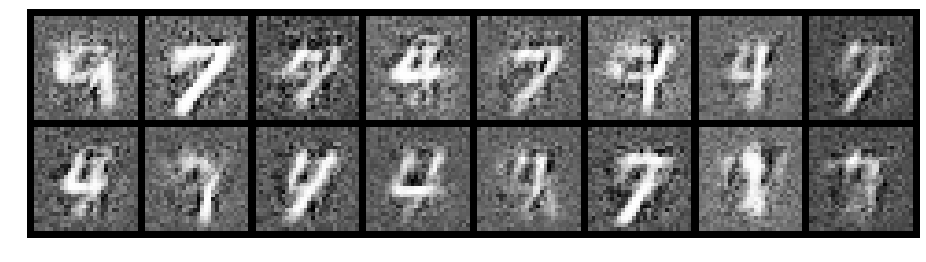

Epoch: [140/200], Batch Num: [0/600]
Discriminator Loss: 0.8694, Generator Loss: 1.5707
D(x): 0.7271, D(G(z)): 0.2762
Epoch: [140/200], Batch Num: [100/600]
Discriminator Loss: 0.8195, Generator Loss: 1.4667
D(x): 0.7465, D(G(z)): 0.2803


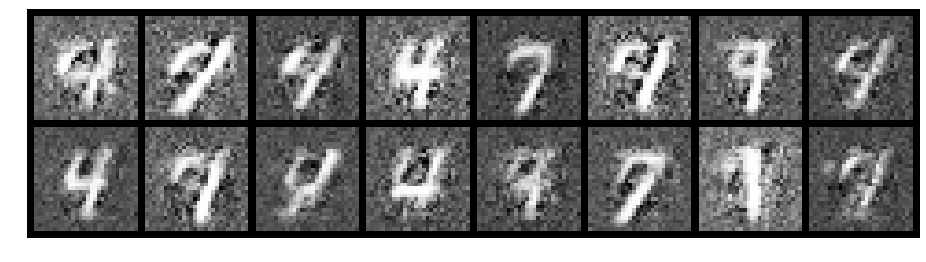

Epoch: [141/200], Batch Num: [0/600]
Discriminator Loss: 0.9484, Generator Loss: 1.6891
D(x): 0.7031, D(G(z)): 0.2654
Epoch: [141/200], Batch Num: [100/600]
Discriminator Loss: 0.8214, Generator Loss: 2.0776
D(x): 0.7488, D(G(z)): 0.2370


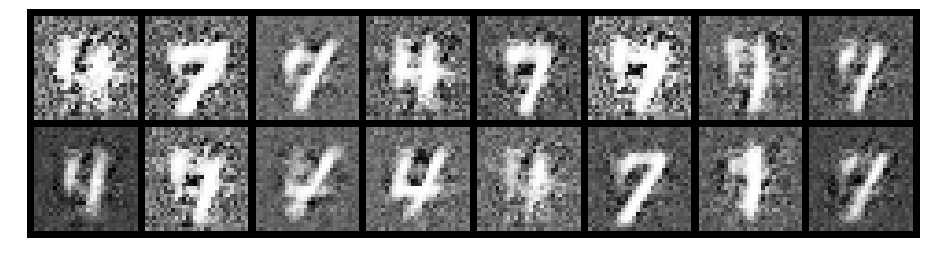

Epoch: [142/200], Batch Num: [0/600]
Discriminator Loss: 0.7092, Generator Loss: 1.9140
D(x): 0.7495, D(G(z)): 0.1925
Epoch: [142/200], Batch Num: [100/600]
Discriminator Loss: 0.7887, Generator Loss: 1.6368
D(x): 0.7227, D(G(z)): 0.2601


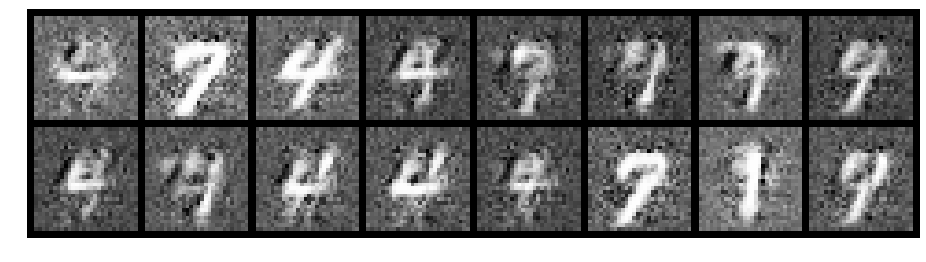

Epoch: [143/200], Batch Num: [0/600]
Discriminator Loss: 0.8922, Generator Loss: 1.5852
D(x): 0.7193, D(G(z)): 0.3071
Epoch: [143/200], Batch Num: [100/600]
Discriminator Loss: 0.5108, Generator Loss: 2.2705
D(x): 0.8629, D(G(z)): 0.1757


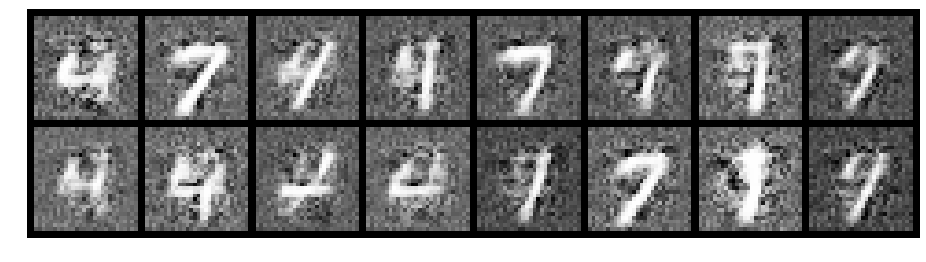

Epoch: [144/200], Batch Num: [0/600]
Discriminator Loss: 0.8873, Generator Loss: 1.6115
D(x): 0.7180, D(G(z)): 0.2705
Epoch: [144/200], Batch Num: [100/600]
Discriminator Loss: 0.7657, Generator Loss: 1.6617
D(x): 0.7736, D(G(z)): 0.2685


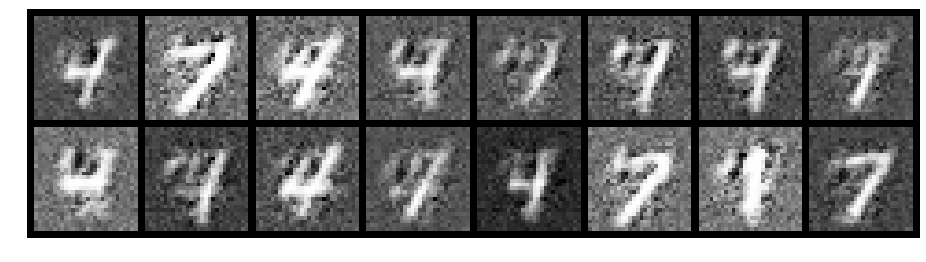

Epoch: [145/200], Batch Num: [0/600]
Discriminator Loss: 0.7697, Generator Loss: 1.4004
D(x): 0.7532, D(G(z)): 0.2785
Epoch: [145/200], Batch Num: [100/600]
Discriminator Loss: 0.8752, Generator Loss: 1.8665
D(x): 0.7625, D(G(z)): 0.2753


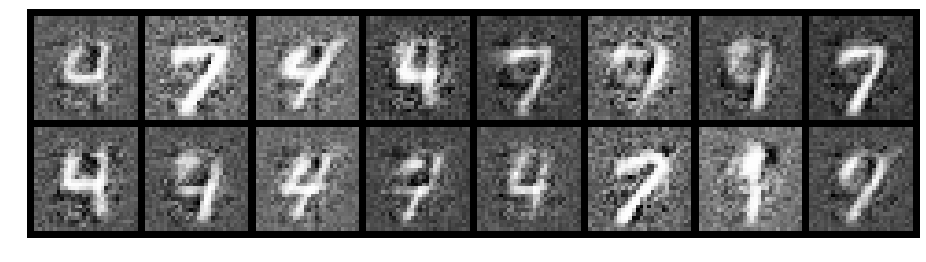

Epoch: [146/200], Batch Num: [0/600]
Discriminator Loss: 1.0053, Generator Loss: 1.4414
D(x): 0.6754, D(G(z)): 0.2992
Epoch: [146/200], Batch Num: [100/600]
Discriminator Loss: 0.9240, Generator Loss: 1.6866
D(x): 0.7111, D(G(z)): 0.2819


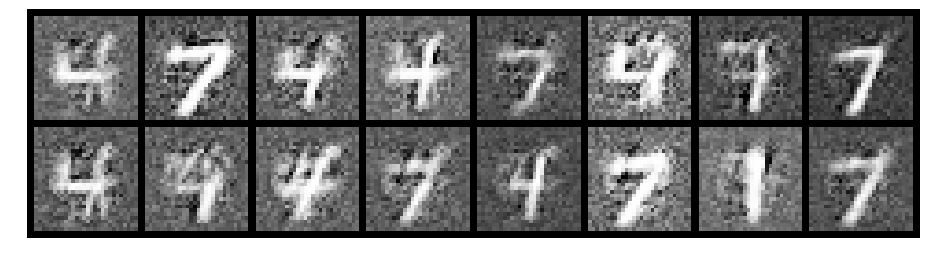

Epoch: [147/200], Batch Num: [0/600]
Discriminator Loss: 0.8872, Generator Loss: 1.3283
D(x): 0.6960, D(G(z)): 0.3070
Epoch: [147/200], Batch Num: [100/600]
Discriminator Loss: 0.7476, Generator Loss: 1.8469
D(x): 0.7666, D(G(z)): 0.2386


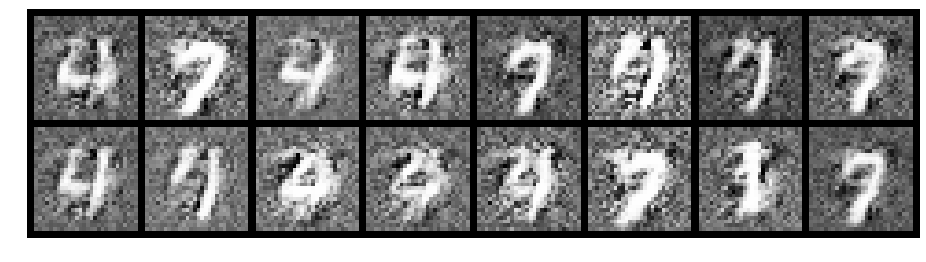

Epoch: [148/200], Batch Num: [0/600]
Discriminator Loss: 0.8511, Generator Loss: 2.2391
D(x): 0.7239, D(G(z)): 0.2154
Epoch: [148/200], Batch Num: [100/600]
Discriminator Loss: 0.9034, Generator Loss: 1.8453
D(x): 0.7404, D(G(z)): 0.2830


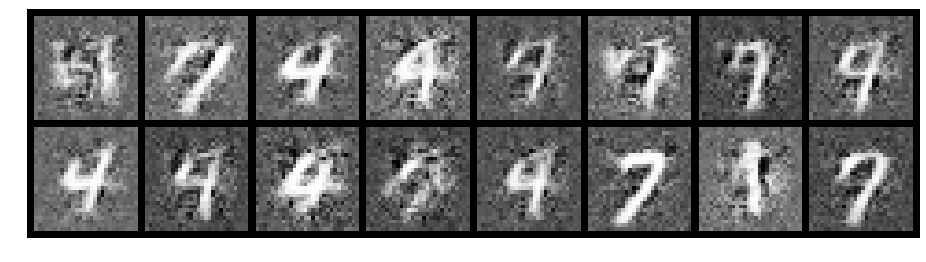

Epoch: [149/200], Batch Num: [0/600]
Discriminator Loss: 0.7212, Generator Loss: 1.7004
D(x): 0.7795, D(G(z)): 0.2547
Epoch: [149/200], Batch Num: [100/600]
Discriminator Loss: 0.5806, Generator Loss: 1.5324
D(x): 0.8226, D(G(z)): 0.2416


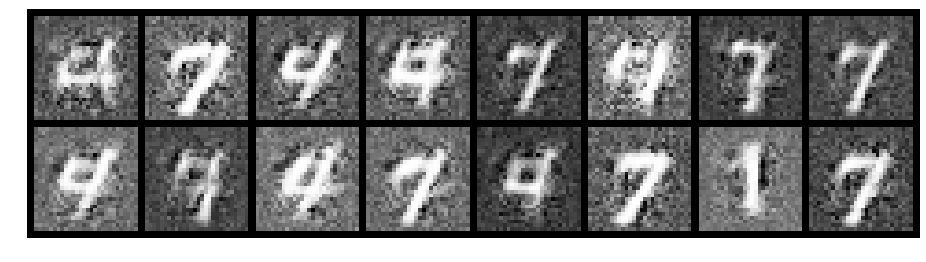

Epoch: [150/200], Batch Num: [0/600]
Discriminator Loss: 0.7048, Generator Loss: 1.7238
D(x): 0.7858, D(G(z)): 0.2650
Epoch: [150/200], Batch Num: [100/600]
Discriminator Loss: 1.0288, Generator Loss: 1.4190
D(x): 0.6869, D(G(z)): 0.3296


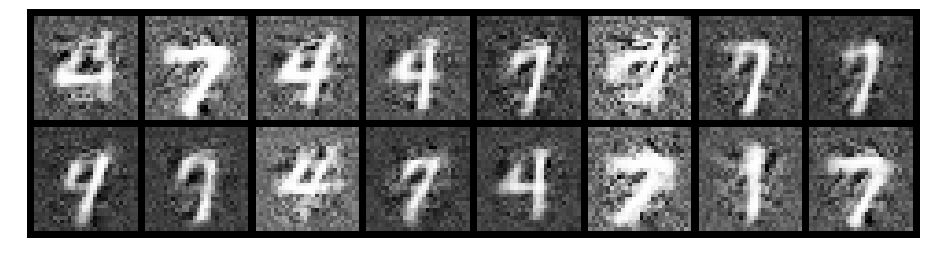

Epoch: [151/200], Batch Num: [0/600]
Discriminator Loss: 0.7131, Generator Loss: 1.8684
D(x): 0.8213, D(G(z)): 0.2549
Epoch: [151/200], Batch Num: [100/600]
Discriminator Loss: 0.7366, Generator Loss: 1.4374
D(x): 0.7475, D(G(z)): 0.2809


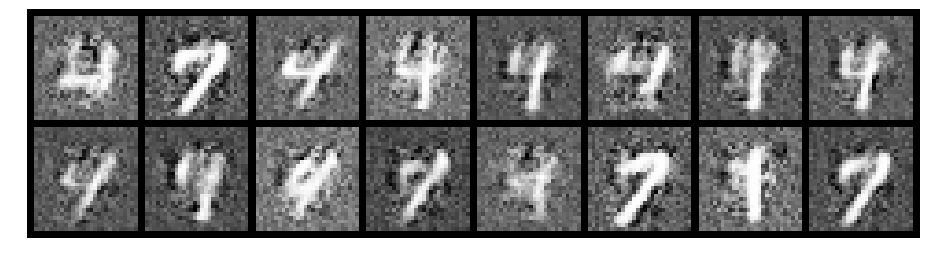

Epoch: [152/200], Batch Num: [0/600]
Discriminator Loss: 0.9491, Generator Loss: 1.8802
D(x): 0.7097, D(G(z)): 0.2395
Epoch: [152/200], Batch Num: [100/600]
Discriminator Loss: 0.7266, Generator Loss: 1.3734
D(x): 0.7495, D(G(z)): 0.2792


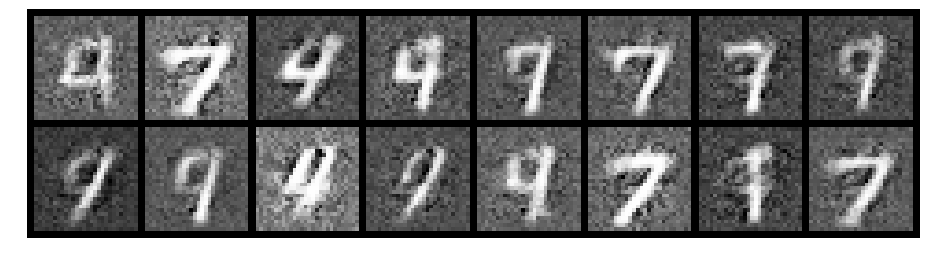

Epoch: [153/200], Batch Num: [0/600]
Discriminator Loss: 0.7270, Generator Loss: 1.7122
D(x): 0.7607, D(G(z)): 0.2461
Epoch: [153/200], Batch Num: [100/600]
Discriminator Loss: 0.9274, Generator Loss: 1.9584
D(x): 0.6904, D(G(z)): 0.2244


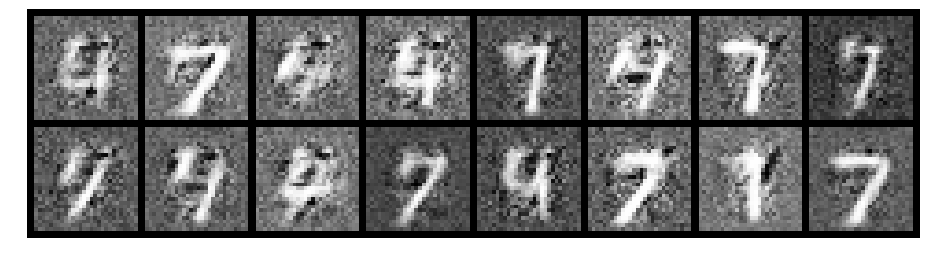

Epoch: [154/200], Batch Num: [0/600]
Discriminator Loss: 0.8493, Generator Loss: 1.9232
D(x): 0.7111, D(G(z)): 0.2290
Epoch: [154/200], Batch Num: [100/600]
Discriminator Loss: 0.7761, Generator Loss: 1.6808
D(x): 0.7984, D(G(z)): 0.2825


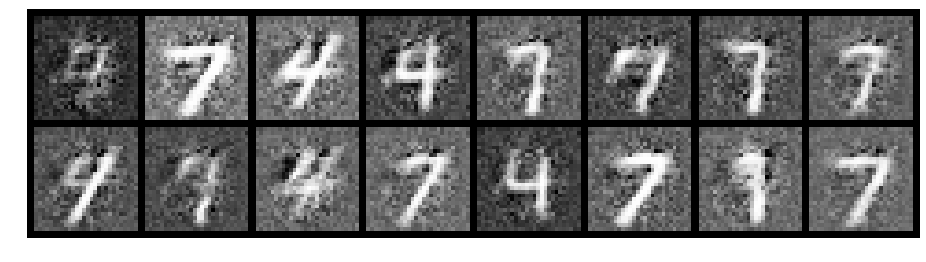

Epoch: [155/200], Batch Num: [0/600]
Discriminator Loss: 1.1332, Generator Loss: 1.3773
D(x): 0.6540, D(G(z)): 0.3448
Epoch: [155/200], Batch Num: [100/600]
Discriminator Loss: 0.7452, Generator Loss: 1.7001
D(x): 0.7349, D(G(z)): 0.2356


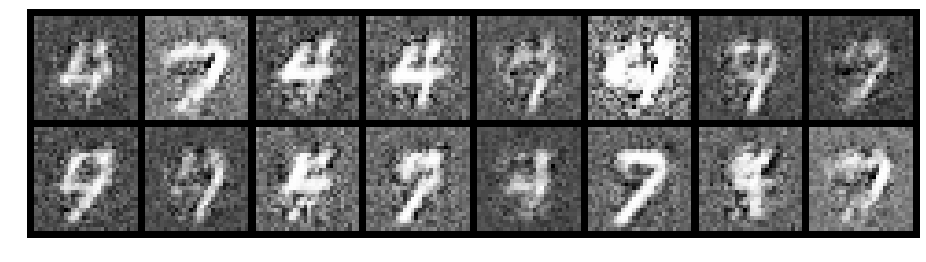

Epoch: [156/200], Batch Num: [0/600]
Discriminator Loss: 0.8267, Generator Loss: 1.7910
D(x): 0.7068, D(G(z)): 0.2244
Epoch: [156/200], Batch Num: [100/600]
Discriminator Loss: 0.8772, Generator Loss: 1.6821
D(x): 0.7279, D(G(z)): 0.2689


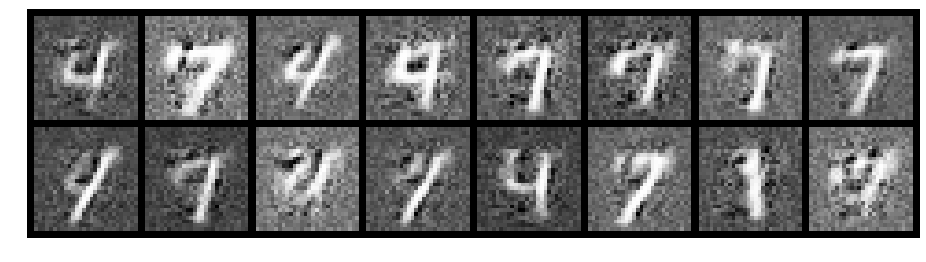

Epoch: [157/200], Batch Num: [0/600]
Discriminator Loss: 0.8006, Generator Loss: 1.7190
D(x): 0.7309, D(G(z)): 0.2370
Epoch: [157/200], Batch Num: [100/600]
Discriminator Loss: 0.6306, Generator Loss: 1.8868
D(x): 0.7952, D(G(z)): 0.2021


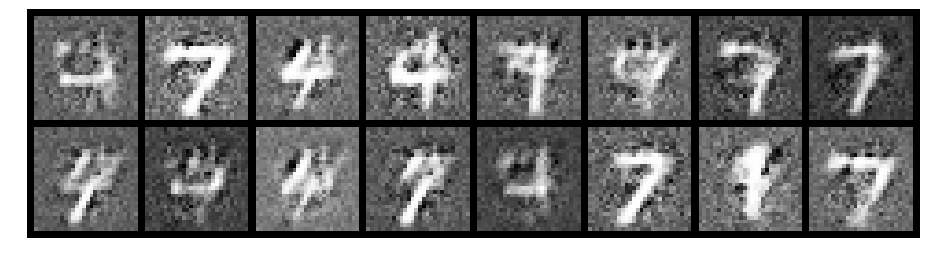

Epoch: [158/200], Batch Num: [0/600]
Discriminator Loss: 0.9455, Generator Loss: 1.8319
D(x): 0.7748, D(G(z)): 0.2980
Epoch: [158/200], Batch Num: [100/600]
Discriminator Loss: 0.7384, Generator Loss: 1.6983
D(x): 0.7199, D(G(z)): 0.2054


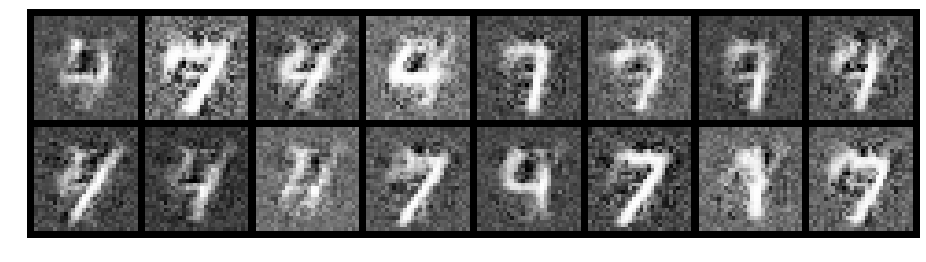

Epoch: [159/200], Batch Num: [0/600]
Discriminator Loss: 0.6087, Generator Loss: 1.5422
D(x): 0.8163, D(G(z)): 0.2651
Epoch: [159/200], Batch Num: [100/600]
Discriminator Loss: 0.6979, Generator Loss: 1.5504
D(x): 0.7723, D(G(z)): 0.2599


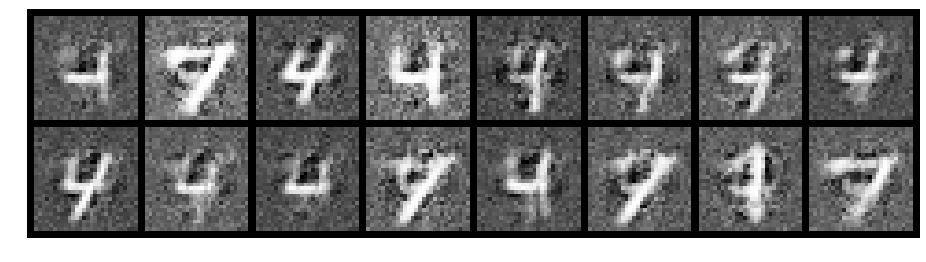

Epoch: [160/200], Batch Num: [0/600]
Discriminator Loss: 0.8005, Generator Loss: 1.4798
D(x): 0.7668, D(G(z)): 0.2662
Epoch: [160/200], Batch Num: [100/600]
Discriminator Loss: 1.0103, Generator Loss: 1.6446
D(x): 0.6586, D(G(z)): 0.2825


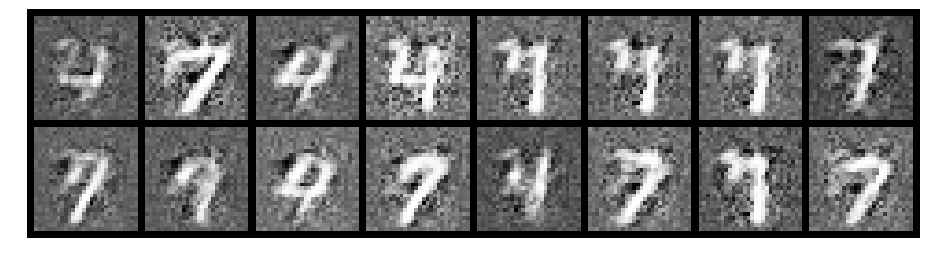

Epoch: [161/200], Batch Num: [0/600]
Discriminator Loss: 0.7649, Generator Loss: 1.7152
D(x): 0.7599, D(G(z)): 0.2527
Epoch: [161/200], Batch Num: [100/600]
Discriminator Loss: 0.7762, Generator Loss: 1.7116
D(x): 0.7584, D(G(z)): 0.2538


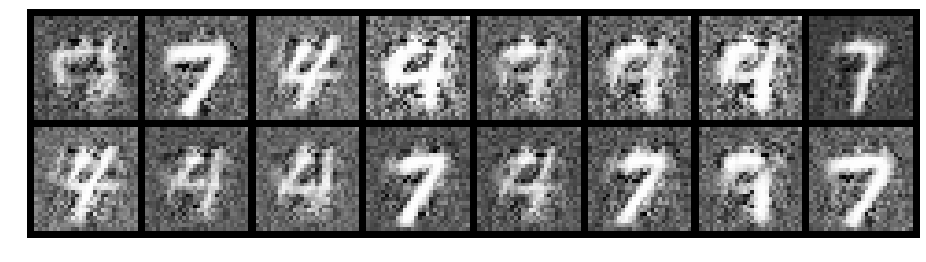

Epoch: [162/200], Batch Num: [0/600]
Discriminator Loss: 0.9246, Generator Loss: 1.3936
D(x): 0.7179, D(G(z)): 0.3436
Epoch: [162/200], Batch Num: [100/600]
Discriminator Loss: 0.9207, Generator Loss: 1.7915
D(x): 0.7224, D(G(z)): 0.2623


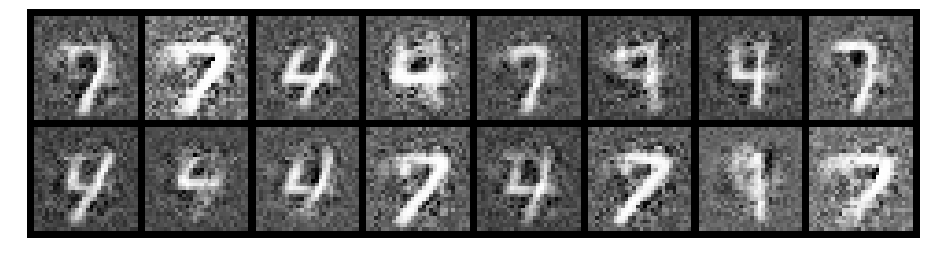

Epoch: [163/200], Batch Num: [0/600]
Discriminator Loss: 0.9301, Generator Loss: 1.4387
D(x): 0.7431, D(G(z)): 0.3103
Epoch: [163/200], Batch Num: [100/600]
Discriminator Loss: 0.7637, Generator Loss: 2.1602
D(x): 0.7946, D(G(z)): 0.2508


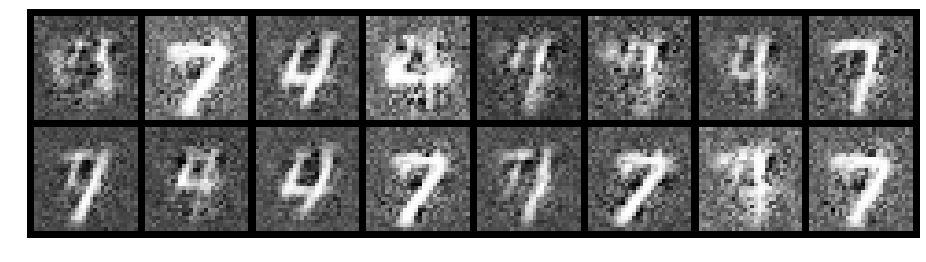

Epoch: [164/200], Batch Num: [0/600]
Discriminator Loss: 0.8325, Generator Loss: 1.3186
D(x): 0.7521, D(G(z)): 0.3305
Epoch: [164/200], Batch Num: [100/600]
Discriminator Loss: 0.9823, Generator Loss: 1.5977
D(x): 0.6446, D(G(z)): 0.2778


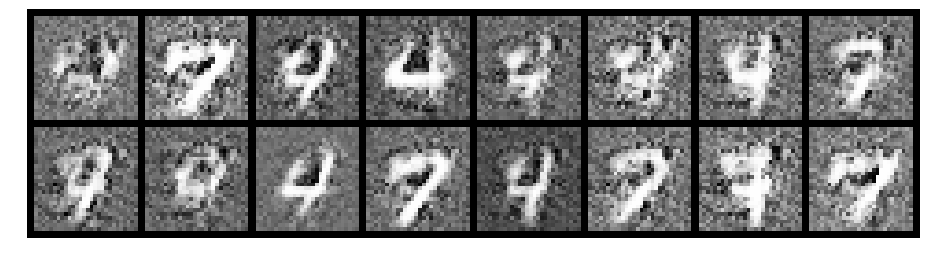

Epoch: [165/200], Batch Num: [0/600]
Discriminator Loss: 0.7350, Generator Loss: 1.8744
D(x): 0.7416, D(G(z)): 0.2220
Epoch: [165/200], Batch Num: [100/600]
Discriminator Loss: 0.8533, Generator Loss: 1.3159
D(x): 0.7035, D(G(z)): 0.3073


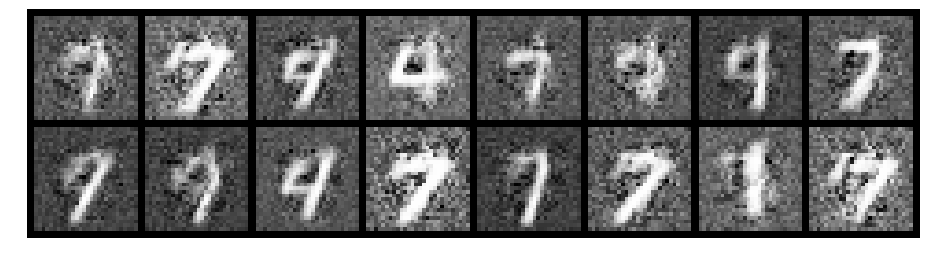

Epoch: [166/200], Batch Num: [0/600]
Discriminator Loss: 0.7141, Generator Loss: 1.8812
D(x): 0.7863, D(G(z)): 0.2393
Epoch: [166/200], Batch Num: [100/600]
Discriminator Loss: 0.7218, Generator Loss: 1.7697
D(x): 0.7534, D(G(z)): 0.2239


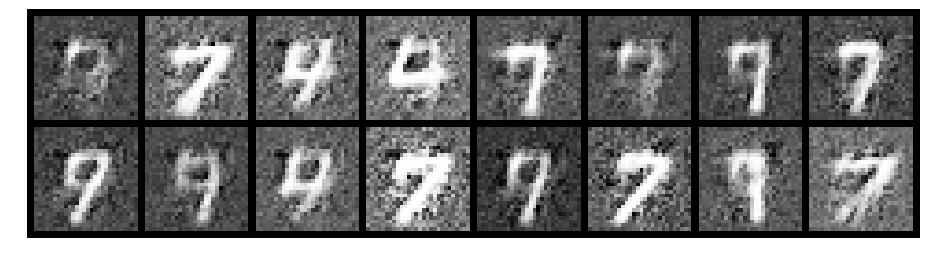

Epoch: [167/200], Batch Num: [0/600]
Discriminator Loss: 0.7846, Generator Loss: 1.6514
D(x): 0.8012, D(G(z)): 0.2792
Epoch: [167/200], Batch Num: [100/600]
Discriminator Loss: 0.5338, Generator Loss: 2.3618
D(x): 0.8498, D(G(z)): 0.1953


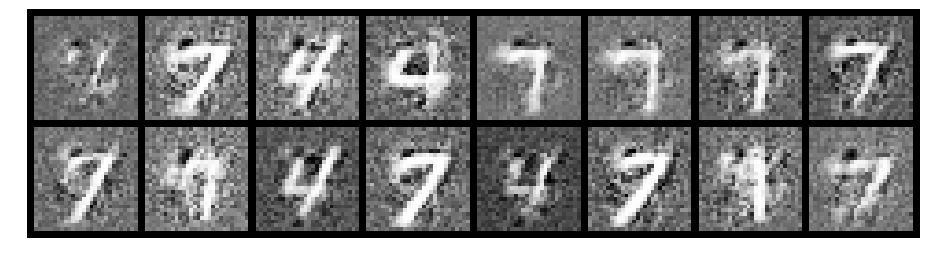

Epoch: [168/200], Batch Num: [0/600]
Discriminator Loss: 0.8011, Generator Loss: 1.7955
D(x): 0.7396, D(G(z)): 0.2546
Epoch: [168/200], Batch Num: [100/600]
Discriminator Loss: 0.6466, Generator Loss: 1.5414
D(x): 0.8055, D(G(z)): 0.2600


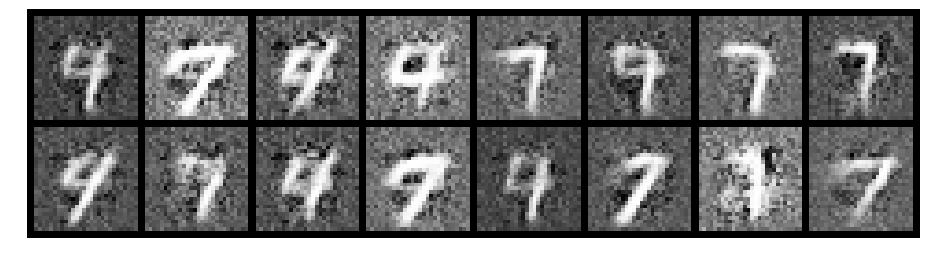

Epoch: [169/200], Batch Num: [0/600]
Discriminator Loss: 0.7903, Generator Loss: 2.2348
D(x): 0.7121, D(G(z)): 0.1813
Epoch: [169/200], Batch Num: [100/600]
Discriminator Loss: 0.7202, Generator Loss: 1.8182
D(x): 0.7631, D(G(z)): 0.2361


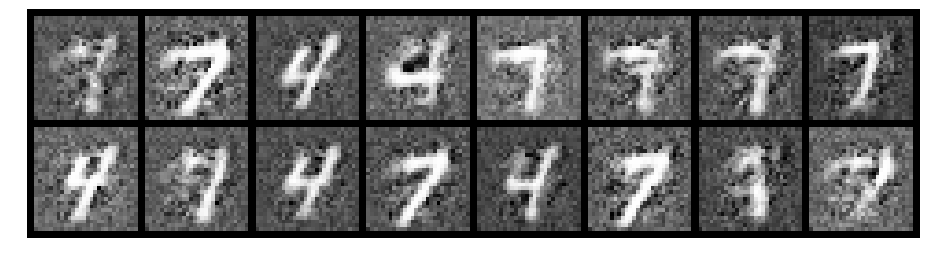

Epoch: [170/200], Batch Num: [0/600]
Discriminator Loss: 0.8951, Generator Loss: 1.4691
D(x): 0.7276, D(G(z)): 0.2910
Epoch: [170/200], Batch Num: [100/600]
Discriminator Loss: 0.7447, Generator Loss: 1.8590
D(x): 0.7656, D(G(z)): 0.2470


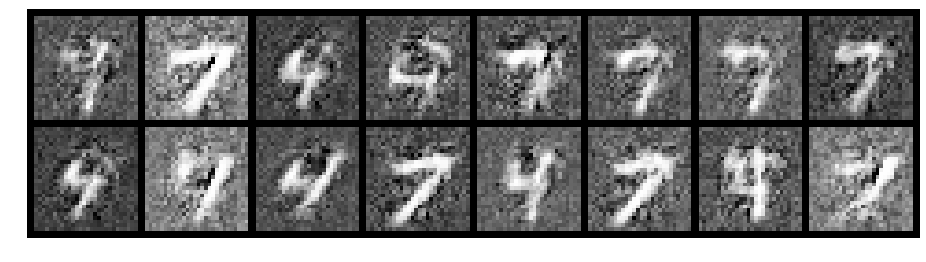

Epoch: [171/200], Batch Num: [0/600]
Discriminator Loss: 0.9279, Generator Loss: 1.4419
D(x): 0.7181, D(G(z)): 0.3173
Epoch: [171/200], Batch Num: [100/600]
Discriminator Loss: 0.8473, Generator Loss: 1.8570
D(x): 0.6943, D(G(z)): 0.2101


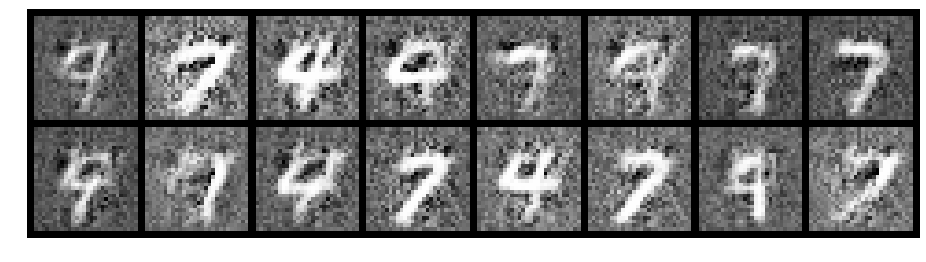

Epoch: [172/200], Batch Num: [0/600]
Discriminator Loss: 0.7486, Generator Loss: 1.8191
D(x): 0.7398, D(G(z)): 0.2096
Epoch: [172/200], Batch Num: [100/600]
Discriminator Loss: 0.5101, Generator Loss: 1.8550
D(x): 0.8669, D(G(z)): 0.2229


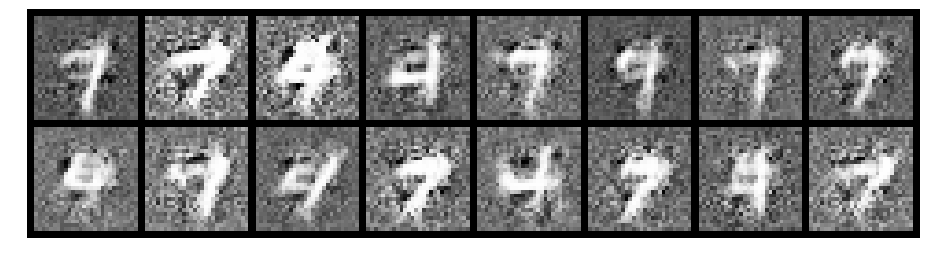

Epoch: [173/200], Batch Num: [0/600]
Discriminator Loss: 0.8871, Generator Loss: 2.0015
D(x): 0.7499, D(G(z)): 0.2390
Epoch: [173/200], Batch Num: [100/600]
Discriminator Loss: 0.6339, Generator Loss: 1.8741
D(x): 0.7991, D(G(z)): 0.2419


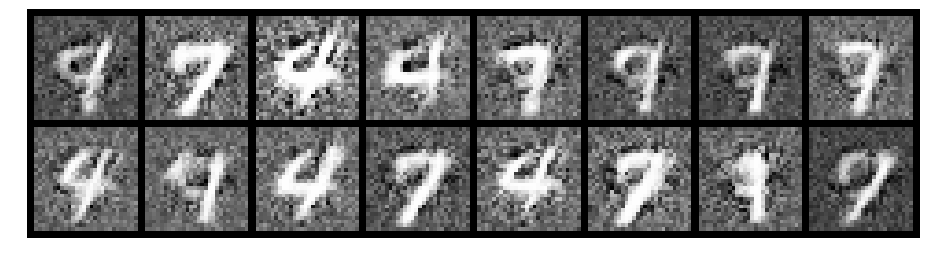

Epoch: [174/200], Batch Num: [0/600]
Discriminator Loss: 0.8090, Generator Loss: 2.0201
D(x): 0.7400, D(G(z)): 0.2539
Epoch: [174/200], Batch Num: [100/600]
Discriminator Loss: 0.5857, Generator Loss: 1.7087
D(x): 0.8148, D(G(z)): 0.2309


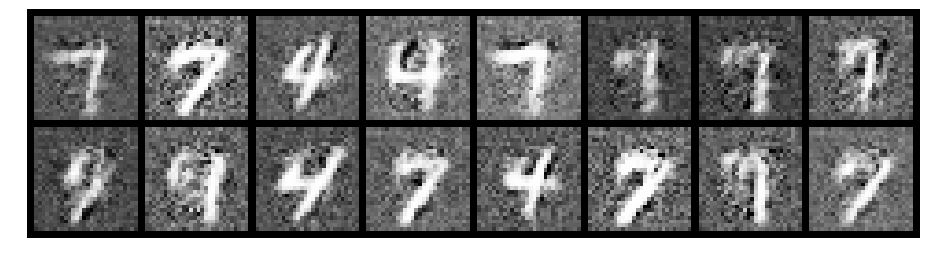

Epoch: [175/200], Batch Num: [0/600]
Discriminator Loss: 0.8349, Generator Loss: 1.7940
D(x): 0.7722, D(G(z)): 0.2530
Epoch: [175/200], Batch Num: [100/600]
Discriminator Loss: 0.7251, Generator Loss: 1.8900
D(x): 0.7802, D(G(z)): 0.2424


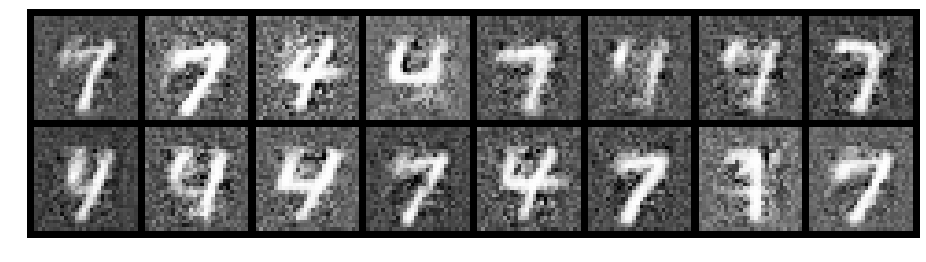

Epoch: [176/200], Batch Num: [0/600]
Discriminator Loss: 0.7194, Generator Loss: 1.8988
D(x): 0.7620, D(G(z)): 0.2285
Epoch: [176/200], Batch Num: [100/600]
Discriminator Loss: 0.6044, Generator Loss: 2.3820
D(x): 0.8149, D(G(z)): 0.1963


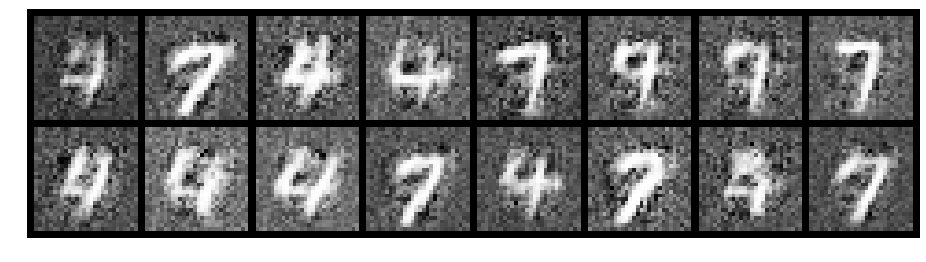

Epoch: [177/200], Batch Num: [0/600]
Discriminator Loss: 0.6551, Generator Loss: 1.6665
D(x): 0.7903, D(G(z)): 0.2527
Epoch: [177/200], Batch Num: [100/600]
Discriminator Loss: 0.7978, Generator Loss: 2.0197
D(x): 0.7164, D(G(z)): 0.2146


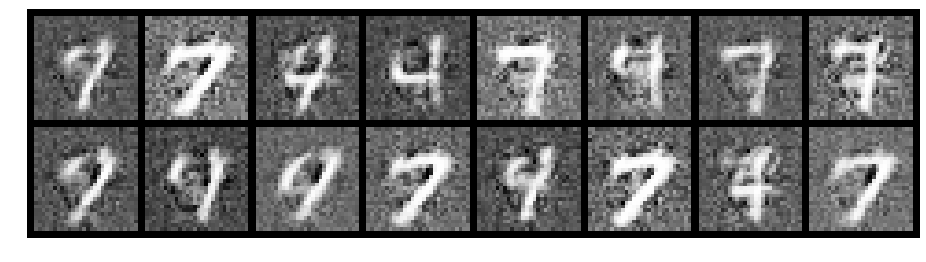

Epoch: [178/200], Batch Num: [0/600]
Discriminator Loss: 0.7220, Generator Loss: 1.4940
D(x): 0.7354, D(G(z)): 0.2468
Epoch: [178/200], Batch Num: [100/600]
Discriminator Loss: 0.7504, Generator Loss: 2.3786
D(x): 0.7942, D(G(z)): 0.2392


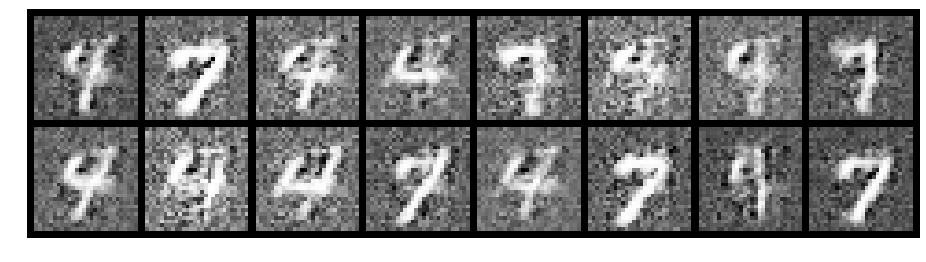

Epoch: [179/200], Batch Num: [0/600]
Discriminator Loss: 0.8677, Generator Loss: 1.9107
D(x): 0.6842, D(G(z)): 0.2181
Epoch: [179/200], Batch Num: [100/600]
Discriminator Loss: 0.7186, Generator Loss: 1.8466
D(x): 0.7963, D(G(z)): 0.2259


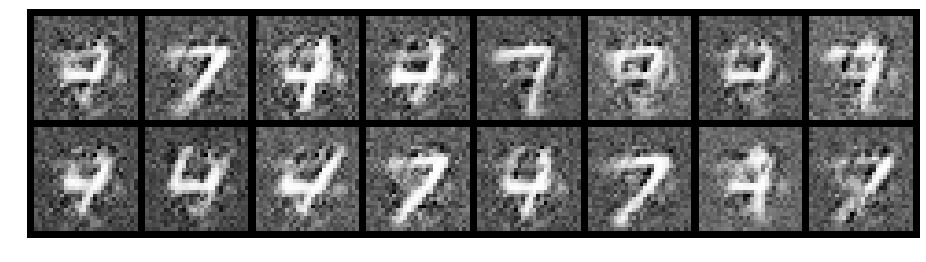

Epoch: [180/200], Batch Num: [0/600]
Discriminator Loss: 0.6289, Generator Loss: 1.7777
D(x): 0.8063, D(G(z)): 0.2458
Epoch: [180/200], Batch Num: [100/600]
Discriminator Loss: 0.7608, Generator Loss: 2.1301
D(x): 0.7611, D(G(z)): 0.2126


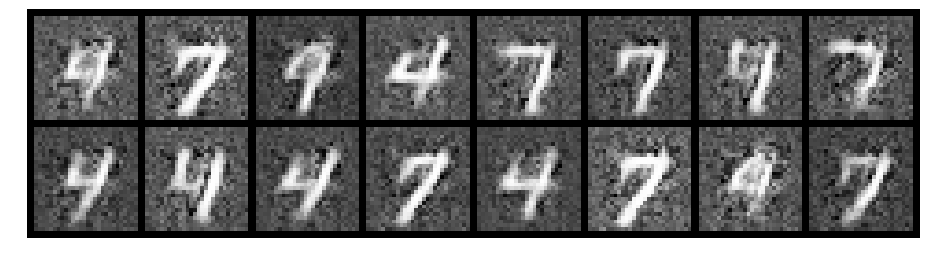

Epoch: [181/200], Batch Num: [0/600]
Discriminator Loss: 0.6699, Generator Loss: 1.8866
D(x): 0.8131, D(G(z)): 0.2230
Epoch: [181/200], Batch Num: [100/600]
Discriminator Loss: 0.7494, Generator Loss: 2.1051
D(x): 0.7665, D(G(z)): 0.2107


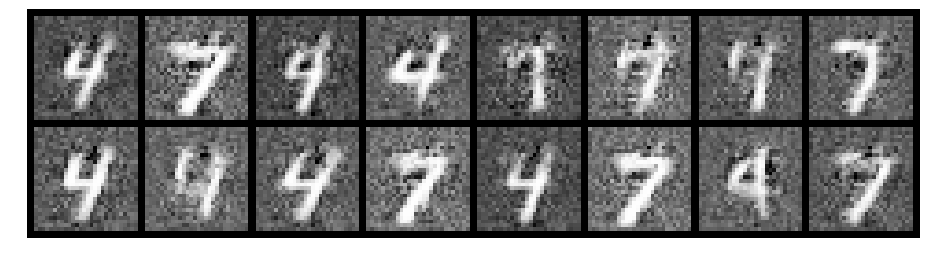

Epoch: [182/200], Batch Num: [0/600]
Discriminator Loss: 0.7047, Generator Loss: 1.7834
D(x): 0.7768, D(G(z)): 0.2177
Epoch: [182/200], Batch Num: [100/600]
Discriminator Loss: 0.8954, Generator Loss: 1.6896
D(x): 0.6694, D(G(z)): 0.2355


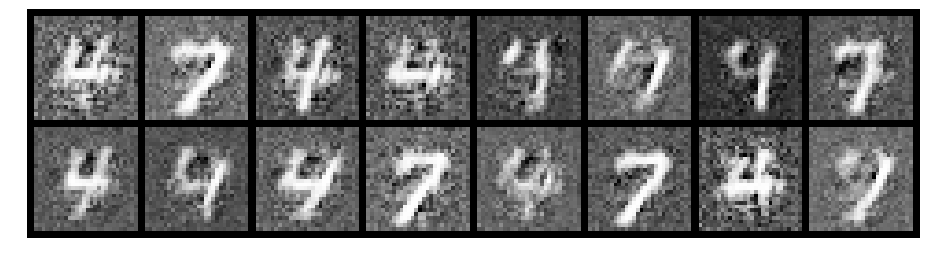

Epoch: [183/200], Batch Num: [0/600]
Discriminator Loss: 0.7793, Generator Loss: 2.0131
D(x): 0.8258, D(G(z)): 0.2897
Epoch: [183/200], Batch Num: [100/600]
Discriminator Loss: 0.6597, Generator Loss: 2.1650
D(x): 0.7834, D(G(z)): 0.1860


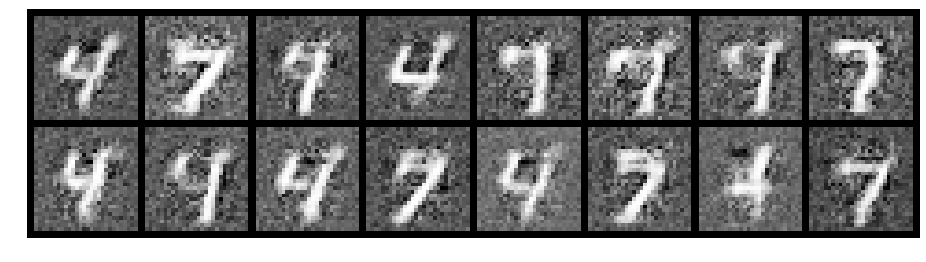

Epoch: [184/200], Batch Num: [0/600]
Discriminator Loss: 0.8205, Generator Loss: 2.0292
D(x): 0.8057, D(G(z)): 0.2714
Epoch: [184/200], Batch Num: [100/600]
Discriminator Loss: 0.5664, Generator Loss: 1.8875
D(x): 0.7993, D(G(z)): 0.1826


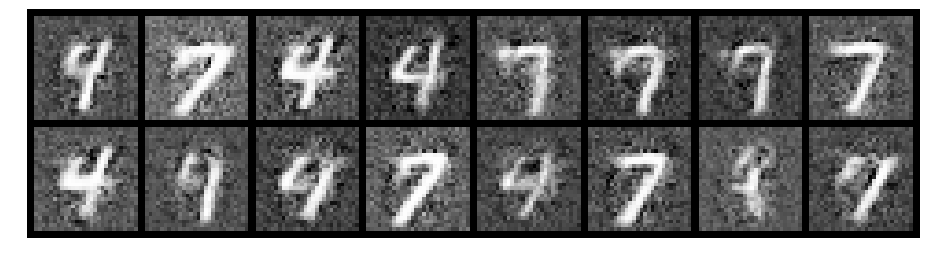

Epoch: [185/200], Batch Num: [0/600]
Discriminator Loss: 0.7888, Generator Loss: 1.5733
D(x): 0.7531, D(G(z)): 0.2697
Epoch: [185/200], Batch Num: [100/600]
Discriminator Loss: 0.6696, Generator Loss: 2.0725
D(x): 0.7869, D(G(z)): 0.2115


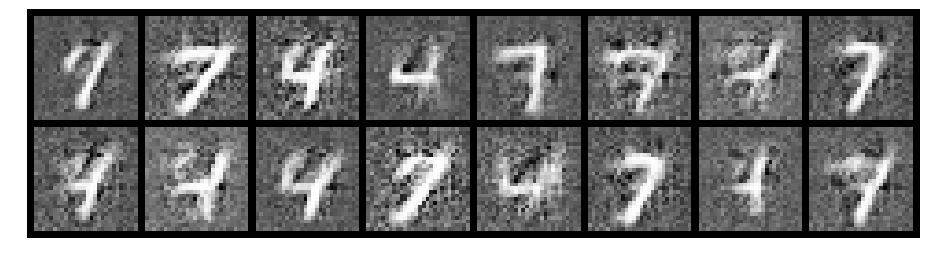

Epoch: [186/200], Batch Num: [0/600]
Discriminator Loss: 0.7646, Generator Loss: 1.8108
D(x): 0.7829, D(G(z)): 0.2539
Epoch: [186/200], Batch Num: [100/600]
Discriminator Loss: 0.4953, Generator Loss: 1.7849
D(x): 0.8349, D(G(z)): 0.1942


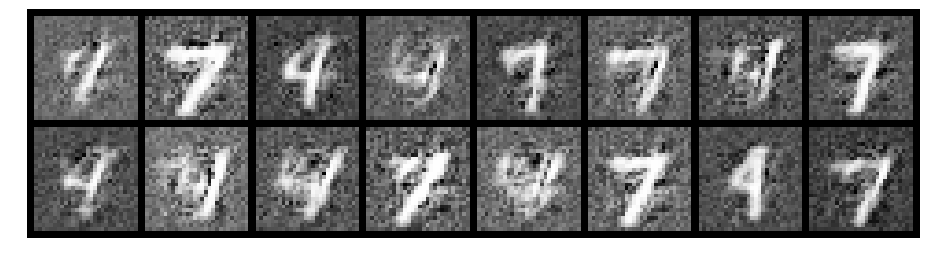

Epoch: [187/200], Batch Num: [0/600]
Discriminator Loss: 0.5911, Generator Loss: 1.8825
D(x): 0.8509, D(G(z)): 0.2412
Epoch: [187/200], Batch Num: [100/600]
Discriminator Loss: 0.5582, Generator Loss: 1.7298
D(x): 0.8375, D(G(z)): 0.2512


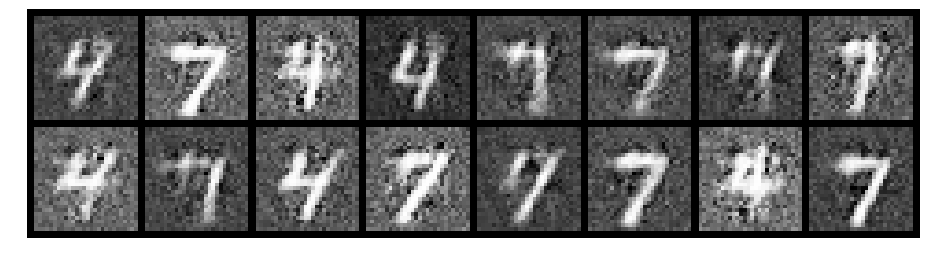

Epoch: [188/200], Batch Num: [0/600]
Discriminator Loss: 0.9741, Generator Loss: 2.2567
D(x): 0.6743, D(G(z)): 0.2032
Epoch: [188/200], Batch Num: [100/600]
Discriminator Loss: 0.5260, Generator Loss: 2.2688
D(x): 0.8232, D(G(z)): 0.1800


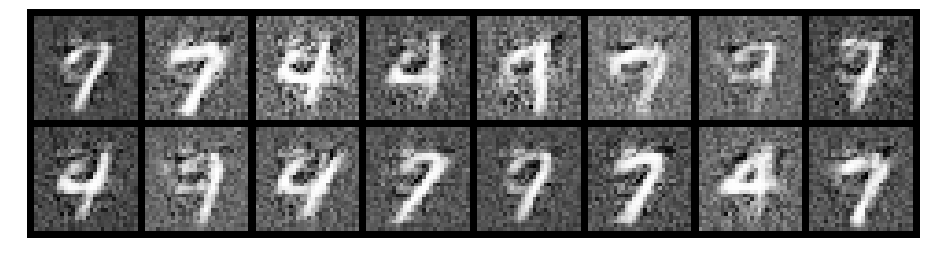

Epoch: [189/200], Batch Num: [0/600]
Discriminator Loss: 0.7657, Generator Loss: 1.8333
D(x): 0.7460, D(G(z)): 0.2338
Epoch: [189/200], Batch Num: [100/600]
Discriminator Loss: 0.6095, Generator Loss: 2.0106
D(x): 0.8200, D(G(z)): 0.2322


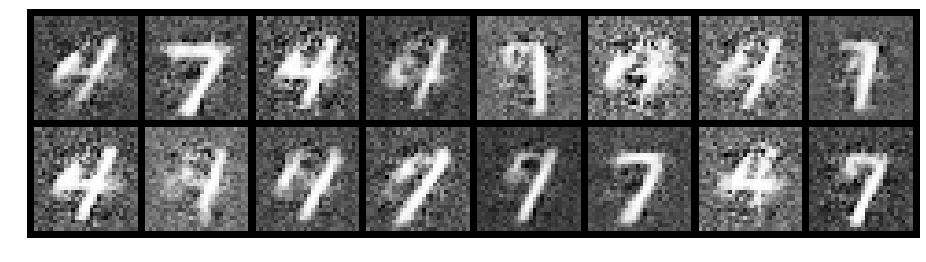

Epoch: [190/200], Batch Num: [0/600]
Discriminator Loss: 0.7614, Generator Loss: 2.0135
D(x): 0.7440, D(G(z)): 0.2178
Epoch: [190/200], Batch Num: [100/600]
Discriminator Loss: 0.4840, Generator Loss: 2.0308
D(x): 0.8260, D(G(z)): 0.1805


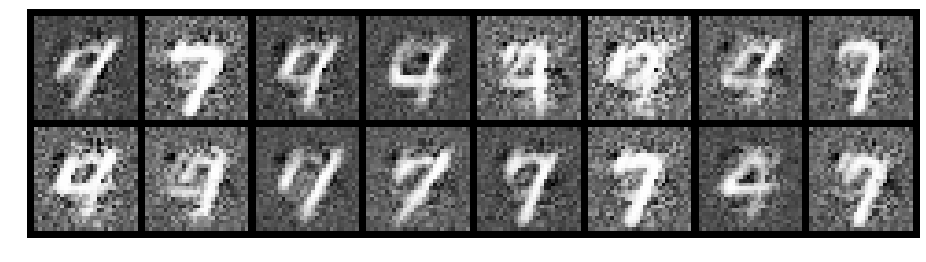

Epoch: [191/200], Batch Num: [0/600]
Discriminator Loss: 0.7407, Generator Loss: 2.1637
D(x): 0.7271, D(G(z)): 0.1757
Epoch: [191/200], Batch Num: [100/600]
Discriminator Loss: 0.5951, Generator Loss: 1.9009
D(x): 0.8071, D(G(z)): 0.1870


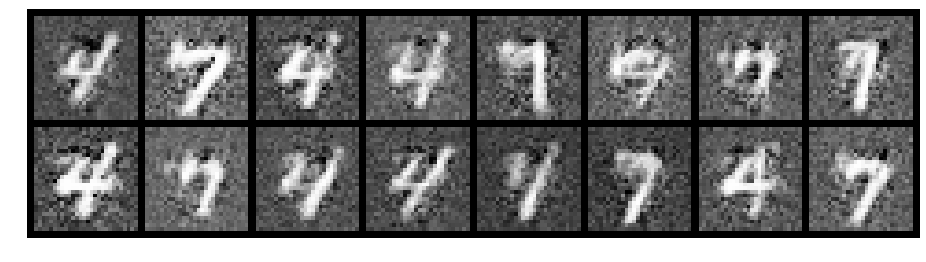

Epoch: [192/200], Batch Num: [0/600]
Discriminator Loss: 0.6367, Generator Loss: 1.9408
D(x): 0.7901, D(G(z)): 0.1746
Epoch: [192/200], Batch Num: [100/600]
Discriminator Loss: 0.6520, Generator Loss: 2.2660
D(x): 0.8170, D(G(z)): 0.1926


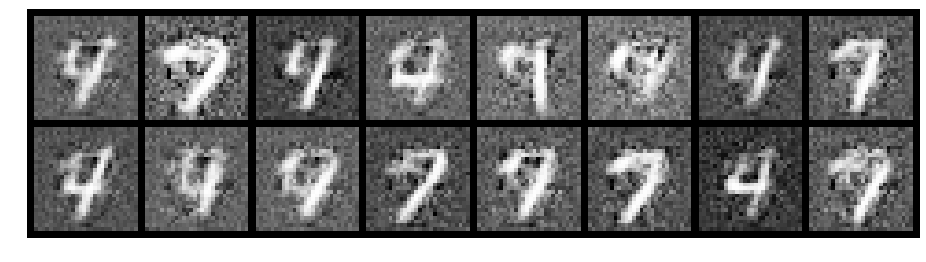

Epoch: [193/200], Batch Num: [0/600]
Discriminator Loss: 0.5801, Generator Loss: 1.8400
D(x): 0.8128, D(G(z)): 0.2152
Epoch: [193/200], Batch Num: [100/600]
Discriminator Loss: 0.5743, Generator Loss: 2.1390
D(x): 0.8133, D(G(z)): 0.1892


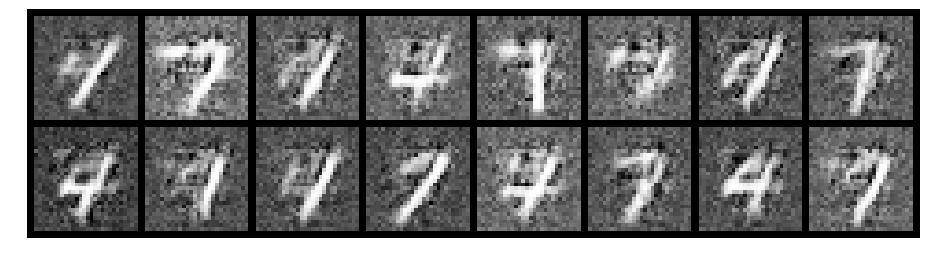

Epoch: [194/200], Batch Num: [0/600]
Discriminator Loss: 0.6101, Generator Loss: 1.8405
D(x): 0.8022, D(G(z)): 0.2098
Epoch: [194/200], Batch Num: [100/600]
Discriminator Loss: 0.6826, Generator Loss: 1.8751
D(x): 0.8170, D(G(z)): 0.2440


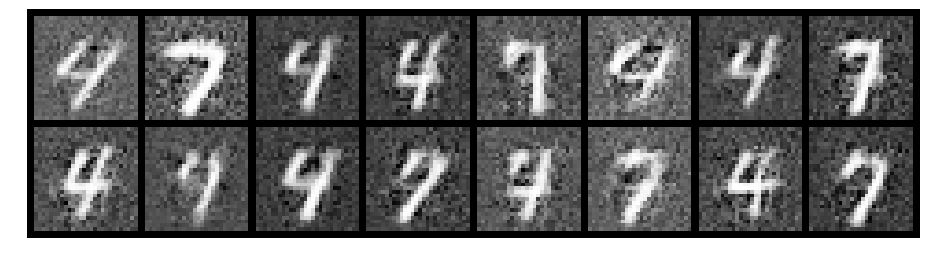

Epoch: [195/200], Batch Num: [0/600]
Discriminator Loss: 0.9688, Generator Loss: 1.7743
D(x): 0.6868, D(G(z)): 0.2518
Epoch: [195/200], Batch Num: [100/600]
Discriminator Loss: 0.5813, Generator Loss: 1.7945
D(x): 0.8195, D(G(z)): 0.2096


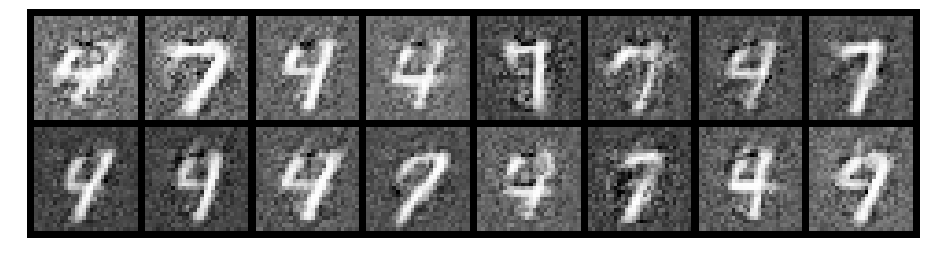

Epoch: [196/200], Batch Num: [0/600]
Discriminator Loss: 0.9220, Generator Loss: 1.8374
D(x): 0.7319, D(G(z)): 0.2682
Epoch: [196/200], Batch Num: [100/600]
Discriminator Loss: 0.6058, Generator Loss: 2.2306
D(x): 0.8244, D(G(z)): 0.1877


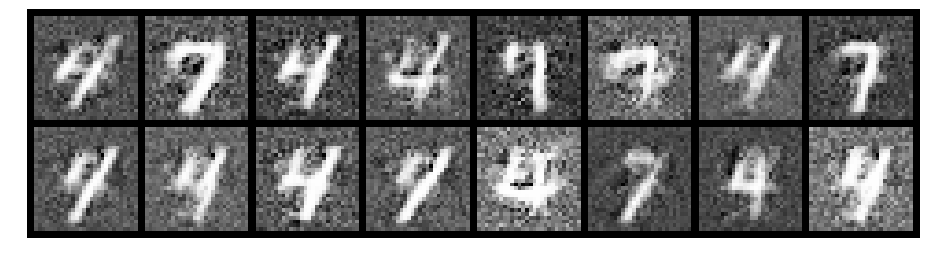

Epoch: [197/200], Batch Num: [0/600]
Discriminator Loss: 0.5090, Generator Loss: 1.9985
D(x): 0.8723, D(G(z)): 0.2294
Epoch: [197/200], Batch Num: [100/600]
Discriminator Loss: 0.6506, Generator Loss: 1.9671
D(x): 0.7625, D(G(z)): 0.1818


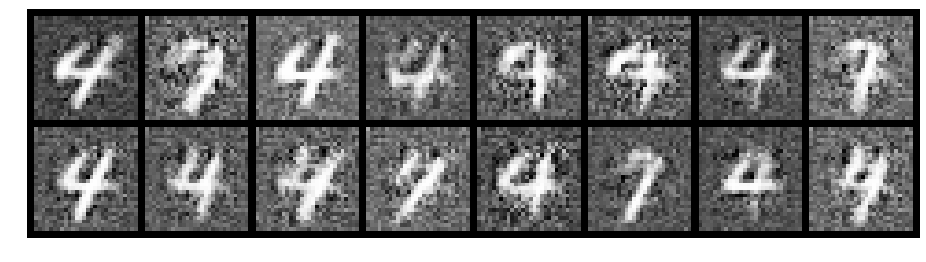

Epoch: [198/200], Batch Num: [0/600]
Discriminator Loss: 0.5772, Generator Loss: 2.0945
D(x): 0.8766, D(G(z)): 0.2213
Epoch: [198/200], Batch Num: [100/600]
Discriminator Loss: 0.6181, Generator Loss: 2.1773
D(x): 0.8057, D(G(z)): 0.1989


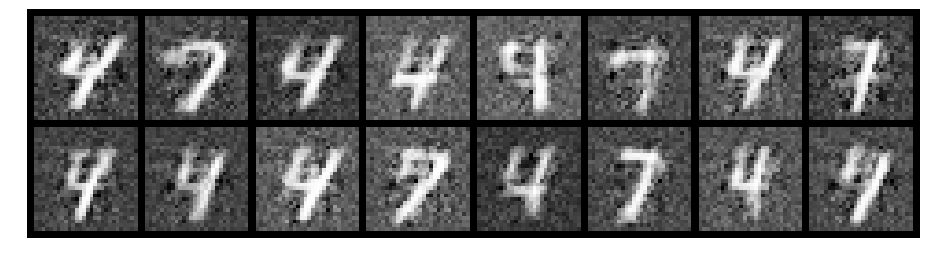

Epoch: [199/200], Batch Num: [0/600]
Discriminator Loss: 0.4792, Generator Loss: 2.3429
D(x): 0.8345, D(G(z)): 0.1546
Epoch: [199/200], Batch Num: [100/600]
Discriminator Loss: 0.7073, Generator Loss: 2.2954
D(x): 0.7709, D(G(z)): 0.1781


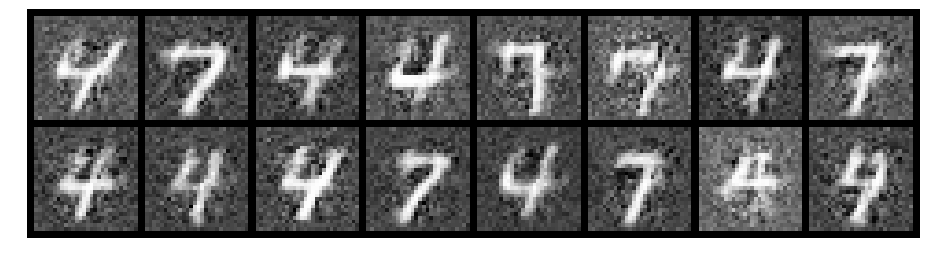

In [62]:
!pip install tensorboardx
import matplotlib.pyplot as plt 
from utils import Logger
import numpy as np
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    n_batch = 0    
    for real_batch, _ in data_loader:
        
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        
        fake_data = generator(noise(real_data.size(0))).detach()
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        

        if (n_batch) % 100 == 0:
            
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        
        logger.save_models(generator, discriminator, epoch)
        
        n_batch += 1
    
    with torch.no_grad():
        test_images = vectors_to_images(generator(test_noise)).data.cpu()
        logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);

# Save trained parameters

In [0]:
torch.save(generator.state_dict(), 'gen147.model')
torch.save(discriminator.state_dict(), 'disc147.model')